# Test info status time hypotheses

We have a few competing hypotheses for how info status changes over time.

- Unidirectional: more time => less treatment of entities with new information status
- Event-response: immediately before event => more new info status; after event => less new info status (drop) followed by slow increase

For these tests, we'll use presence of descriptor as a marker for information status.

## Load data

In [115]:
import pandas as pd
import dateutil
from datetime import datetime
# combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', compression='gzip', index_col=False, converters={'date':lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()})
combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', compression='gzip', index_col=False, converters={'date':lambda x: dateutil.parser.parse(x).timestamp()})
display(combined_tag_data.head())
# remove bad stuff
bad_loc_NEs = set(['hurricane'] + list(combined_tag_data.loc[:, 'data_name_fixed'].unique()))
combined_tag_data = combined_tag_data[combined_tag_data.apply(lambda x: not (x.loc['NE_fixed'] in bad_loc_NEs and x.loc['valid_loc']), axis=1)]
combined_tag_data_valid_loc = combined_tag_data[combined_tag_data.loc[:, 'valid_loc']]
print('%d/%d statuses with valid loc'%(combined_tag_data_valid_loc.loc[:, 'id'].nunique(), combined_tag_data.loc[:, 'id'].nunique()))

id                                                txt  \
0  914030327777067008  RT @chefjoseandres: Quick update from #PuertoR...   
1  914031326042435584  #Support #Purchase @X_RATED25  Single (#DontHa...   
2  914031644784431110  RT @Scavino45: POTUS' @realDonaldTrump on Hurr...   
3  914031644784431110  RT @Scavino45: POTUS' @realDonaldTrump on Hurr...   
4  914031795787763713  RT @altNOAA: .@realDonaldTrump If you can't ge...   

  data_name_fixed      username           date lang         NE   NE_type  \
0           maria  EmeraidKatNJ 1506756786.000   en        NaN       NaN   
1           maria     X_RATED25 1506757024.000   en        NaN       NaN   
2           maria   D_McCaughan 1506757100.000   en      POTUS    PERSON   
3           maria   D_McCaughan 1506757100.000   en  Hurricane  LOCATION   
4           maria   eccolabella 1506757136.000   en        NaN       NaN   

   NE_LOC  valid_loc  has_descriptor   NE_fixed  
0   False      False           False        NaN  
1   False      False           False        NaN  
2   False      False           False      potus  
3    True      False           False  hurricane  
4   False      False           False        NaN

118353/1889567 statuses with valid loc


Let's investigate the top-k locations per data set.

In [116]:
# sanity check: top-k locations per data set
top_k = 20
for data_name_i, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    print('- **%s**'%(data_name_i))
    data_i_NE_counts = data_i.loc[:, 'NE_fixed'].value_counts()
    print(data_i_NE_counts[:top_k])

- **florence**
wilmington            1289
carolina               556
myrtle_beach           298
raleigh                273
conway                 161
charleston             142
wrightsville_beach     132
jacksonville           124
morehead_city          106
horry_county            98
richmond                97
georgetown              79
red_cross               79
brunswick               69
pender_county           68
greenville              65
spring_lake             65
pee_dee                 62
atlanta                 61
cape_fear               54
Name: NE_fixed, dtype: int64
- **harvey**
houston           37645
corpus_christi     3599
rockport           2930
austin             1859
dallas             1379
galveston          1125
port_aransas       1001
port_arthur         638
harris_county       612
dickinson           376
victoria            352
aransas_pass        341
sandy               268
nola                253
pearland            235
kingwood            198
league_city        

## Visualize info status
To start, let's visualize the distribution of information status over time for the most popular NEs.

We'll do this with overlaid KDE plots for descriptor/non-descriptor occurrence.

processing florence data


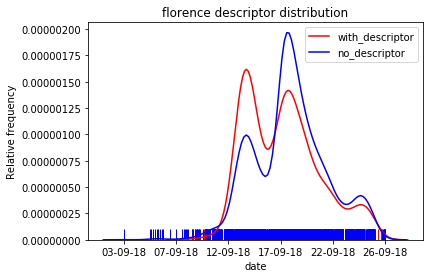

processing harvey data


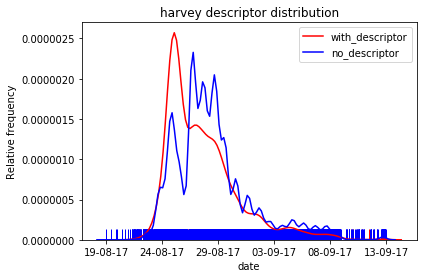

processing irma data


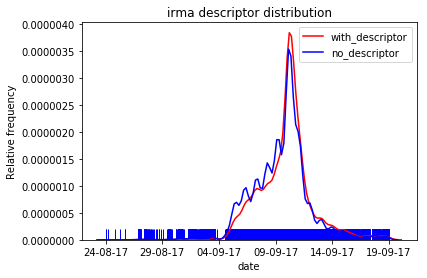

processing maria data


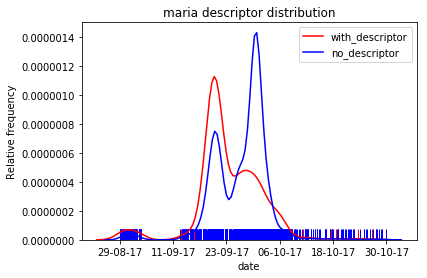

processing michael data


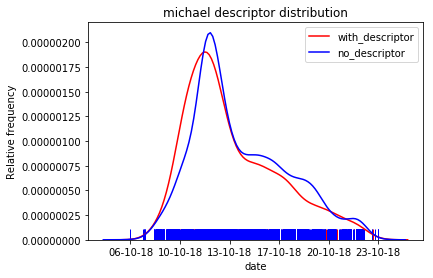

In [117]:
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# overall probs
N_date_ticks = 6
for data_i_name, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    print('processing %s data'%(data_i_name))
    top_k_NE = data_i.loc[:, 'NE_fixed'].value_counts()[:top_k].index
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(top_k_NE)]
    X = np.linspace(data_i.loc[:, 'date'].min(), data_i.loc[:, 'date'].max(), N_date_ticks)
    date_fmt = '%d-%m-%y'
    X_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X]
    # set N_bins to unique number of days
    N_bins = (datetime.fromtimestamp(X[-1]) - datetime.fromtimestamp(X[0])).days
    data_i_descriptor = data_i[data_i.loc[:, 'has_descriptor']==1]
    data_i_non_descriptor = data_i[data_i.loc[:, 'has_descriptor']==0]
    sns.distplot(data_i_descriptor.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='r', label='with_descriptor')
    sns.distplot(data_i_non_descriptor.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='b', label='no_descriptor')
    plt.xticks(X, X_str)
    plt.ylabel('Relative frequency')
    plt.legend(loc='upper right')
    plt.title('%s descriptor distribution'%(data_i_name))
    plt.show()

processing florence data


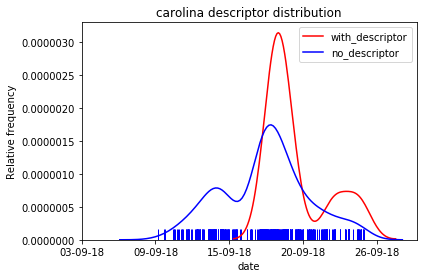

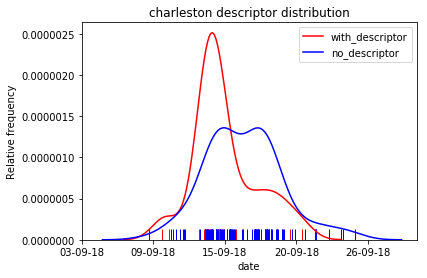

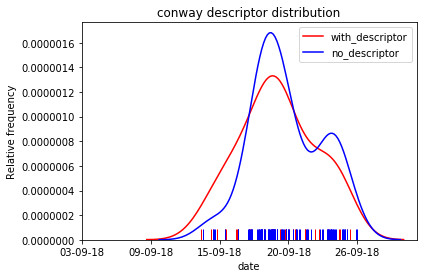

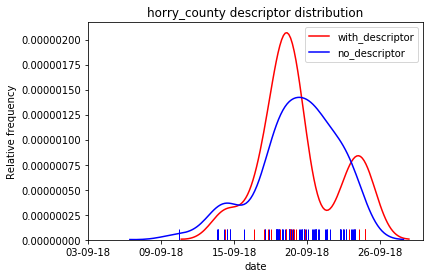

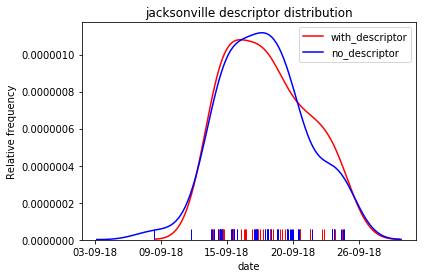

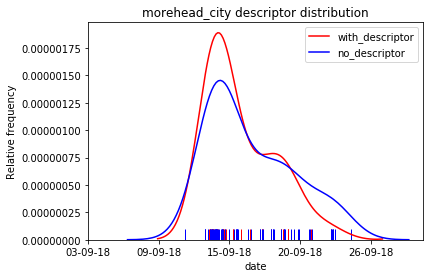

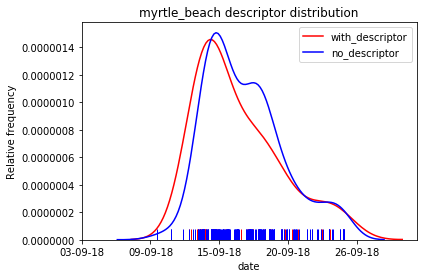

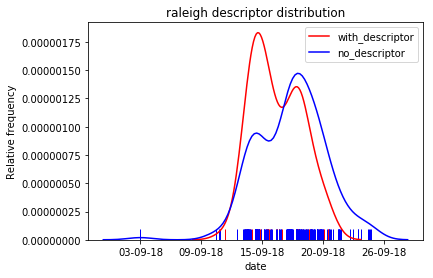

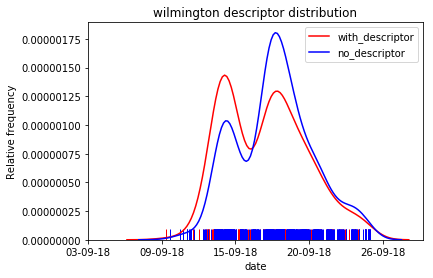

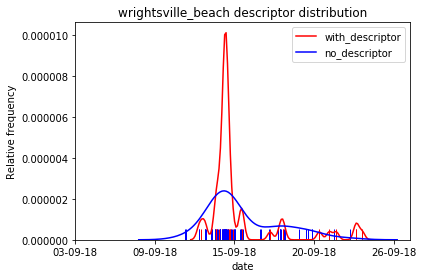

processing harvey data


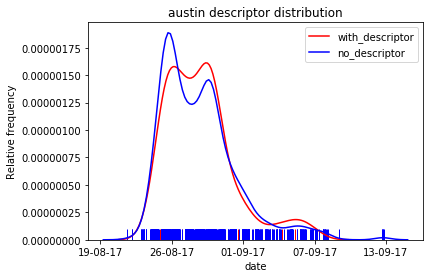

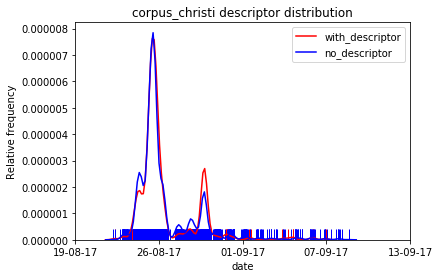

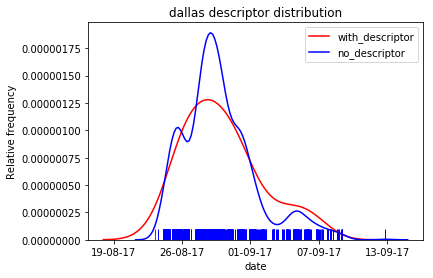

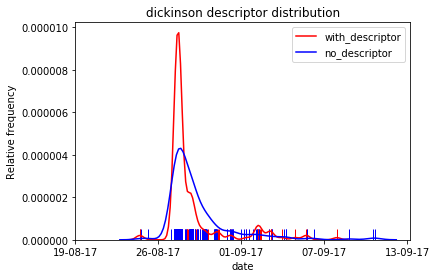

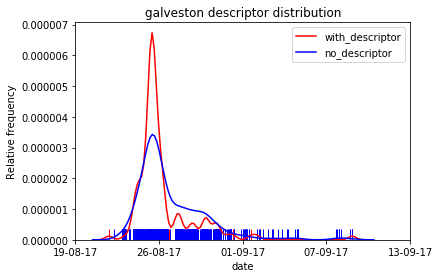

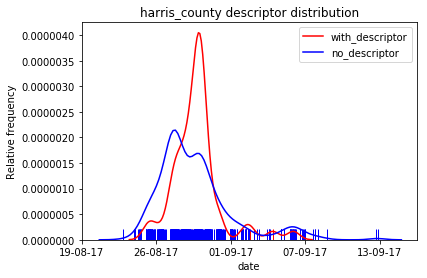

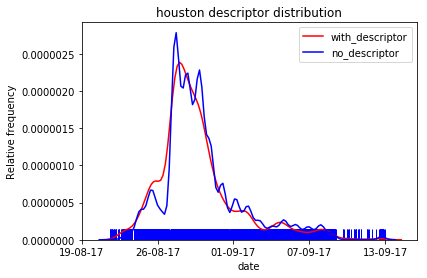

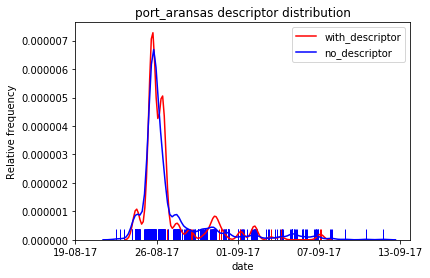

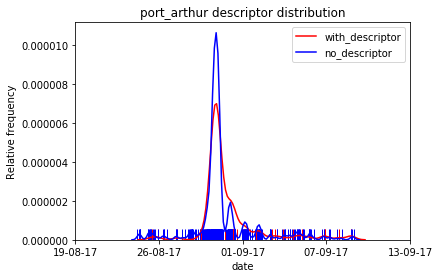

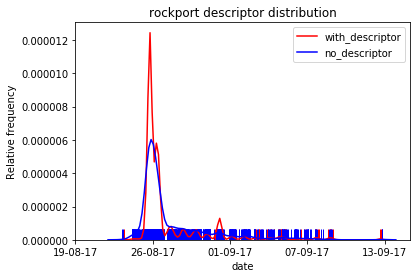

processing irma data


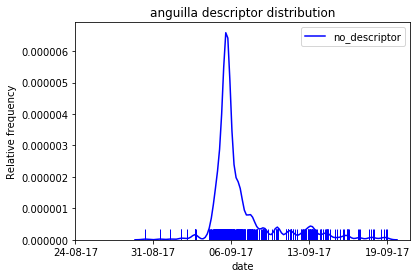

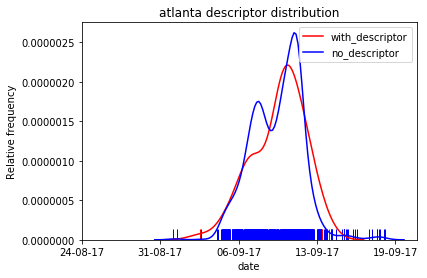

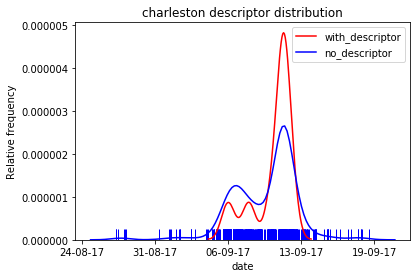

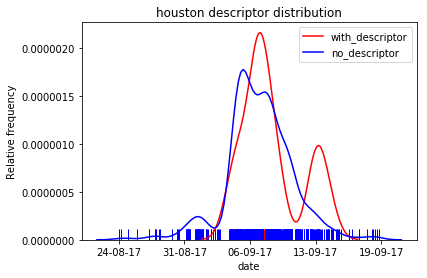

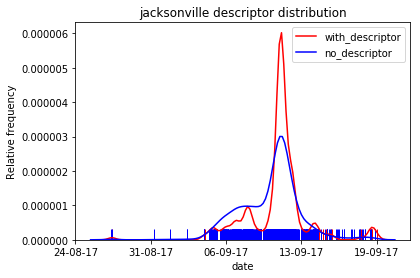

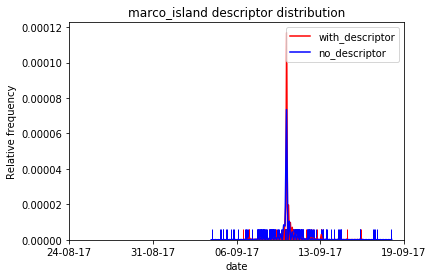

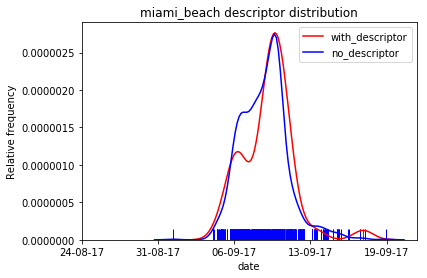

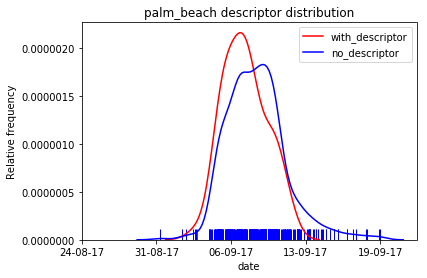

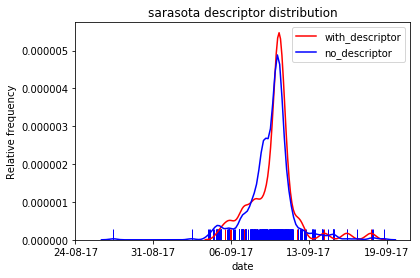

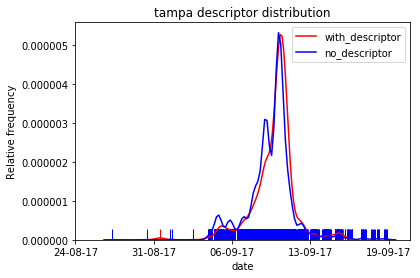

processing maria data


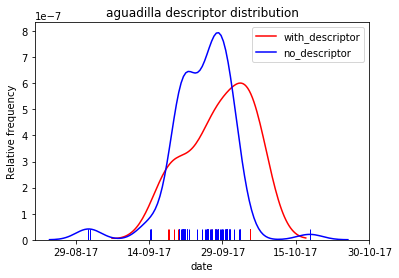

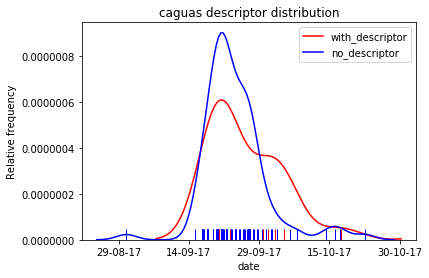

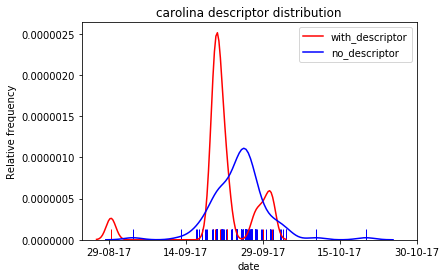

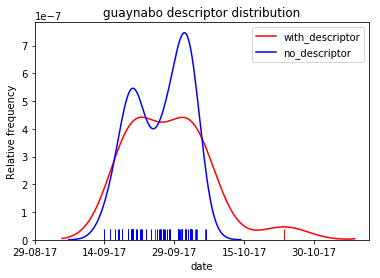

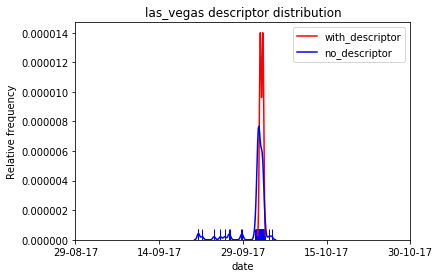

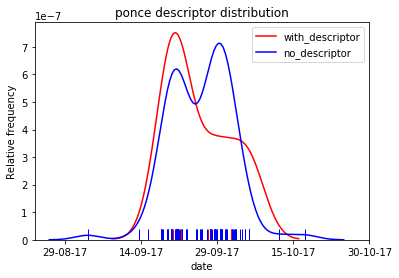

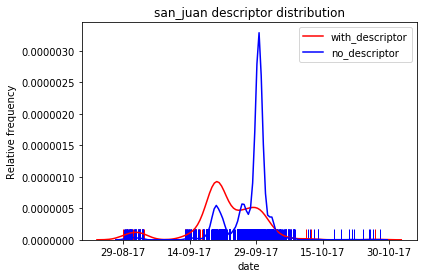

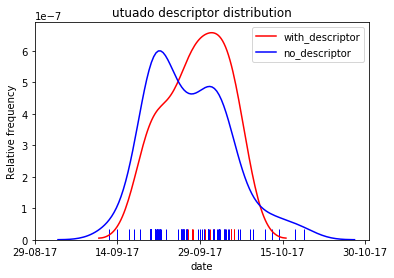

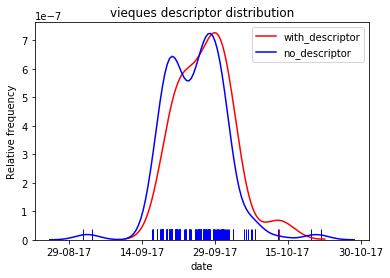

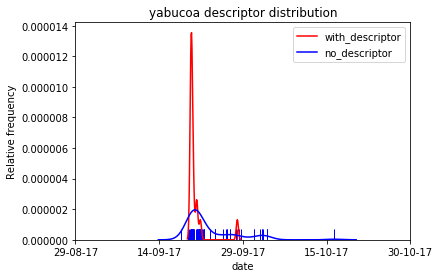

processing michael data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


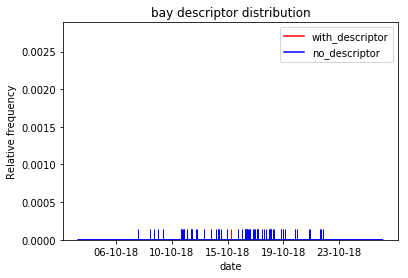

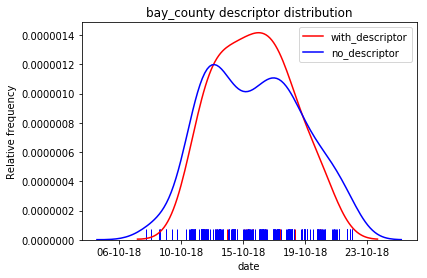

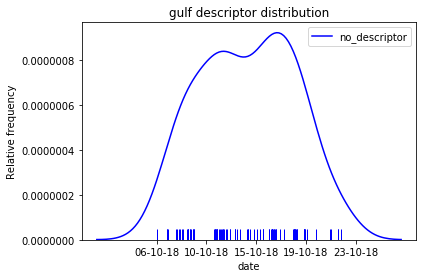

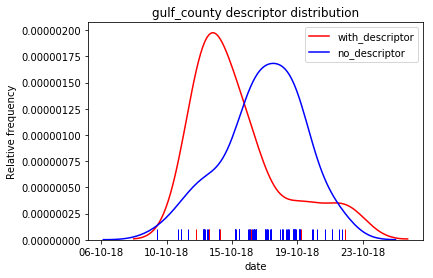

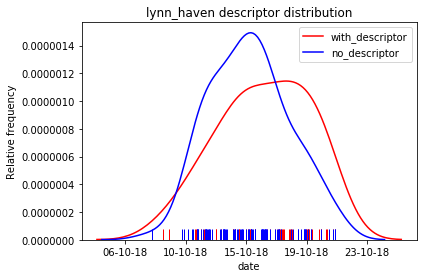

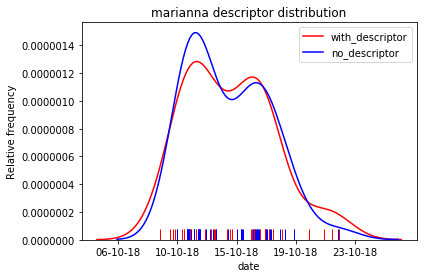

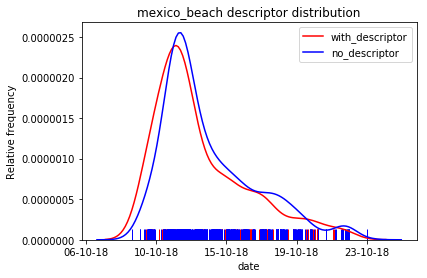

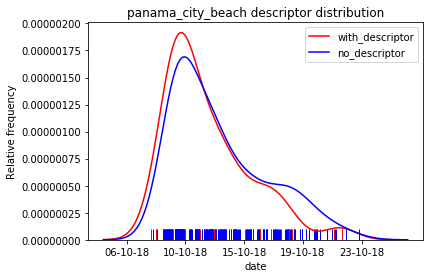

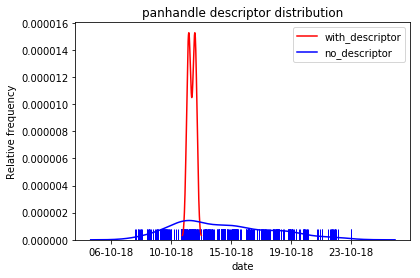

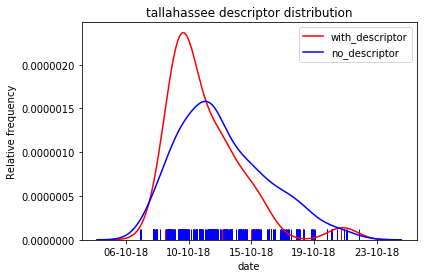

In [118]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
top_k = 10
N_date_ticks = 5
N_bins = 20
for data_i_name, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    print('processing %s data'%(data_i_name))
    top_k_NE = data_i.loc[:, 'NE_fixed'].value_counts()[:top_k].index
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(top_k_NE)]
    X = np.linspace(data_i.loc[:, 'date'].min(), data_i.loc[:, 'date'].max(), N_date_ticks)
    date_fmt = '%d-%m-%y'
    X_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X]
    # set N_bins to unique number of days
    N_bins = (datetime.fromtimestamp(X[-1]) - datetime.fromtimestamp(X[0])).days
    for NE_j, data_i_j in data_i_k.groupby('NE_fixed'):        
        data_j = data_i[data_i.loc[:, 'NE_fixed']==NE_j]
        data_j_descriptor = data_j[data_j.loc[:, 'has_descriptor']==1]
        data_j_non_descriptor = data_j[data_j.loc[:, 'has_descriptor']==0]
        sns.distplot(data_j_descriptor.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='r', label='with_descriptor')
        sns.distplot(data_j_non_descriptor.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='b', label='no_descriptor')
        plt.xticks(X, X_str)
        plt.ylabel('Relative frequency')
        plt.legend(loc='upper right')
        plt.title('%s descriptor distribution'%(NE_j))
        plt.show()

In general, it seems like the descriptor/no-descriptor distributions overlap considerably. 

Is there any significant trend for locations in general?

$$H_{0}: \text{date(non-descriptor)} = \text{date(descriptor)}$$

$$H_{1}: \text{date(non-descriptor)} < \text{date(descriptor)}$$

To do this test, we'll restrict ourselves to NEs that have at least $d$ appearances with descriptor and without descriptor.

In [119]:
from scipy.stats import mannwhitneyu
def extract_freq_NEs(data, dep_var='has_descriptor', min_count_0=10, min_count_1=10):
    data_dep_0 = data[data.loc[:, dep_var]==0]
    data_dep_1 = data[data.loc[:, dep_var]==1]
    NE_count_0 = data_dep_0.loc[:, 'NE_fixed'].value_counts()
    NE_count_1 = data_dep_1.loc[:, 'NE_fixed'].value_counts()
    freq_NEs = NE_count_0[NE_count_0 >= min_count_0].index & NE_count_1[NE_count_1 >= min_count_1].index
    freq_NEs = list(freq_NEs)
    print('%d freq NEs'%(len(freq_NEs)))
    return freq_NEs
for data_name_i, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    freq_NEs_i = extract_freq_NEs(data_i)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    data_i_k_non_descriptor = data_i_k[data_i_k.loc[:, 'has_descriptor']==0]
    data_i_k_descriptor = data_i_k[data_i_k.loc[:, 'has_descriptor']==1]
    data_i_k_non_descriptor_dates = data_i_k_non_descriptor.loc[:, 'date']
    data_i_k_descriptor_dates = data_i_k_descriptor.loc[:, 'date']
    print('non-descriptor - descriptor date %.3f'%(data_i_k_non_descriptor_dates.median() - data_i_k_descriptor_dates.median()))
    test_stat, p_val = mannwhitneyu(data_i_k_non_descriptor_dates, data_i_k_descriptor_dates)
    print('diff is significant stat=%.3f (p=%.3f, N=%d)'%(test_stat, p_val, data_i_k.shape[0]))

26 freq NEs
non-descriptor - descriptor date 18774.500
diff is significant stat=1176708.000 (p=0.000, N=3432)
44 freq NEs
non-descriptor - descriptor date 94850.500
diff is significant stat=93811940.500 (p=0.000, N=54881)
64 freq NEs
non-descriptor - descriptor date -23688.500
diff is significant stat=20453549.000 (p=0.000, N=21481)
14 freq NEs
non-descriptor - descriptor date 681766.000
diff is significant stat=786884.000 (p=0.000, N=5070)
13 freq NEs
non-descriptor - descriptor date 63945.000
diff is significant stat=802444.000 (p=0.000, N=2991)


OK! In general the non-descriptor statuses tend to occur later than the descriptor statuses.

What if we flip the hypothesis so it makes more sense?

$$H_{1}: \text{P(descriptor, early)} < \text{P(descriptor, late)}$$

We'll define the split between early/late as the median, and plot everything too.

testing data florence
26 freq NEs
early P(descriptor) - late P(descriptor)=0.053
diff is significant stat=1394545.500 (p=0.000, N=3432)


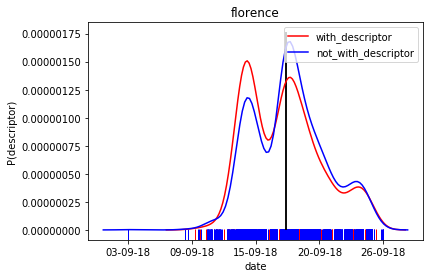

testing data harvey
44 freq NEs
early P(descriptor) - late P(descriptor)=0.045
diff is significant stat=359471614.500 (p=0.000, N=54881)


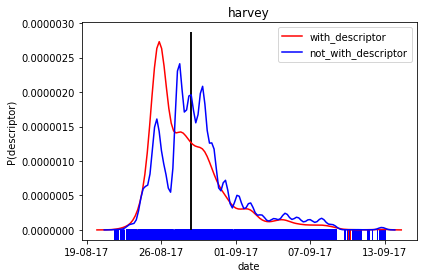

testing data irma
64 freq NEs
early P(descriptor) - late P(descriptor)=-0.049
diff is significant stat=54876504.500 (p=0.000, N=21481)


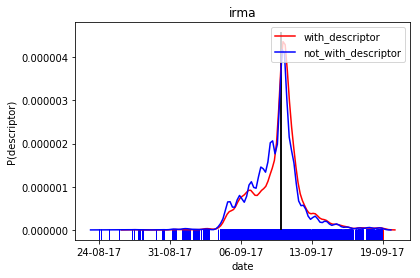

testing data maria
14 freq NEs
early P(descriptor) - late P(descriptor)=0.111
diff is significant stat=2857951.000 (p=0.000, N=5070)


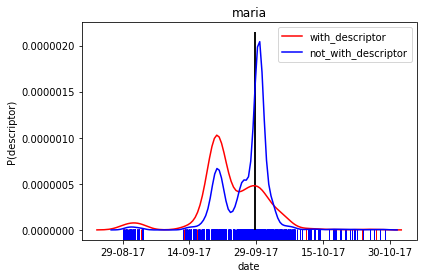

testing data michael
13 freq NEs
early P(descriptor) - late P(descriptor)=0.059
diff is significant stat=1052254.500 (p=0.000, N=2991)


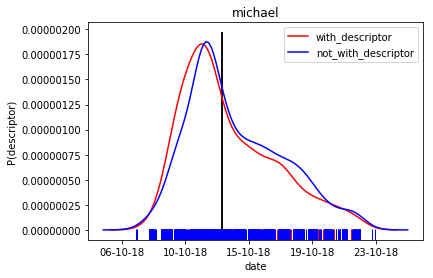

In [120]:
dep_var = 'has_descriptor'
for data_name_i, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    freq_NEs_i = extract_freq_NEs(data_i)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    data_i_k_date_med = data_i_k.loc[:, 'date'].median()
    data_i_k_early = data_i_k[data_i_k.loc[:, 'date'] < data_i_k_date_med]
    data_i_k_late = data_i_k[data_i_k.loc[:, 'date'] >= data_i_k_date_med]
    prob_early = data_i_k_early.loc[:, dep_var].sum() / data_i_k_early.shape[0]
    prob_late = data_i_k_late.loc[:, dep_var].sum() / data_i_k_late.shape[0]
    print('early P(descriptor) - late P(descriptor)=%.3f'%(prob_early - prob_late))
    test_stat, p_val = mannwhitneyu(data_i_k_early.loc[:, dep_var], data_i_k_late.loc[:, dep_var])
    print('diff is significant stat=%.3f (p=%.3f, N=%d)'%(test_stat, p_val, data_i_k.shape[0]))
    ## also show density plot with before/after marker
    data_i_k_dep = data_i_k[data_i_k.loc[:, dep_var]==1]
    data_i_k_no_dep = data_i_k[data_i_k.loc[:, dep_var]==0]
    X = np.linspace(data_i.loc[:, 'date'].min(), data_i.loc[:, 'date'].max(), N_date_ticks)
    date_fmt = '%d-%m-%y'
    X_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X]
    N_bins = (datetime.fromtimestamp(X[-1]) - datetime.fromtimestamp(X[0])).days
    sns.distplot(data_i_k_dep.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='r', label='with_descriptor')
    sns.distplot(data_i_k_no_dep.loc[:, 'date'], rug=True, hist=False, bins=N_bins, color='b', label='not_with_descriptor')
    plt.vlines([data_i_k_date_med, data_i_k_date_med], ymin=plt.ylim()[0], ymax=plt.ylim()[1])
    plt.ylabel('P(descriptor)')
    plt.xticks(X, X_str)
    plt.legend(loc='upper right')
    plt.title(data_name_i)
    plt.show()

Similar trend! More descriptor in early phase, except in the case of Irma. Maybe that received more large-scale attention which overrode the usual trajectory?

## Split point tests
Let's use the actual dates of landfall and dissipation as split points.

### Plot probability distributions by split point

In [121]:
from datetime import datetime
# we've already collected relevant hurricane dates
event_dates = pd.read_csv('../../data/hurricane_data/hurricane_dates.tsv', sep='\t', index_col=False, converters={'hurricane_date':lambda x: datetime.strptime('%s EST'%(x), '%d-%m-%y %Z')})
event_dates.rename(columns={'hurricane_name':'data_name_fixed'}, inplace=True)
display(event_dates)

data_name_fixed hurricane_date hurricane_type
0           harvey     2017-08-17           form
1           harvey     2017-08-26       landfall
2           harvey     2017-09-03    dissipation
3            maria     2017-09-16           form
4            maria     2017-09-19       landfall
5            maria     2017-10-02    dissipation
6          michael     2018-10-07           form
7          michael     2018-10-10       landfall
8          michael     2018-10-16    dissipation
9             irma     2017-08-30           form
10            irma     2017-09-06       landfall
11            irma     2017-09-13    dissipation
12        florence     2018-08-31           form
13        florence     2018-09-14       landfall
14        florence     2018-09-19    dissipation

Let's test `landfall` as the before/after split point.

In [122]:
import matplotlib.transforms as tx
from matplotlib.collections import LineCollection

def rugplot_2(a, height=.05, axis="x", ax=None, invert=False, **kwargs):
    """Plot datapoints in an array as sticks on an axis.
    Parameters
    ----------
    a : vector
        1D array of observations.
    height : scalar, optional
        Height of ticks as proportion of the axis.
    axis : {'x' | 'y'}, optional
        Axis to draw rugplot on.
    ax : matplotlib axes, optional
        Axes to draw plot into; otherwise grabs current axes.
    kwargs : key, value pairings
        Other keyword arguments are passed to ``LineCollection``.
    Returns
    -------
    ax : matplotlib axes
        The Axes object with the plot on it.
    """
    if ax is None:
        ax = plt.gca()
    a = np.asarray(a)
    vertical = kwargs.pop("vertical", axis == "y")
    
    alias_map = dict(linewidth="lw", linestyle="ls", color="c")
    for attr, alias in alias_map.items():
        if alias in kwargs:
            kwargs[attr] = kwargs.pop(alias)
    kwargs.setdefault("linewidth", 1)
    
    if(invert):
        height_min = 1.
        height_max = height_min - height
    else:
        height_min = 0
        height_max = height
    
    if vertical:
        trans = tx.blended_transform_factory(ax.transAxes, ax.transData)
        xy_pairs = np.column_stack([np.tile([0, height], len(a)),
                                    np.repeat(a, 2)])
    else:
        trans = tx.blended_transform_factory(ax.transData, ax.transAxes)
        xy_pairs = np.column_stack([np.repeat(a, 2),
                                    np.tile([height_min, height_max], len(a))])
#     print('generated xy pairs\n%s'%(xy_pairs))
    line_segs = xy_pairs.reshape([len(a), 2, 2])
#     print('line segs\n%s'%(line_segs))
    ax.add_collection(LineCollection(line_segs, transform=trans, **kwargs))

    ax.autoscale_view(scalex=not vertical, scaley=vertical)

    return ax

processing data florence
testing data florence
landfall: early P(has_descriptor) - late P(has_descriptor)=0.059
landfall: diff is significant stat=2.799 (p=0.005, N=4574)
dissipation: early P(has_descriptor) - late P(has_descriptor)=0.036
dissipation: diff is significant stat=2.629 (p=0.009, N=4574)
testing date period (09-03-18,09-13-18) vs. (09-13-18,09-18-18)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.047
diff is significant stat=2.138 (p=0.033, N=2901)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.008
diff is significant stat=-0.109 (p=0.913, N=336)
testing date period (09-03-18,09-13-18) vs. (09-18-18,09-26-18)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.075
diff is significant stat=3.333 (p=0.001, N=2190)
balanced data
early P(has_descriptor) - late P(has_descriptor)=0.030
diff is significant stat=0.386 (p=0.699, N=237)
testing date period (09-13-18,09-18-18) vs. (09-18-18,09-26-18)
unbalanced data
early P(has_des

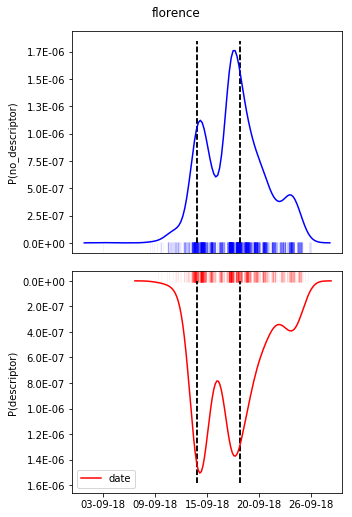

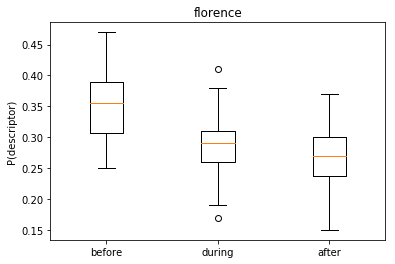

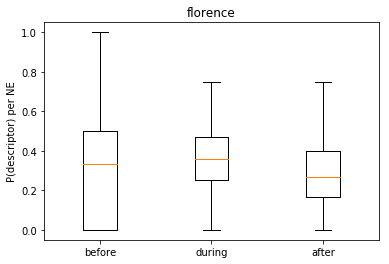

processing data harvey
testing data harvey
landfall: early P(has_descriptor) - late P(has_descriptor)=0.016
landfall: diff is significant stat=4.455 (p=0.000, N=56150)
dissipation: early P(has_descriptor) - late P(has_descriptor)=0.034
dissipation: diff is significant stat=8.261 (p=0.000, N=56150)
testing date period (19-08-17,25-08-17) vs. (25-08-17,02-09-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.013
diff is significant stat=3.419 (p=0.001, N=50862)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.117
diff is significant stat=-2.791 (p=0.005, N=772)
testing date period (19-08-17,25-08-17) vs. (02-09-17,13-09-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.044
diff is significant stat=8.907 (p=0.000, N=12304)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.107
diff is significant stat=-1.571 (p=0.116, N=189)
testing date period (25-08-17,02-09-17) vs. (02-09-17,13-09-17)
unbalanced data
early P(has_d

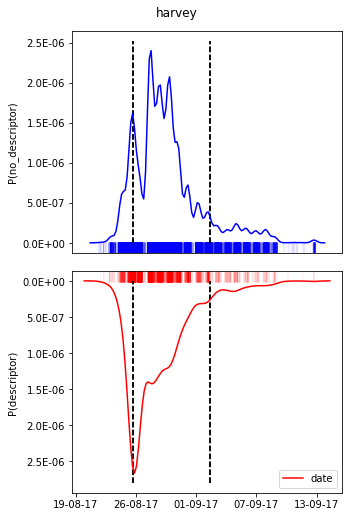

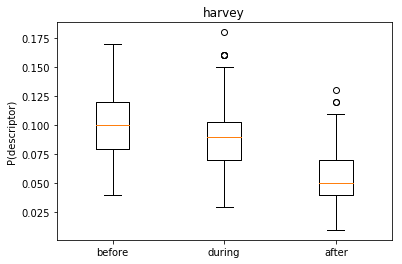

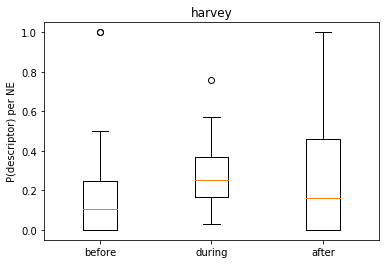

processing data irma
testing data irma
landfall: early P(has_descriptor) - late P(has_descriptor)=-0.041
landfall: diff is significant stat=-4.393 (p=0.000, N=25920)
dissipation: early P(has_descriptor) - late P(has_descriptor)=-0.023
dissipation: diff is significant stat=-3.104 (p=0.002, N=25920)
testing date period (24-08-17,05-09-17) vs. (05-09-17,12-09-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=-0.039
diff is significant stat=-4.238 (p=0.000, N=24051)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.004
diff is significant stat=-0.073 (p=0.942, N=1215)
testing date period (24-08-17,05-09-17) vs. (12-09-17,19-09-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=-0.060
diff is significant stat=-5.224 (p=0.000, N=3079)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.017
diff is significant stat=-0.244 (p=0.807, N=194)
testing date period (05-09-17,12-09-17) vs. (12-09-17,19-09-17)
unbalanced data
early P(h

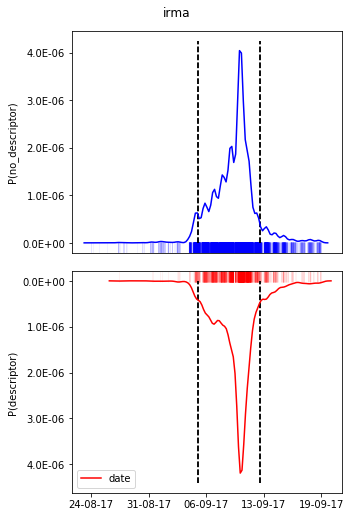

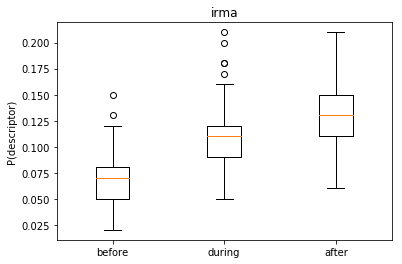

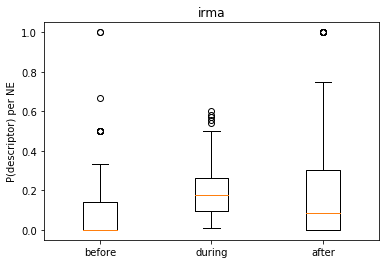

processing data maria
testing data maria
landfall: early P(has_descriptor) - late P(has_descriptor)=0.102
landfall: diff is significant stat=5.269 (p=0.000, N=5248)
dissipation: early P(has_descriptor) - late P(has_descriptor)=-0.028
dissipation: diff is significant stat=-1.961 (p=0.050, N=5248)
testing date period (29-08-17,18-09-17) vs. (18-09-17,01-10-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.105
diff is significant stat=5.495 (p=0.000, N=4740)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.211
diff is significant stat=-1.697 (p=0.090, N=163)
testing date period (29-08-17,18-09-17) vs. (01-10-17,30-10-17)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=0.072
diff is significant stat=2.609 (p=0.009, N=771)
balanced data
early P(has_descriptor) - late P(has_descriptor)=-0.185
diff is significant stat=-1.532 (p=0.126, N=38)
testing date period (18-09-17,01-10-17) vs. (01-10-17,30-10-17)
unbalanced data
early P(has_descrip

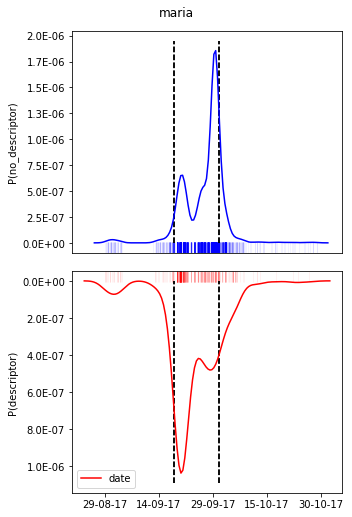

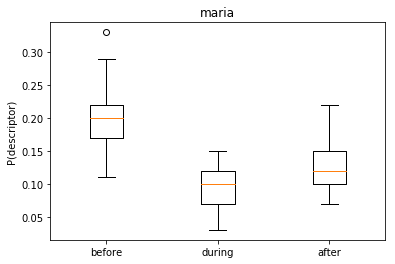

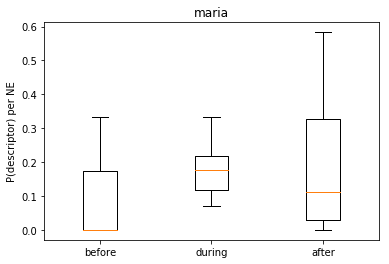

processing data michael
testing data michael
landfall: early P(has_descriptor) - late P(has_descriptor)=-0.054
landfall: diff is significant stat=-1.303 (p=0.193, N=3299)
dissipation: early P(has_descriptor) - late P(has_descriptor)=0.036
dissipation: diff is significant stat=2.081 (p=0.037, N=3299)
testing date period (06-10-18,09-10-18) vs. (09-10-18,15-10-18)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=-0.066
diff is significant stat=-1.551 (p=0.121, N=2353)
balanced data
early P(has_descriptor) - late P(has_descriptor)=0.037
diff is significant stat=0.218 (p=0.827, N=165)
testing date period (06-10-18,09-10-18) vs. (15-10-18,23-10-18)
unbalanced data
early P(has_descriptor) - late P(has_descriptor)=-0.027
diff is significant stat=-0.644 (p=0.520, N=1064)
balanced data
early P(has_descriptor) - late P(has_descriptor)=0.059
diff is significant stat=0.345 (p=0.730, N=103)
testing date period (09-10-18,15-10-18) vs. (15-10-18,23-10-18)
unbalanced data
early P(has_d

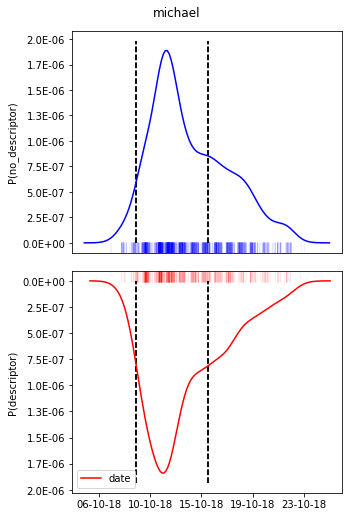

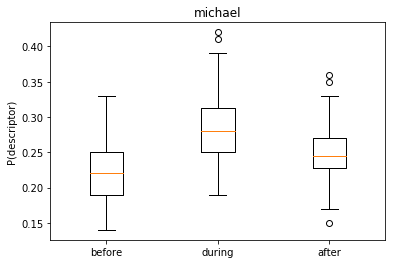

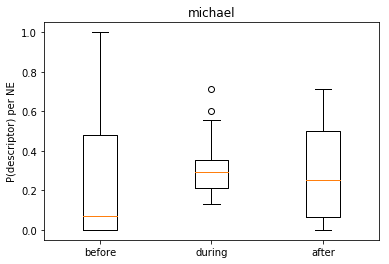

In [125]:
from statsmodels.stats.proportion import proportions_ztest
from itertools import product
from matplotlib.ticker import FormatStrFormatter
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_freq_NEs
def proportion_date_period_test(data, period_1, period_2, dep_var='has_descriptor', date_var='date'):
    data_1 = data[(data.loc[:, date_var] >= period_1[0]) & (data.loc[:, date_var] < period_1[1])]
    data_2 = data[(data.loc[:, date_var] >= period_2[0]) & (data.loc[:, date_var] < period_2[1])]
    prob_1 = data_1.loc[:, dep_var].sum() / data_1.shape[0]
    prob_2 = data_2.loc[:, dep_var].sum() / data_2.shape[0]
    N_1_2 = data_1.shape[0] + data_2.shape[0]
    print('early P(%s) - late P(%s)=%.3f'%(dep_var, dep_var, prob_1 - prob_2))
    test_stat, p_val = proportions_ztest([data_1.loc[:, dep_var].sum(), data_2.loc[:, dep_var].sum()],
                                         [data_1.shape[0], data_2.shape[0]])
    print('diff is significant stat=%.3f (p=%.3f, N=%d)'%(test_stat, p_val, N_1_2))
    return test_stat, p_val
np.random.seed(123)
dep_var = 'has_descriptor'
split_date_types = ['landfall', 'dissipation']
period_names = ['before', 'during', 'after']
date_fmt = '%m-%d-%y'
N_bootstrap = 100
bootstrap_size = 100
NE_min_count = 5
for data_name_i, data_i in combined_tag_data_valid_loc.groupby('data_name_fixed'):
    print('processing data %s'%(data_name_i))
    print('testing data %s'%(data_name_i))
    freq_NEs_i = extract_freq_NEs(data_i, min_count_0=NE_min_count, min_count_1=NE_min_count)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    # balanced = same number of samples for each NE
    data_i_k_balanced = pd.concat([x.loc[np.random.choice(x.index, NE_min_count*2, replace=False), :] for i, x in data_i_k.groupby('NE_fixed')])
#     data_i_k = data_i.copy()
    data_i_start_date = data_i.loc[:, 'date'].min()
    data_i_end_date = data_i.loc[:, 'date'].max()
    # get split dates (landfall, dissipation)
    split_dates = [event_dates[(event_dates.loc[:, 'hurricane_type']==x) & (event_dates.loc[:, 'data_name_fixed']==data_name_i)].loc[:, 'hurricane_date'].iloc[0].timestamp() for x in split_date_types]
    # compare all split types
    for split_date_type in split_date_types:
        split_date_i = event_dates[(event_dates.loc[:, 'hurricane_type']==split_date_type) & (event_dates.loc[:, 'data_name_fixed']==data_name_i)].loc[:, 'hurricane_date'].iloc[0].timestamp()
        data_i_k_early = data_i_k[data_i_k.loc[:, 'date'] < split_date_i]
        data_i_k_late = data_i_k[data_i_k.loc[:, 'date'] >= split_date_i]
        prob_early = data_i_k_early.loc[:, dep_var].sum() / data_i_k_early.shape[0]
        prob_late = data_i_k_late.loc[:, dep_var].sum() / data_i_k_late.shape[0]
        print('%s: early P(%s) - late P(%s)=%.3f'%(split_date_type, dep_var, dep_var, prob_early - prob_late))
        test_stat, p_val = proportions_ztest([data_i_k_early.loc[:, dep_var].sum(), data_i_k_late.loc[:, dep_var].sum()],
                                             [data_i_k_early.shape[0], data_i_k_late.shape[0]])
        print('%s: diff is significant stat=%.3f (p=%.3f, N=%d)'%(split_date_type, test_stat, p_val, data_i_k.shape[0]))
    # compare all period combos
    # same relative order: early vs. late
    split_dates_all = [data_i_start_date,] + split_dates + [data_i_end_date,]
    date_periods = [[x,y] for x,y in zip(split_dates_all[:-1], split_dates_all[1:])]
    for m, date_period_m in enumerate(date_periods[:-1]):
        date_period_m_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in date_period_m]
        for n, date_period_n in enumerate(date_periods[m+1:]):
            date_period_n_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in date_period_n]
            print('testing date period (%s,%s) vs. (%s,%s)'%
                  (date_period_m_str[0], date_period_m_str[1], date_period_n_str[0], date_period_n_str[1]))
            print('unbalanced data')
            proportion_date_period_test(data_i_k, date_period_m, date_period_n, dep_var=dep_var, date_var='date')
            ## same thing but equal weight for each NE
            print('balanced data')
            proportion_date_period_test(data_i_k_balanced, date_period_m, date_period_n, dep_var=dep_var, date_var='date')
            
            
    ## density plot with split dates
    data_i_k_dep = data_i_k[data_i_k.loc[:, dep_var]==1]
    data_i_k_no_dep = data_i_k[data_i_k.loc[:, dep_var]==0]
    X = np.linspace(data_i_start_date, data_i_end_date, N_date_ticks)
    date_fmt = '%d-%m-%y'
    X_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in X]
    N_bins = (datetime.fromtimestamp(X[-1]) - datetime.fromtimestamp(X[0])).days
    ## make upward and inverted plots
    f, axs = plt.subplots(2, 1, figsize=(5, 7))
    ax_1, ax_2 = axs
    ax_1.yaxis.set_major_formatter(FormatStrFormatter('%.1E'))
    ax_2.yaxis.set_major_formatter(FormatStrFormatter('%.1E'))
    # overlaid displots
#     sns.distplot(data_i_k_no_dep.loc[:, 'date'], rug=True, hist=False, bins=N_bins, label='not_with_descriptor', kde_kws={'color':'b'}, rug_kws={'color':'b', 'alpha':0.05}, ax=ax_1)
#     sns.distplot(data_i_k_dep.loc[:, 'date'], rug=True, hist=False, bins=N_bins, label='with_descriptor', kde_kws={'color':'r'}, rug_kws={'color':'r', 'alpha':0.05}, ax=ax_2)
    # up/down plots
    sns.distplot(data_i_k_no_dep.loc[:, 'date'], rug=True, hist=False, kde_kws={'color':'b'}, rug_kws={'color':'b', 'alpha':0.05}, ax=ax_1)
    sns.kdeplot(data_i_k_dep.loc[:, 'date'], color='r', ax=ax_2, label=None)
    rugplot_2(data_i_k_dep.loc[:, 'date'], color='r', height=0.05, alpha=0.05, ax=ax_2, label=None, invert=True)
    ax_2.invert_yaxis()
#     kdeplot_2.invert_yaxis()
#     rugplot_2.invert_yaxis()
#     sns.distplot(data_i_k_dep.loc[:, 'date'], rug=True, hist=False, kde_kws={'color':'r'}, rug_kws={'color':'r', 'alpha':0.05}, ax=ax_2)
    # set same xlim
    ax_1_xlim = ax_1.get_xlim()
    ax_2_xlim = ax_2.get_xlim()
    xlim = (min(ax_1_xlim[0], ax_2_xlim[0]), max(ax_1_xlim[1], ax_2_xlim[1]))
    ax_1.set_xlim(xlim)
    ax_2.set_xlim(xlim)
    # add vlines for split dates
    ax_1_ylim = ax_1.get_ylim()
    ax_2_ylim = ax_2.get_ylim()
    for split_date_type in split_date_types:
        split_date_i = event_dates[(event_dates.loc[:, 'hurricane_type']==split_date_type) & (event_dates.loc[:, 'data_name_fixed']==data_name_i)].loc[:, 'hurricane_date'].iloc[0].timestamp()
        ax_1.vlines([split_date_i, split_date_i], ymin=ax_1_ylim[0], ymax=ax_1_ylim[1], linestyle='--')
        ax_2.vlines([split_date_i, split_date_i], ymin=ax_2_ylim[0], ymax=ax_2_ylim[1], linestyle='--')
    ax_1.set_ylabel('P(no_descriptor)')
    ax_2.set_ylabel('P(descriptor)')
    ax_2.set_xticks(X)
    ax_2.set_xticklabels(X_str)
    ax_1.set_xlabel('')
    ax_1.get_xaxis().set_visible(False)
    plt.suptitle(data_name_i, y=1.02)
    plt.tight_layout()
    plt.show()
    
    ## P(descriptor) boxplot for each period
    boxplot_vals = []
    for m, date_period_m in enumerate(date_periods):
        data_m = data_i_k[(data_i_k.loc[:, 'date'] >= date_period_m[0]) & (data_i_k.loc[:, 'date'] < date_period_m[1])]
        data_m_samples = [data_m.loc[np.random.choice(data_m.index, size=bootstrap_size, replace=True), :] for _ in range(N_bootstrap)]
        data_m_means = [s.loc[:, dep_var].sum() / bootstrap_size for s in data_m_samples]
        boxplot_vals.append(data_m_means)
    plt.boxplot(boxplot_vals)
    X_boxplot = np.arange(len(date_periods))+1.
    plt.xticks(X_boxplot, period_names)
    plt.ylabel('P(descriptor)')
    plt.title(data_name_i)
    plt.show()
    
    ## P(descriptor) boxplot for each period BUT we compute average over all NEs separately
    ## prevents results from being biased toward most frequent NEs
    boxplot_vals = []
    for m, date_period_m in enumerate(date_periods):
        data_m = data_i_k[(data_i_k.loc[:, 'date'] >= date_period_m[0]) & (data_i_k.loc[:, 'date'] < date_period_m[1])]
        data_m_samples = [data_q for NE_q, data_q in data_m.groupby('NE_fixed')]
        data_m_means = [s.loc[:, dep_var].sum() / s.shape[0] for s in data_m_samples]
        boxplot_vals.append(data_m_means)
    plt.boxplot(boxplot_vals)
    X_boxplot = np.arange(len(date_periods))+1.
    plt.xticks(X_boxplot, period_names)
    plt.ylabel('P(descriptor) per NE')
    plt.title(data_name_i)
    plt.show()

For the weighted averages `P(descriptor)` analysis (i.e. no control for individual NEs), we see the following patterns.

- Florence: more descriptor before dissipation
- Harvey: more descriptor before landfall; more descriptor before dissipation
- Irma: more descriptor before landfall
- Maria: more descriptor before landfall
- Michael: more descriptor before dissipation

We need a table for all this! 

||before vs. after landfall|before vs. after dissipation|
|---|---|---|
|Florence|+|0|
|Harvey|+|+|
|Irma|-|-|
|Maria|+|0|
|Michael|0|+|


- unbalanced freq-NE

||pre vs. mid|pre vs. after|mid vs. after|
|---|---|---|---|
|Florence|+|+|0|
|Harvey|+|+|+|
|Irma|-|-|-|
|Maria|+|0|0|
|Michael|0|0|+|

- balanced freq-NE

||pre vs. mid|pre vs. after|mid vs. after|
|---|---|---|---|
|Florence|0|0|0|
|Harvey|-|0|0|
|Irma|0|0|0|
|Maria|0|0|0|
|Michael|0|0|0|

In general, it seems that more descriptors were used in late stages as compared to early stages. This could be due to more outside interest driving more use of descriptors.

### Fixed-effect regression using split times

Now let's confirm these effects by predicting the descriptor presence based on time and add a fixed effect for each unique NE. Again we have to restrict to the most common NEs to ensure model fit.

In [188]:
display(event_dates)

data_name_fixed hurricane_date hurricane_type
0           harvey     2017-08-17           form
1           harvey     2017-08-26       landfall
2           harvey     2017-09-03    dissipation
3            maria     2017-09-16           form
4            maria     2017-09-19       landfall
5            maria     2017-10-02    dissipation
6          michael     2018-10-07           form
7          michael     2018-10-10       landfall
8          michael     2018-10-16    dissipation
9             irma     2017-08-30           form
10            irma     2017-09-06       landfall
11            irma     2017-09-13    dissipation
12        florence     2018-08-31           form
13        florence     2018-09-14       landfall
14        florence     2018-09-19    dissipation

In [190]:
# compute time after landfall, after dissipation
event_dates_pivot = event_dates.pivot(index='data_name_fixed', columns='hurricane_type', values='hurricane_date').reset_index()
combined_tag_data_valid_loc_time = pd.merge(combined_tag_data_valid_loc, event_dates_pivot, on='data_name_fixed')
combined_tag_data_valid_loc_time_ = []
time_var = 'date'
event_time_vars = ['dissipation', 'form', 'landfall']
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    date_min_i = data_i.loc[:, time_var].min()
    for x in event_time_vars:
        x_since = 'since_%s'%(x)
        data_i.loc[:, x_since] = (data_i.loc[:, time_var] - data_i.loc[:, x].apply(lambda x: x.timestamp())).apply(lambda x: max(0, x))
        # convert to days? for better interpretability
        data_i.loc[:, x_since] = data_i.loc[:, x_since] / (3600*24)
    combined_tag_data_valid_loc_time_.append(data_i)
combined_tag_data_valid_loc_time = pd.concat(combined_tag_data_valid_loc_time_, axis=0)
display(combined_tag_data_valid_loc_time.head())

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


id  \
115911  1035866919172231168   
115912  1035944899659673600   
115913  1035998456714813440   
115914  1036176030975832064   
115915  1036539345782669312   

                                                      txt data_name_fixed  \
115911  RT @WeatherNation: BREAKING - We now have Trop...        florence   
115912  RT @VinifyItaly: Wine Tasting in the center of...        florence   
115913  RT @NHC_Atlantic: Tropical Storm #Florence Adv...        florence   
115914  RT @NHC_Atlantic: Tropical Storm #Florence Adv...        florence   
115915  Tropical Storm #Florence is 2790 miles ESE of ...        florence   

              username          date lang        NE   NE_type  NE_LOC  \
115911     RallyPoint7  1.535819e+09   en  Florence  LOCATION    True   
115912          RESHBD  1.535838e+09   en  Florence  LOCATION    True   
115913      joeyjet625  1.535851e+09   en  Florence  LOCATION    True   
115914  thestormreport  1.535893e+09   en  Florence  LOCATION    True   
115915     wralweather  1.535980e+09   en   Raleigh  LOCATION    True   

        valid_loc  has_descriptor  NE_fixed dissipation       form   landfall  \
115911       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115912       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115913       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115914       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115915       True           False   raleigh  2018-09-19 2018-08-31 2018-09-14   

        since_dissipation  since_form  since_landfall  
115911                0.0    1.686262             0.0  
115912                0.0    1.901447             0.0  
115913                0.0    2.049236             0.0  
115914                0.0    2.539248             0.0  
115915                0.0    3.541806             0.0

In [191]:
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import logit
fixed_var = 'NE_fixed'
fixed_var_cat = 'C(%s)'%(fixed_var)
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
ind_vars = event_time_vars_since + [fixed_var_cat]
dep_var = 'has_descriptor'
scaler = StandardScaler()

params = []
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    freq_NEs_i = extract_freq_NEs(data_i)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    data_i_k.loc[:, dep_var] = data_i_k.loc[:, dep_var].astype(int)
    # Z-norm independent vars
    for iv in event_time_vars_since:
        data_i_k.loc[:, iv] = scaler.fit_transform(data_i_k.loc[:, iv].values.reshape(-1,1))
    print('testing %d frequent NEs'%(len(freq_NEs_i)))
#     fixed_vars_str = ['C(%s)'%(x) for x in data_i_k.loc[:, fixed_var].unique()]
    print('%s ~ %s'%(dep_var, ' + '.join(ind_vars)))
    model = logit(formula='%s ~ %s'%(dep_var, ' + '.join(ind_vars)), data=data_i_k)
    res = model.fit()
    print(res.summary())
    params.append([data_name_i, res.params])
## TODO: plot params/err for time variables

testing data florence
27 freq NEs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

testing 27 frequent NEs
has_descriptor ~ since_dissipation + since_form + since_landfall + C(NE_fixed)
Optimization terminated successfully.
         Current function value: 0.547132
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 4325
Model:                          Logit   Df Residuals:                     4295
Method:                           MLE   Df Model:                           29
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.07419
Time:                        16:08:02   Log-Likelihood:                -2366.3
converged:                       True   LL-Null:                       -2556.0
                                        LLR p-value:                 1.162e-62
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

testing 44 frequent NEs
has_descriptor ~ since_dissipation + since_form + since_landfall + C(NE_fixed)
Optimization terminated successfully.
         Current function value: 0.238048
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                54881
Model:                          Logit   Df Residuals:                    54834
Method:                           MLE   Df Model:                           46
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                  0.1777
Time:                        16:08:05   Log-Likelihood:                -13064.
converged:                       True   LL-Null:                       -15887.
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

testing 64 frequent NEs
has_descriptor ~ since_dissipation + since_form + since_landfall + C(NE_fixed)
Optimization terminated successfully.
         Current function value: 0.322149
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                21481
Model:                          Logit   Df Residuals:                    21414
Method:                           MLE   Df Model:                           66
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.08490
Time:                        16:08:06   Log-Likelihood:                -6920.1
converged:                       True   LL-Null:                       -7562.1
                                        LLR p-value:                4.225e-225
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

testing 14 frequent NEs
has_descriptor ~ since_dissipation + since_form + since_landfall + C(NE_fixed)
Optimization terminated successfully.
         Current function value: 0.302703
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 5070
Model:                          Logit   Df Residuals:                     5053
Method:                           MLE   Df Model:                           16
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.08697
Time:                        16:08:06   Log-Likelihood:                -1534.7
converged:                       True   LL-Null:                       -1680.9
                                        LLR p-value:                 9.712e-53
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


testing 13 frequent NEs
has_descriptor ~ since_dissipation + since_form + since_landfall + C(NE_fixed)
Optimization terminated successfully.
         Current function value: 0.554941
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 2991
Model:                          Logit   Df Residuals:                     2975
Method:                           MLE   Df Model:                           15
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.05201
Time:                        16:08:07   Log-Likelihood:                -1659.8
converged:                       True   LL-Null:                       -1750.9
                                        LLR p-value:                 8.879e-31
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


- Larger locations have lower P(descriptor) because of importance effect (e.g. `Houston` vs. all other NEs in `Harvey` results).
- Generally weak time effects but
    - Florence: positive `since_form`, negative `since_landfall`, weak positive `since_dissipation`
    - Harvey: positive `since_form`, negative `since_landfall`
    - Irma: weak negative `since_dissipation`
    - Maria: negative `since_landfall`, positive `since_dissipation`
    - Michael: weak positive `since_form`, weak negative `since_landfall`, positive `since_dissipation`

Cool! These effects are as expected, except for Irma for some reason. Let's plot out the probability curves for a better simulated result.

In [194]:
# collect all models for prediction
data_models = []
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    freq_NEs_i = extract_freq_NEs(data_i)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    data_i_k.loc[:, dep_var] = data_i_k.loc[:, dep_var].astype(int)
    # Z-norm independent vars
    for iv in event_time_vars_since:
        data_i_k.loc[:, iv] = scaler.fit_transform(data_i_k.loc[:, iv].values.reshape(-1,1))
    model = logit(formula='%s ~ %s'%(dep_var, ' + '.join(ind_vars)), data=data_i_k)
    res = model.fit()
    print(res.summary())
    # get fitted model
    data_models.append([data_name_i, model, res.params])

testing data florence
27 freq NEs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.547132
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 4325
Model:                          Logit   Df Residuals:                     4295
Method:                           MLE   Df Model:                           29
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.07419
Time:                        16:15:37   Log-Likelihood:                -2366.3
converged:                       True   LL-Null:                       -2556.0
                                        LLR p-value:                 1.162e-62
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2400      0.293     -0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.238048
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                54881
Model:                          Logit   Df Residuals:                    54834
Method:                           MLE   Df Model:                           46
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                  0.1777
Time:                        16:15:39   Log-Likelihood:                -13064.
converged:                       True   LL-Null:                       -15887.
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.3230      0.133     -9.971  

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Optimization terminated successfully.
         Current function value: 0.322149
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                21481
Model:                          Logit   Df Residuals:                    21414
Method:                           MLE   Df Model:                           66
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.08490
Time:                        16:15:39   Log-Likelihood:                -6920.1
converged:                       True   LL-Null:                       -7562.1
                                        LLR p-value:                4.225e-225
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.9156      0.115    -25

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.302703
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 5070
Model:                          Logit   Df Residuals:                     5053
Method:                           MLE   Df Model:                           16
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.08697
Time:                        16:15:40   Log-Likelihood:                -1534.7
converged:                       True   LL-Null:                       -1680.9
                                        LLR p-value:                 9.712e-53
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.8462      0.275     -6.703      0.000      -2.386   

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.554941
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 2991
Model:                          Logit   Df Residuals:                     2975
Method:                           MLE   Df Model:                           15
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.05201
Time:                        16:15:41   Log-Likelihood:                -1659.8
converged:                       True   LL-Null:                       -1750.9
                                        LLR p-value:                 8.879e-31
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.8012      0.169    -10.63

testing data florence
26 freq NEs
start/end 2018-08-30 20:00:00 - 2018-09-25 14:35:11
testing NE wilmington


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


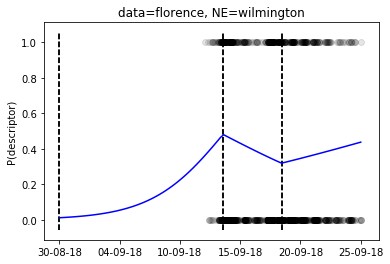

testing NE florence
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


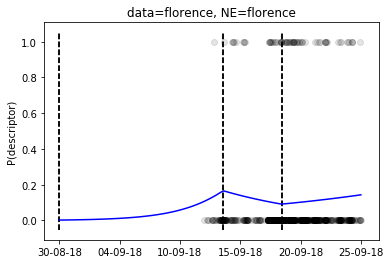

testing NE carolina
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


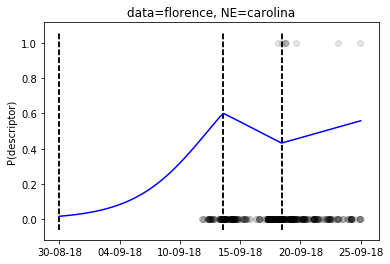

testing NE myrtle_beach
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


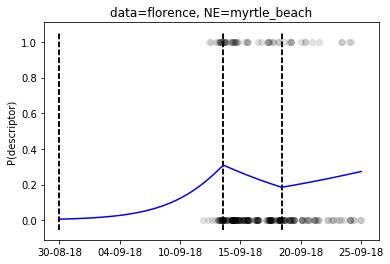

testing NE raleigh
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


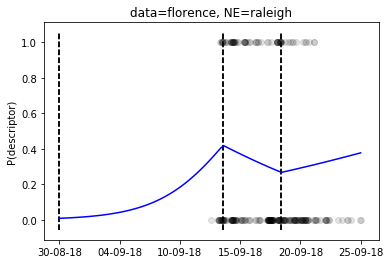

testing NE conway
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


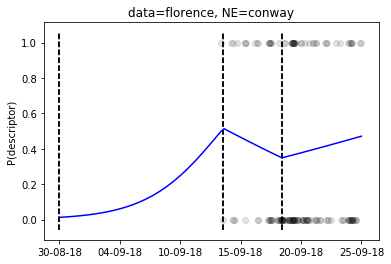

testing NE charleston
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


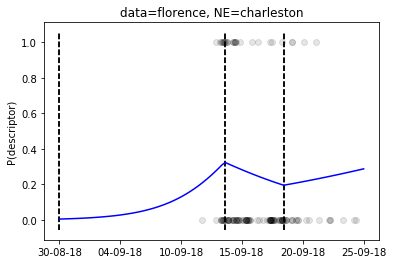

testing NE wrightsville_beach
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


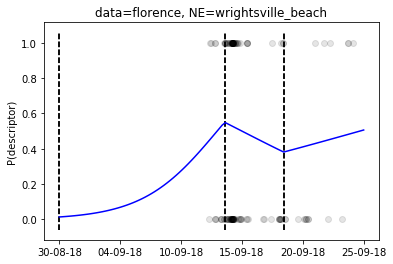

testing NE jacksonville
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


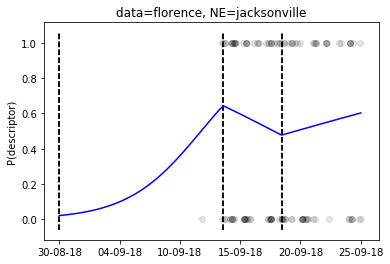

testing NE morehead_city
adding dissipation event at 2018-09-18 20:00:00
adding form event at 2018-08-30 20:00:00
adding landfall event at 2018-09-13 20:00:00


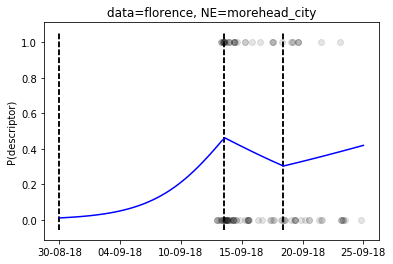

testing data harvey
44 freq NEs
start/end 2017-08-16 20:00:00 - 2017-09-08 06:52:42
testing NE houston
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


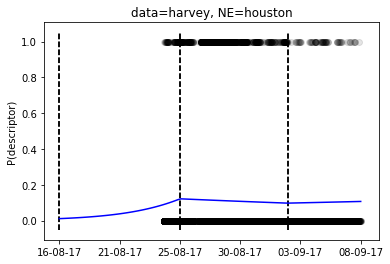

testing NE corpus_christi
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


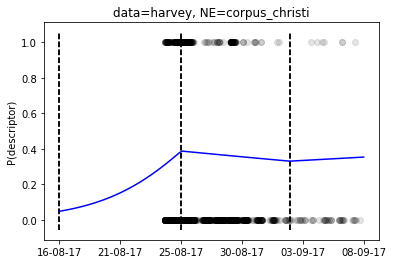

testing NE rockport
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


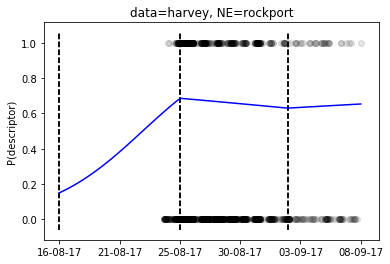

testing NE austin
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


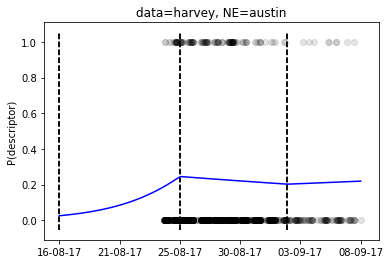

testing NE dallas
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


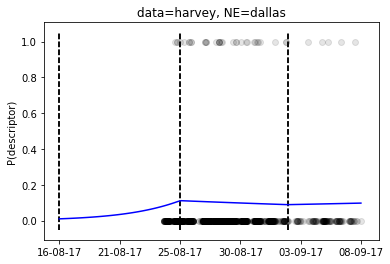

testing NE galveston
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


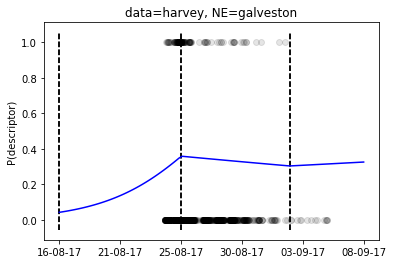

testing NE port_aransas
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


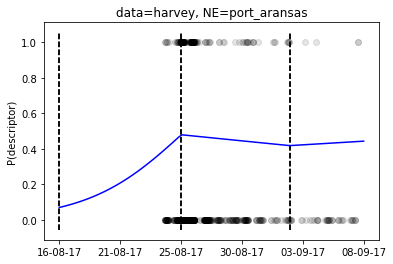

testing NE port_arthur
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


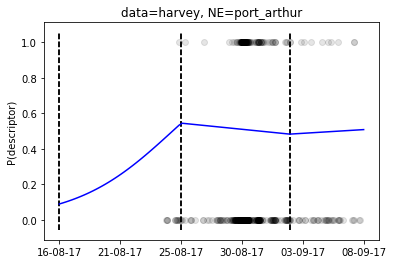

testing NE harris_county
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


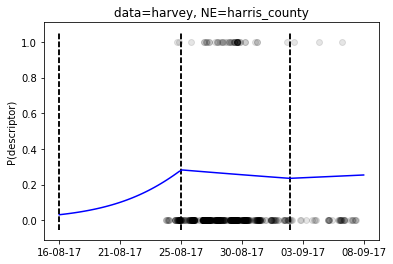

testing NE dickinson
adding dissipation event at 2017-09-02 20:00:00
adding form event at 2017-08-16 20:00:00
adding landfall event at 2017-08-25 20:00:00


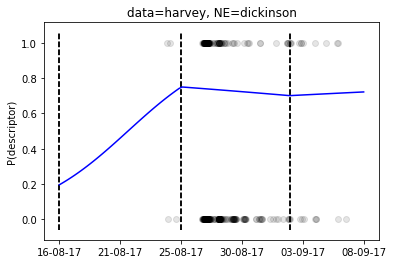

testing data irma
63 freq NEs
start/end 2017-08-29 20:00:00 - 2017-09-16 09:28:16
testing NE tampa
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


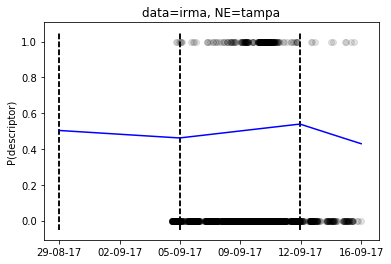

testing NE marco_island
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


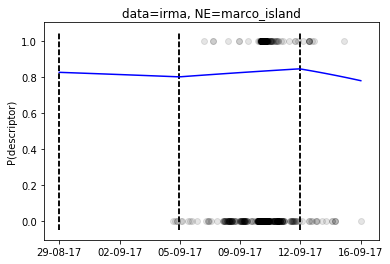

testing NE atlanta
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


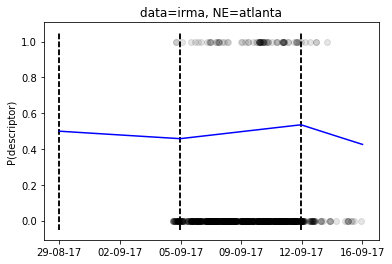

testing NE jacksonville
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


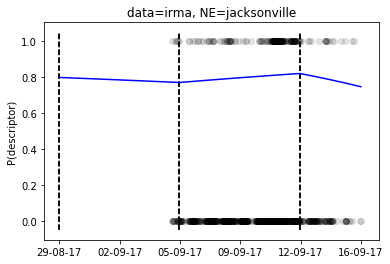

testing NE miami_beach
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


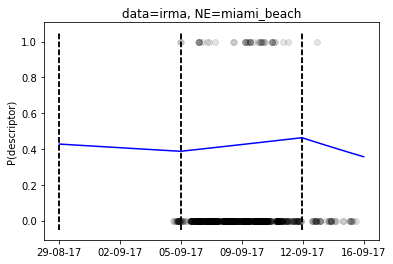

testing NE houston
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


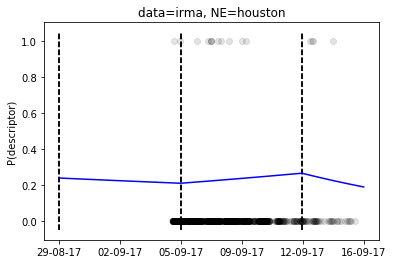

testing NE charleston
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


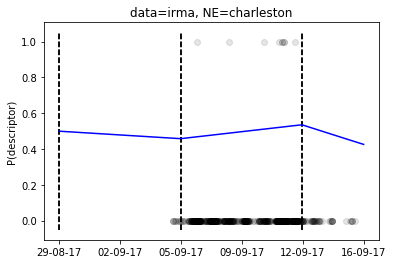

testing NE anguilla
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


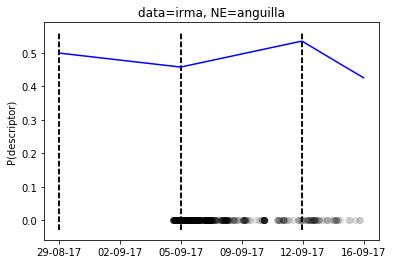

testing NE sarasota
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


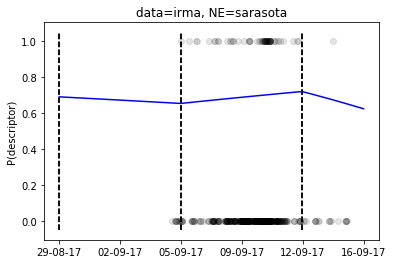

testing NE palm_beach
adding dissipation event at 2017-09-12 20:00:00
adding form event at 2017-08-29 20:00:00
adding landfall event at 2017-09-05 20:00:00


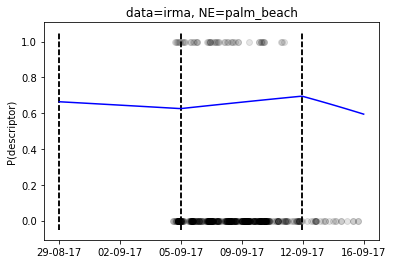

testing data maria
13 freq NEs
start/end 2017-09-13 18:01:00 - 2017-10-07 12:51:52
testing NE san_juan
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


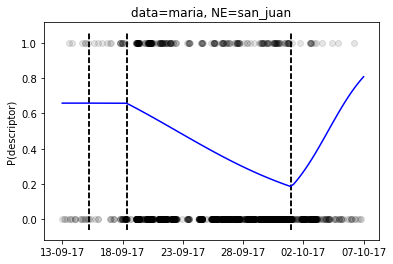

testing NE vieques
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


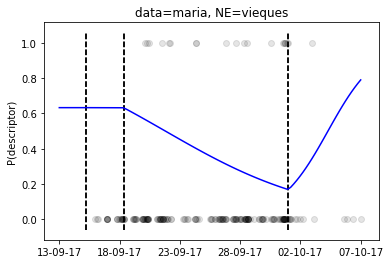

testing NE ponce
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


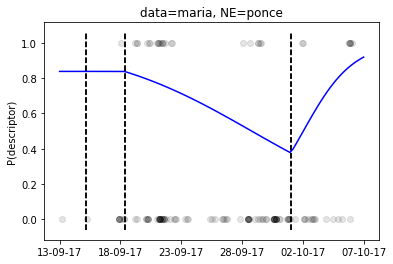

testing NE carolina
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


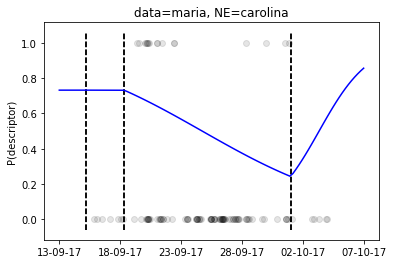

testing NE guaynabo
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


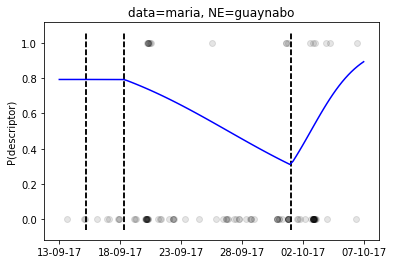

testing NE caguas
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


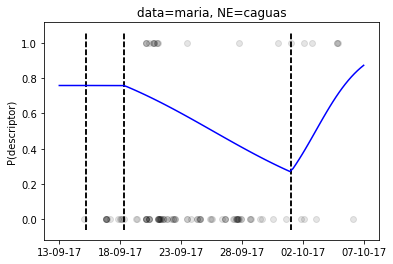

testing NE utuado
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


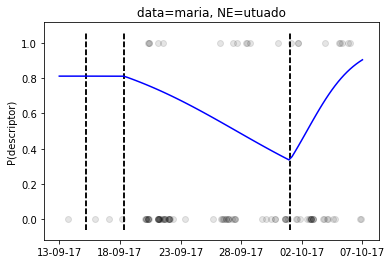

testing NE yabucoa
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


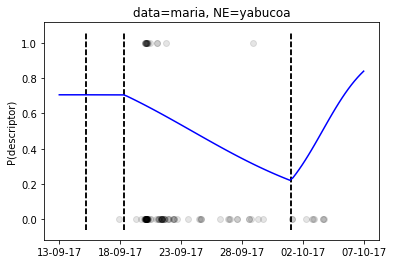

testing NE aguadilla
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


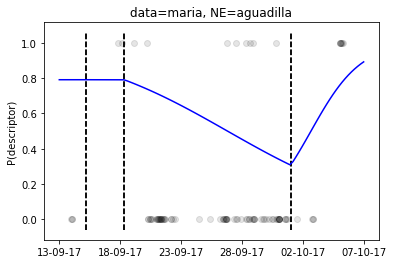

testing NE las_vegas
adding dissipation event at 2017-10-01 20:00:00
adding form event at 2017-09-15 20:00:00
adding landfall event at 2017-09-18 20:00:00


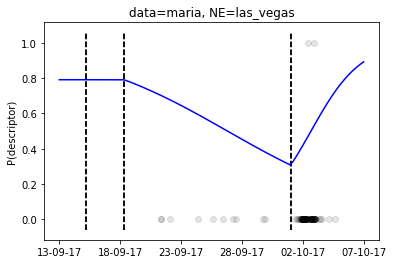

testing data michael
13 freq NEs
start/end 2018-10-06 20:00:00 - 2018-10-22 12:58:35
testing NE mexico_beach
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


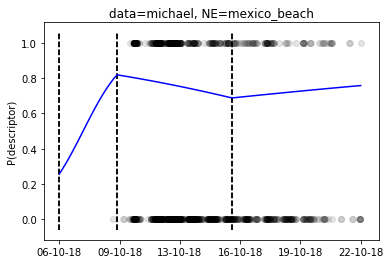

testing NE panhandle
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


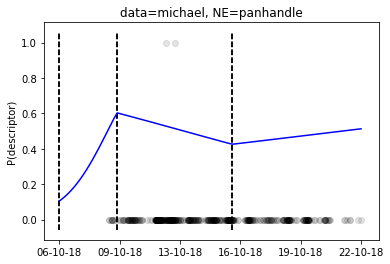

testing NE tallahassee
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


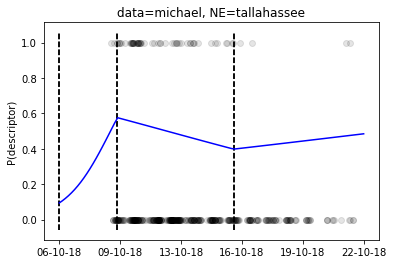

testing NE panama_city_beach
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


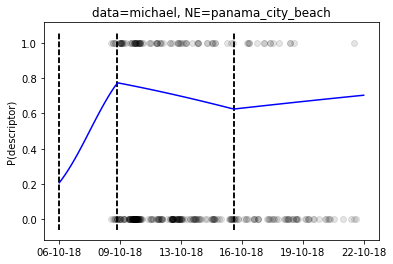

testing NE bay_county
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


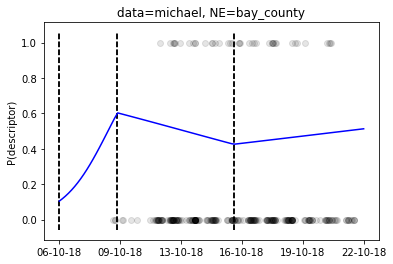

testing NE lynn_haven
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


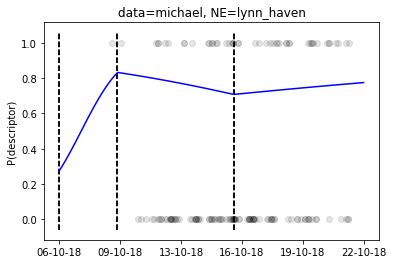

testing NE marianna
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


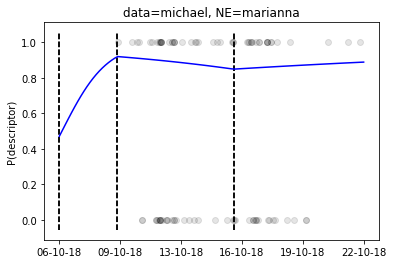

testing NE gulf_county
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


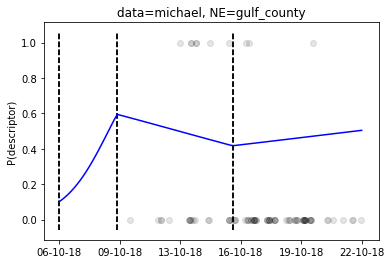

testing NE gulf
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


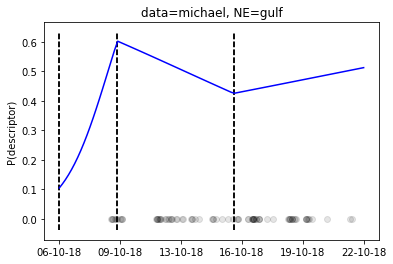

testing NE bay
adding dissipation event at 2018-10-15 20:00:00
adding form event at 2018-10-06 20:00:00
adding landfall event at 2018-10-09 20:00:00


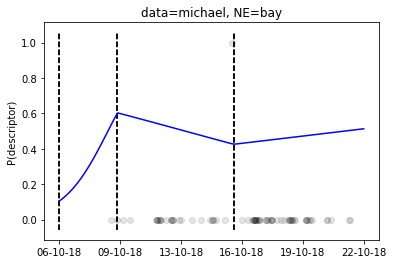

In [230]:
N_time_bins = 100
top_k_NEs = 10
date_fmt = '%d-%m-%y'
N_ticks = 6
NE_var = 'NE_fixed'
for data_name_i, model, params in data_models:
    print('testing data %s'%(data_name_i))
    data_i = combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, 'data_name_fixed']==data_name_i]
    ## get rid of time outliers??
    data_i = data_i[(data_i.loc[:, 'date'] >= np.percentile(data_i.loc[:, 'date'], 2)) & 
                    (data_i.loc[:, 'date'] <= np.percentile(data_i.loc[:, 'date'], 98))]
    time_vals_valid_i = data_i.loc[:, time_var].values
    freq_NEs_i = extract_freq_NEs(data_i)
    data_i_k = data_i[data_i.loc[:, NE_var].isin(freq_NEs_i)]
    data_i_k.loc[:, dep_var] = data_i_k.loc[:, dep_var].astype(int)
    
    ## generate simulated time data
    start_time = min(data_i_k.loc[:, time_var].min(), data_i_k.loc[:, event_time_vars].iloc[0, :].min().timestamp())
    end_time = max(data_i_k.loc[:, time_var].max(), data_i_k.loc[:, event_time_vars].iloc[0, :].max().timestamp())
    print('start/end %s - %s'%(datetime.fromtimestamp(start_time), datetime.fromtimestamp(end_time)))
    time_sim_vals = np.linspace(start_time, end_time, N_time_bins)
    time_sim = pd.DataFrame(pd.Series(time_sim_vals), columns=['sim_time'])
    # convert time to relative time
    for etv in event_time_vars:
        since_etv = 'since_%s'%(etv)
        event_time = data_i.loc[:, etv].iloc[0].timestamp()
        time_sim.loc[:, since_etv] = (time_sim.loc[:, 'sim_time'] - event_time).apply(lambda x: max(x, 0))
        # convert to days
        time_sim.loc[:, since_etv] = time_sim.loc[:, since_etv].apply(lambda x: x/(3600*24))
        # Z-norm data
        iv_mean = data_i_k.loc[:, since_etv].mean()
        iv_sd = data_i_k.loc[:, since_etv].std()
        time_sim.loc[:, since_etv] = (time_sim.loc[:, since_etv] - iv_mean) / iv_sd
    
    ## predict!! for the most frequent NEs
    time_sim = time_sim.loc[:, params.index].fillna(0, inplace=False)
    # add intercept?
    time_sim.loc[:, 'Intercept'] = 0
#     display(time_sim.head())
    NE_counts_i = data_i.loc[:, NE_var].value_counts().sort_values(inplace=False, ascending=False)
    x_ticks = np.linspace(start_time, end_time, N_ticks)
    time_vals_valid_start = min(min(time_vals_valid_i), data_i_k.loc[:, event_time_vars].iloc[0, :].min().timestamp())
    time_vals_valid_end = max(max(time_vals_valid_i), data_i_k.loc[:, event_time_vars].iloc[0, :].max().timestamp())
    x_ticks_valid = np.linspace(time_vals_valid_start, time_vals_valid_end, N_ticks)
    x_ticks_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in x_ticks_valid]
    for k in range(top_k_NEs):
        NE_k = NE_counts_i.index[k]
        print('testing NE %s'%(NE_k))
        NE_k_str = 'C(NE_fixed)[T.%s]'%(NE_k)
        if(NE_k_str in time_sim.columns):
            time_sim.loc[:, NE_k_str] = 1
        # compute probs
        probs = model.predict(params, time_sim)
        # reset
        if(NE_k_str in time_sim.columns):
            time_sim.loc[:, NE_k_str] = 0
        # plot line for predicted probability
        plt.plot(time_sim_vals, probs, color='b', linestyle='-')
        plt.xticks(x_ticks, x_ticks_str)
        # scatter actual values
        data_i_NE = data_i[data_i.loc[:, NE_var]==NE_k]
        plt.scatter(data_i_NE.loc[:, time_var], data_i_NE.loc[:, dep_var], marker='o', color='k', alpha=0.1)
        plt.title('data=%s, NE=%s'%(data_name_i, NE_k))
        # add vlines for event times
        y_min, y_max = plt.ylim()
        for etv in event_time_vars:
            event_time = data_i.loc[:, etv].iloc[0].timestamp()
            print('adding %s event at %s'%(etv, datetime.fromtimestamp(event_time)))
            plt.vlines([event_time, event_time], ymin=y_min, ymax=y_max, color='k', linestyle='--')
        # add horizontal line for random chance
#         dep_var_chance = data_i_k_NE.loc[:, dep_var].sum() / data_i_k_NE.shape[0]
#         x_min, x_max = plt.xlim()
#         plt.plot([x_min, x_max], [dep_var_chance, dep_var_chance], color='r', linestyle='-.')
        plt.ylabel('P(descriptor)')
        plt.show()

### Fixed effect regression: entity importance + time
Let's try to generalize the fixed effects by using importance variables, i.e. `max_pop` and `max_names`. We'll log-transform and then bin them to come up with more general estimates.

- H0: Controlling for entity importance produces the same effect as controlling for entity type.

In [305]:
# load mapping of name :: GeoNames references
import pickle
import pandas as pd
geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))

In [306]:
max_pops = pd.Series({k : v.loc[:, 'population'].max() for k,v in geo_dict.items()})
max_names = pd.Series({k : v.loc[:, 'alternate_name_count'].max() for k,v in geo_dict.items()})

In [311]:
# add to data 
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_pop=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_pops.loc[x.replace('_', ' ')]))
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_names=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_names.loc[x.replace('_', ' ')]))

In [328]:
# log/bin variables
N_bins = 4
importance_stats = ['max_pop', 'max_names']
combined_tag_data_importance = []
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    data_i_dedup = data_i.drop_duplicates('NE_fixed')
    for importance_stat in importance_stats:
        importance_stat_vals = np.log(data_i_dedup.loc[:, importance_stat]+1.)
        importance_stat_bins = np.linspace(importance_stat_vals.min(), importance_stat_vals.max(), N_bins+1)[1:]
        importance_stat_bin_vals = pd.DataFrame(np.digitize(importance_stat_vals, bins=importance_stat_bins), columns=['%s_bin'%(importance_stat)])
        importance_stat_bin_vals.loc[:, 'NE_fixed'] = data_i_dedup.loc[:, 'NE_fixed'].values
        data_i = pd.merge(data_i, importance_stat_bin_vals, on='NE_fixed')
    combined_tag_data_importance.append(data_i)
combined_tag_data_importance = pd.concat(combined_tag_data_importance, axis=0)

In [372]:
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import logit
def run_regression(data, fixed_var='NE_fixed', ind_vars=['since_form', 'since_landfall', 'since_dissipation'], dep_var='has_descriptor', data_group_var='data_name_fixed', use_freq_NE_data=True):
    if(fixed_var != ''):
        fixed_var_cat = 'C(%s)'%(fixed_var)
        ind_vars = [fixed_var_cat] + ind_vars
    scaler = StandardScaler()
    params = []
    for data_name_i, data_i in data.groupby(data_group_var):
        print('testing data %s'%(data_name_i))
        if(use_freq_NE_data):
            freq_NEs_i = extract_freq_NEs(data_i)
            data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
        else:
            data_i_k = data_i.copy()
        data_i_k.loc[:, dep_var] = data_i_k.loc[:, dep_var].astype(int)
        # Z-norm independent vars
        for iv in event_time_vars_since:
            data_i_k.loc[:, iv] = scaler.fit_transform(data_i_k.loc[:, iv].values.reshape(-1,1))
#         print('testing %d frequent NEs'%(len(freq_NEs_i)))
        #     fixed_vars_str = ['C(%s)'%(x) for x in data_i_k.loc[:, fixed_var].unique()]
        model = logit(formula='%s ~ %s'%(dep_var, ' + '.join(ind_vars)), data=data_i_k)
        res = model.fit()
        print(res.summary())
        params.append([data_name_i, model, res.params])
    ## TODO: plot params/err for all models
    return params

In [345]:
# same regression as above but with bin as ind var
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import logit
# fixed_var = 'NE_fixed'
fixed_var = ''
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
data_group_var = 'data_name_fixed'
dep_var = 'has_descriptor'
importance_stats = ['max_pop', 'max_names']
importance_vars = ['%s_bin'%(x) for x in importance_stats]
# add interaction
importance_vars += ['max_pop_bin']
# run as categorical?? 
# running individually produces insignificant results
# running together causes negative results
# importance_vars = ['C(%s)'%(x) for x in importance_vars]
ind_vars = importance_vars + event_time_vars_since
params = run_regression(combined_tag_data_importance, fixed_var=fixed_var, ind_vars=ind_vars, dep_var=dep_var, data_group_var=data_group_var, use_freq_NE_data=False)

testing data florence
Optimization terminated successfully.
         Current function value: 0.511089
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 8364
Model:                          Logit   Df Residuals:                     8357
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.02748
Time:                        12:07:46   Log-Likelihood:                -4274.7
converged:                       True   LL-Null:                       -4395.5
                                        LLR p-value:                 2.576e-49
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.6984      0.109    -15.6

In [352]:
# importance stats => categorical
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import logit
fixed_var = ''
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
data_group_var = 'data_name_fixed'
dep_var = 'has_descriptor'
importance_stats = ['max_pop']
for importance_stat in importance_stats:
    print('testing stat %s'%(importance_stat))
    importance_vars = ['%s_bin'%(importance_stat)]
    # run as categorical?? 
    # running individually produces insignificant results
    # running together causes negative results
    importance_vars = ['C(%s)'%(x) for x in importance_vars]
    ind_vars = importance_vars + event_time_vars_since
    # test: remove max pop outliers
    combined_tag_data_importance = combined_tag_data_importance[combined_tag_data_importance.loc[:, '%s_bin'%(importance_stat)] < combined_tag_data_importance.loc[:, '%s_bin'%(importance_stat)].max()]
    params = run_regression(combined_tag_data_importance, fixed_var=fixed_var, ind_vars=ind_vars, dep_var=dep_var, data_group_var=data_group_var, use_freq_NE_data=False)

testing stat max_pop
testing data florence
Optimization terminated successfully.
         Current function value: 0.507421
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 8362
Model:                          Logit   Df Residuals:                     8355
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.03458
Time:                        12:28:20   Log-Likelihood:                -4243.1
converged:                       True   LL-Null:                       -4395.0
                                        LLR p-value:                 1.145e-62
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.1258      0.143    -1

In [333]:
## TIL: mixing fixed effects with control variables is not good when controls are highly correlated with effects
fixed_var = 'NE_fixed'
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
data_group_var = 'data_name_fixed'
dep_var = 'has_descriptor'
importance_stats = ['max_pop', 'max_names']
importance_vars = ['%s_bin'%(x) for x in importance_stats]
ind_vars = importance_vars + event_time_vars_since
params = run_regression(combined_tag_data_importance, fixed_var=fixed_var, ind_vars=ind_vars, dep_var=dep_var, data_group_var=data_group_var)

testing data florence
27 freq NEs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.547132
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 4325
Model:                          Logit   Df Residuals:                     4295
Method:                           MLE   Df Model:                           29
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.07419
Time:                        11:08:47   Log-Likelihood:                -2366.3
converged:                       True   LL-Null:                       -2556.0
                                        LLR p-value:                 1.162e-62
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1498        nan       

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


44 freq NEs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.238048
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                54881
Model:                          Logit   Df Residuals:                    54834
Method:                           MLE   Df Model:                           46
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                  0.1777
Time:                        11:08:51   Log-Likelihood:                -13064.
converged:                       True   LL-Null:                       -15887.
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.5027        nan        nan  

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


64 freq NEs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Optimization terminated successfully.
         Current function value: 0.322149
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                21481
Model:                          Logit   Df Residuals:                    21414
Method:                           MLE   Df Model:                           66
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.08490
Time:                        11:08:54   Log-Likelihood:                -6920.1
converged:                       True   LL-Null:                       -7562.1
                                        LLR p-value:                4.225e-225
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1286        nan       

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Optimization terminated successfully.
         Current function value: 0.302703
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 5070
Model:                          Logit   Df Residuals:                     5053
Method:                           MLE   Df Model:                           16
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.08697
Time:                        11:08:57   Log-Likelihood:                -1534.7
converged:                       True   LL-Null:                       -1680.9
                                        LLR p-value:                 9.712e-53
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.5436   1.51e+06  -3.61e-07      1.000   -2.95e+06  

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Optimization terminated successfully.
         Current function value: 0.554941
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 2991
Model:                          Logit   Df Residuals:                     2975
Method:                           MLE   Df Model:                           15
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.05201
Time:                        11:09:00   Log-Likelihood:                -1659.8
converged:                       True   LL-Null:                       -1750.9
                                        LLR p-value:                 8.879e-31
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1987   4.05e+06   4.91e-0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x

In [361]:
# combined regression!
fixed_var = ''
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
# data_group_var = 'data_name_fixed'
data_group_var = 'complete'
dep_var = 'has_descriptor'
importance_stats = ['max_pop', 'max_names']
importance_vars = ['%s_bin'%(x) for x in importance_stats]
# add interaction??
importance_vars += ['max_pop_bin*max_names_bin']
ind_vars = importance_vars + event_time_vars_since + ['C(data_name_fixed)']
# add dummy var for group
combined_tag_data_importance_ = combined_tag_data_importance.copy()
combined_tag_data_importance_.loc[:, data_group_var] = 1
# filter bad NEs
bad_NEs = ['hurricane',] + list(combined_tag_data_importance_.loc[:, 'data_name_fixed'].unique())
combined_tag_data_importance_ = combined_tag_data_importance_[~combined_tag_data_importance_.loc[:, 'NE_fixed'].isin(bad_NEs)]
complete_model_params = run_regression(combined_tag_data_importance_, fixed_var=fixed_var, ind_vars=ind_vars, dep_var=dep_var, data_group_var=data_group_var, use_freq_NE_data=False)

testing data 1
Optimization terminated successfully.
         Current function value: 0.304133
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:               128619
Model:                          Logit   Df Residuals:                   128608
Method:                           MLE   Df Model:                           10
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.06064
Time:                        13:06:26   Log-Likelihood:                -39117.
converged:                       True   LL-Null:                       -41643.
                                        LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.1785      0.204    

OK! We find that `max_pop_bin` and `max_names_bin` often have conflicting effects, but when we treat them as categorical variables then we find slightly more consistency.

Let's plot out the predictions vs. actual values in the same way as before.

In [424]:
from itertools import cycle
from math import ceil
def plot_sim_data(data, model, params, ind_var='max_pop_bin', N_time_bins=100, date_fmt='%d-%m-%y', N_ticks=6, time_var='date', event_time_vars=['form', 'landfall', 'dissipation']):
    """
    Simulate time data and predict probabilities at different
    timesteps. 
    Plot the probability trajectory across different sub-values
    for ind_var.
    """
    np.random.seed(123)
    ## get rid of time outliers??
    data = data[(data.loc[:, time_var] >= np.percentile(data.loc[:, time_var], 2)) & 
                    (data.loc[:, time_var] <= np.percentile(data.loc[:, time_var], 98))]
    time_vals_valid = data.loc[:, time_var].values
    data.loc[:, dep_var] = data.loc[:, dep_var].astype(int)
    
    ## generate simulated time data
    start_time = min(data.loc[:, time_var].min(), data.loc[:, event_time_vars].iloc[0, :].min().timestamp())
    end_time = max(data.loc[:, time_var].max(), data.loc[:, event_time_vars].iloc[0, :].max().timestamp())
#     print('start/end %s - %s'%(datetime.fromtimestamp(start_time), datetime.fromtimestamp(end_time)))
    time_sim_vals = np.linspace(start_time, end_time, N_time_bins)
    time_sim = pd.DataFrame(pd.Series(time_sim_vals), columns=['sim_time'])
    # convert time to relative time (since_landfall, etc.)
    for etv in event_time_vars:
        since_etv = 'since_%s'%(etv)
        event_time = data.loc[:, etv].iloc[0].timestamp()
        time_sim.loc[:, since_etv] = (time_sim.loc[:, 'sim_time'] - event_time).apply(lambda x: max(x, 0))
        # convert to days
        time_sim.loc[:, since_etv] = time_sim.loc[:, since_etv].apply(lambda x: x/(3600*24))
        # Z-norm data
        iv_mean = data.loc[:, since_etv].mean()
        iv_sd = data.loc[:, since_etv].std()
        time_sim.loc[:, since_etv] = (time_sim.loc[:, since_etv] - iv_mean) / iv_sd
    
    # group according to ind_var
    # collect predict probs
    predict_probs = []
    for ind_val_i, data_i in data.groupby(ind_var):
        ## predict!!
        time_sim = time_sim.loc[:, params.index].fillna(0, inplace=False)
        time_sim.loc[:, ind_var] = ind_val_i
        # add intercept?
        time_sim.loc[:, 'Intercept'] = 0
        # compute probs
        probs = model.predict(params, time_sim)
#         print('%s=%d, probs=\n%s'%(ind_var, ind_val_i, probs))
        predict_probs.append([ind_val_i, probs])
    predict_probs = dict(predict_probs)
    
    ## plot lines for predicted probability
    ## and compare with scatter plot of actual values
    
    x_ticks = np.linspace(start_time, end_time, N_ticks)
    time_vals_valid_start = min(min(time_vals_valid), data.loc[:, event_time_vars].iloc[0, :].min().timestamp())
    time_vals_valid_end = max(max(time_vals_valid), data.loc[:, event_time_vars].iloc[0, :].max().timestamp())
#     x_ticks_valid = np.linspace(time_vals_valid_start, time_vals_valid_end, N_ticks)
    x_ticks_valid = np.linspace(start_time, end_time, N_ticks)
    x_ticks_str = [datetime.strftime(datetime.fromtimestamp(x), date_fmt) for x in x_ticks_valid]
    data_name = data.loc[:, 'data_name_fixed'].iloc[0]
    
    ## make one giant ugly combined plot ;_;
    colors = cycle(['b', 'c', 'r', 'g', 'm'])
    linestyles = cycle(['--', '-', '-.'])
    for ind_val_i, data_i in data.groupby(ind_var):
        predict_probs_i = predict_probs[ind_val_i]
        plt.plot(time_sim_vals, predict_probs_i, color=next(colors), linestyle=next(linestyles), label='%s=%d'%(ind_var, ind_val_i))
    plt.legend(loc='upper right', bbox_to_anchor=[1.4, 1.])
    plt.xticks(x_ticks, x_ticks_str)
    # scatter actual values
    colors = cycle(['b', 'c', 'r', 'g', 'm'])
    subsample_size = 10
    for ind_val_i, data_i in data.groupby(ind_var):
        # subsample data so it's visible lol
        if(data_i.shape[0] > subsample_size):
            data_i = data_i.loc[np.random.choice(data_i.index, subsample_size, replace=False), :]
        dep_vals_i = data_i.loc[:, dep_var]
        plt.scatter(data_i.loc[:, time_var], data_i.loc[:, dep_var], color=next(colors), marker='o', s=1.)
#     # add vlines for event times
    y_min, y_max = plt.ylim()
    for etv in event_time_vars:
        event_time = data.loc[:, etv].iloc[0].timestamp()
        plt.vlines([event_time, event_time], ymin=y_min, ymax=y_max, color='k', linestyle='--')
    plt.ylabel('P(descriptor)')
    plt.title('data=%s'%(data_name))
    plt.show()
    
    ## make separate plot for each ind_val
    N_plots = data.loc[:, ind_var].nunique()
    cols = 2
    rows = int(ceil(N_plots / cols))
    width = 6
    height = 5
    f, axs = plt.subplots(rows, cols, figsize=(width*cols, height*rows))
    for i, (ind_val_i, data_i) in enumerate(data.groupby(ind_var)):
        ax_i = axs[int(i / cols), i % cols]
        predict_probs_i = predict_probs[ind_val_i]
#         print('probs = %s'%(predict_probs_i))
        ax_i.plot(time_sim_vals, predict_probs_i, color='b', linestyle='-')
        dep_vals_i = data_i.loc[:, dep_var]
        ax_i.scatter(data_i.loc[:, time_var], data_i.loc[:, dep_var], marker='o', color='k', alpha=0.1)
        ax_i.set_title('data=%s, %s=%d'%(data_name, ind_var, ind_val_i))
        y_min, y_max = ax_i.get_ylim()
        for etv in event_time_vars:
            event_time = data_i.loc[:, etv].iloc[0].timestamp()
            ax_i.vlines([event_time, event_time], ymin=y_min, ymax=y_max, color='k', linestyle='--')
        ax_i.set_xticks(x_ticks)
        ax_i.set_xticklabels(x_ticks_str)
        ax_i.set_ylabel('P(descriptor)')
    plt.tight_layout()
    plt.show()

testing data florence
testing data 1
Optimization terminated successfully.
         Current function value: 0.513048
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 8362
Model:                          Logit   Df Residuals:                     8357
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.02388
Time:                        19:50:14   Log-Likelihood:                -4290.1
converged:                       True   LL-Null:                       -4395.0
                                        LLR p-value:                 2.823e-44
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2853      0.058    -22.169      0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


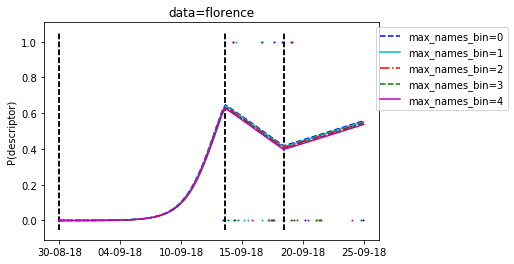

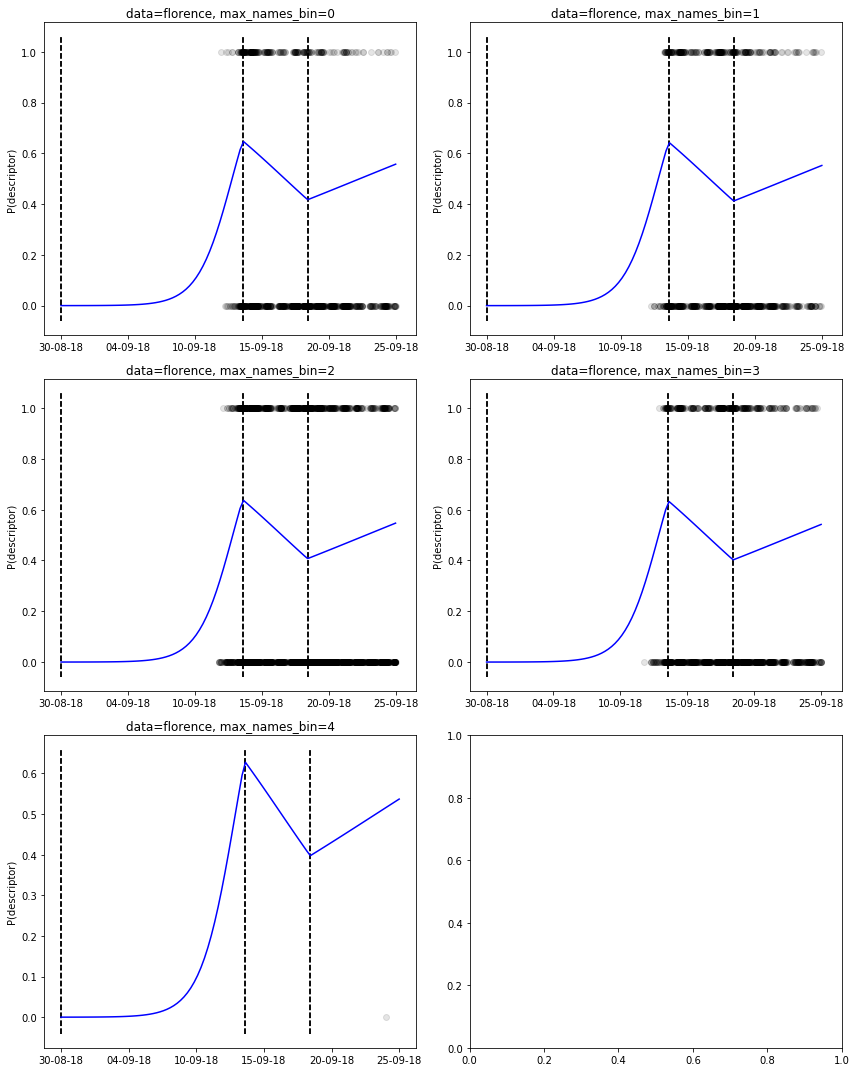

testing data harvey
testing data 1
Optimization terminated successfully.
         Current function value: 0.264457
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                66481
Model:                          Logit   Df Residuals:                    66476
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.06885
Time:                        19:50:16   Log-Likelihood:                -17581.
converged:                       True   LL-Null:                       -18881.
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2522      0.027    -45.719      0.0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


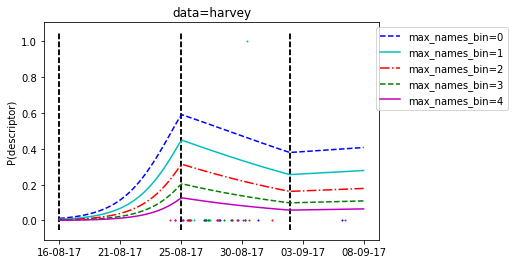

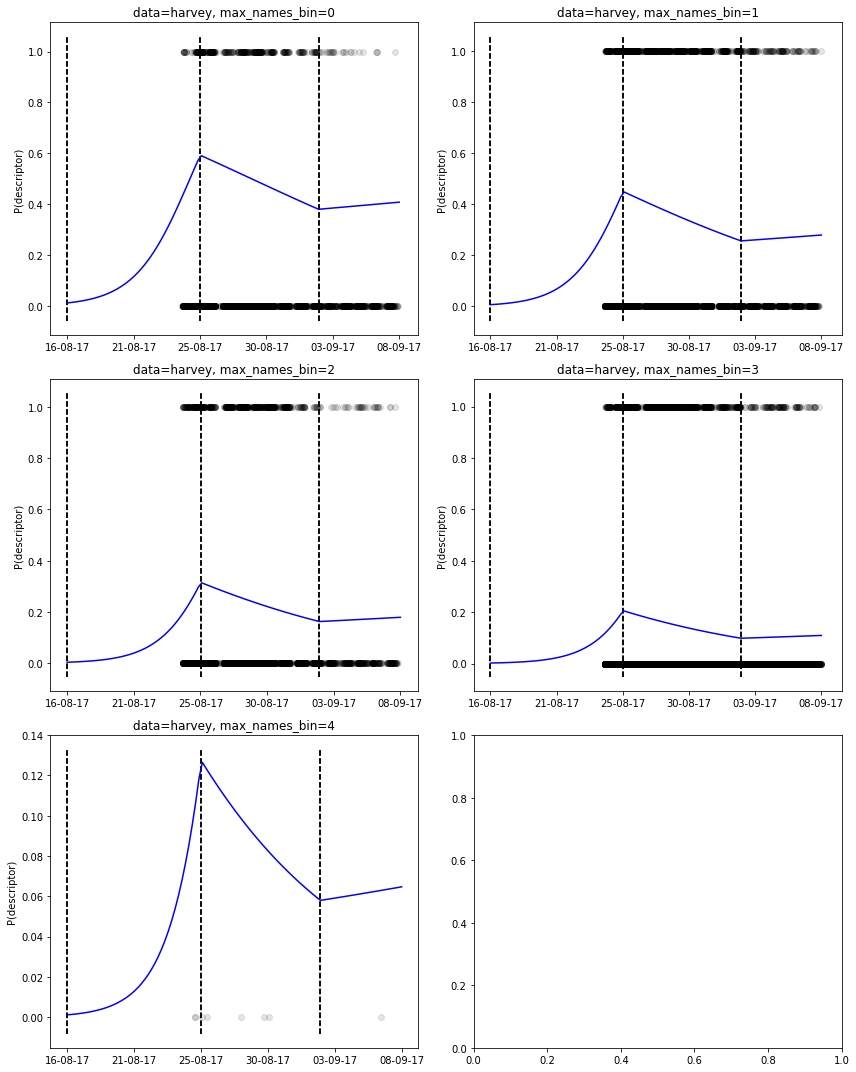

testing data irma
testing data 1
Optimization terminated successfully.
         Current function value: 0.294518
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                42170
Model:                          Logit   Df Residuals:                    42165
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                0.005378
Time:                        19:50:18   Log-Likelihood:                -12420.
converged:                       True   LL-Null:                       -12487.
                                        LLR p-value:                 4.683e-28
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.2661      0.032    -70.692      0.000

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


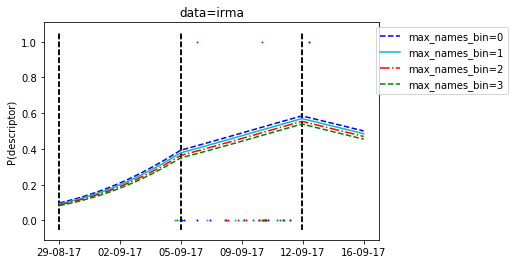

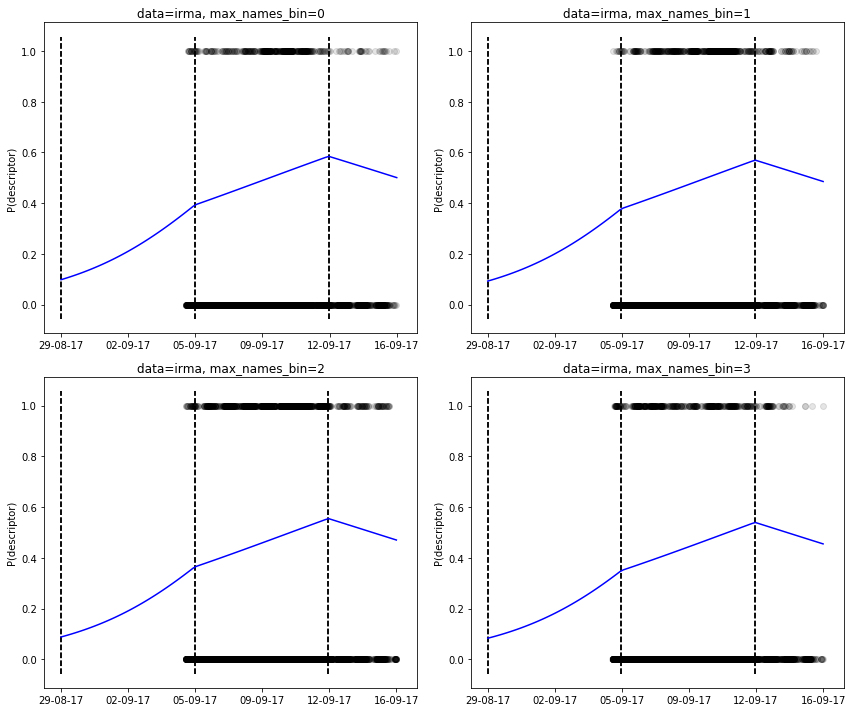

testing data maria
testing data 1
Optimization terminated successfully.
         Current function value: 0.296134
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 7141
Model:                          Logit   Df Residuals:                     7136
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.04676
Time:                        19:50:20   Log-Likelihood:                -2114.7
converged:                       True   LL-Null:                       -2218.4
                                        LLR p-value:                 9.223e-44
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.4773      0.086    -28.662      0.00

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


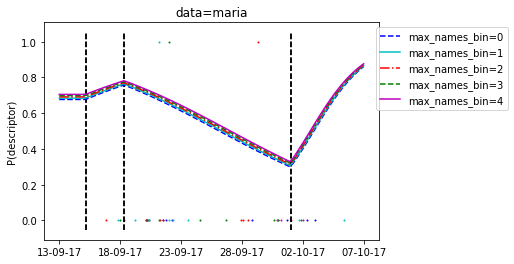

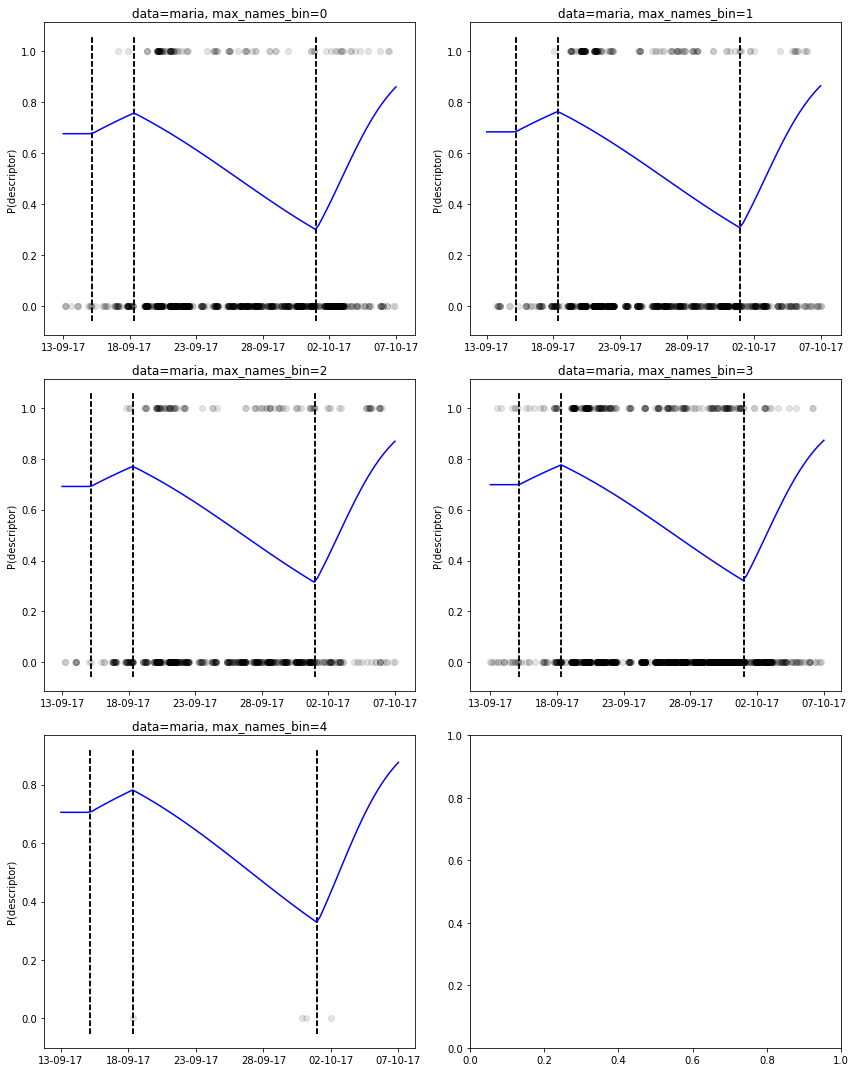

testing data michael
testing data 1
Optimization terminated successfully.
         Current function value: 0.472484
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         has_descriptor   No. Observations:                 6585
Model:                          Logit   Df Residuals:                     6580
Method:                           MLE   Df Model:                            4
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                 0.01742
Time:                        19:50:22   Log-Likelihood:                -3111.3
converged:                       True   LL-Null:                       -3166.5
                                        LLR p-value:                 6.186e-23
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2203      0.044    -27.498      0.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


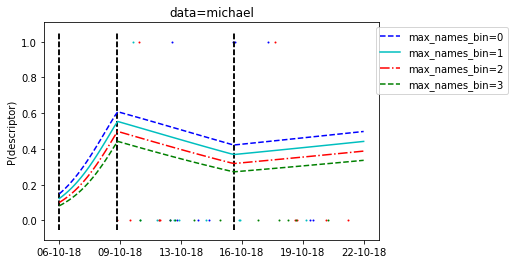

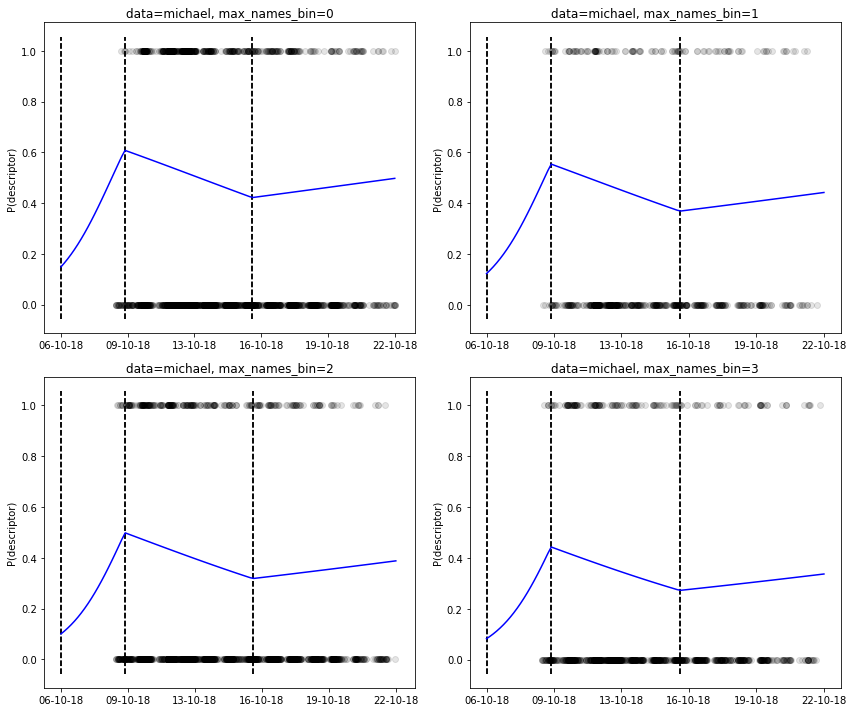

In [425]:
# ind_var = 'C(max_pop_bin)'
# ind_var = 'max_pop_bin'
importance_var = 'max_names_bin'
event_time_vars = ['form', 'landfall', 'dissipation']
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
# complete regression won't work! because every event has different
# event times, so we can't simulate time data
# ind_vars = [ind_var,] + event_time_vars_since + ['C(data_name_fixed)']
ind_vars = [ind_var,] + event_time_vars_since
fixed_var = ''
dep_var = 'has_descriptor'
N_time_bins = 100
for data_name_i, data_i in combined_tag_data_importance.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    data_group_var = 'dummy'
    # data_group_var = 'data_name_fixed'
    if(data_group_var == 'dummy'):
        data_i = data_i.copy()
        data_i.loc[:, data_group_var] = 1
    model_params_i = run_regression(data_i, fixed_var=fixed_var, ind_vars=ind_vars, dep_var=dep_var, data_group_var=data_group_var, use_freq_NE_data=False)
    model_name, model, model_params = model_params_i[0]
    plot_sim_data(data_i, model, model_params, ind_var=ind_var, N_time_bins=N_time_bins, time_var='date', event_time_vars=['form', 'landfall', 'dissipation'])

OK! Any way you show it, the mediating effect of entity importance isn't really visually salient, even though the overall effect is significant.

### Descriptor regression feature ablation
How accurately can we predict descriptor presence?

We'll compare models in terms of (1) deviance and (2) performance.

Let's compare:

- entity-only model
- entity + linear time
- entity + multiple split points
- entity + entity attributes (`max_pop`, `max_names`)
- entity + entity attributes + linear time
- entity + entity attributes + multiple split points

In [220]:
## reload combined data from memory
## and rebuild everything...FML
## this actually doesn't take super long
import pandas as pd
import dateutil
from datetime import datetime
from data_helpers import extract_freq_NEs
import numpy as np
combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', compression='gzip', index_col=False, converters={'date':lambda x: dateutil.parser.parse(x).timestamp()})
# for x in combined_tag_data.loc[:, 'date'].values:
#     try:
#         datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#     except Exception as e:
#         print('error with date %s'%(x))
#         break
# combined_tag_data = combined_tag_data.assign(date=combined_tag_data.loc[:, 'date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()))
combined_tag_data_valid_loc = combined_tag_data[combined_tag_data.loc[:, 'valid_loc']]

## add relevant dates
# relevant hurricane dates
event_dates = pd.read_csv('../../data/hurricane_data/hurricane_dates.tsv', sep='\t', index_col=False, converters={'hurricane_date':lambda x: datetime.strptime('%s EST'%(x), '%d-%m-%y %Z')})
event_dates.rename(columns={'hurricane_name':'data_name_fixed'}, inplace=True)

def assign_time_period(data, event_time_vars):
    time_period = event_time_vars[0]
    for etv in event_time_vars:
        etv_since = 'since_%s'%(etv)
        if(data.loc[etv_since] == 0.):
            break
        time_period = etv
    return time_period

event_dates_pivot = event_dates.pivot(index='data_name_fixed', columns='hurricane_type', values='hurricane_date').reset_index()
combined_tag_data_valid_loc_time = pd.merge(combined_tag_data_valid_loc, event_dates_pivot, on='data_name_fixed')
# remove all tweets sent before formation time
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, 'form'].apply(lambda x: x.timestamp()) <= combined_tag_data_valid_loc_time.loc[:, 'date']]
combined_tag_data_valid_loc_time_ = []
time_var = 'date'
event_time_vars = ['form', 'landfall', 'dissipation']
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    date_min_i = data_i.loc[:, time_var].min()
    for j, x in enumerate(event_time_vars):
        x_since = 'since_%s'%(x)
        data_i.loc[:, x_since] = (data_i.loc[:, time_var] - data_i.loc[:, x].apply(lambda x: x.timestamp())).apply(lambda x: max(0, x))
        # convert to days for better interpretability
        data_i.loc[:, x_since] = data_i.loc[:, x_since] / (3600*24)
    # also get time period variable for completeness
    # ex. formation_period => tweet posted DURING formation period
    data_i = data_i.assign(**{'time_period_type' : data_i.apply(lambda x: assign_time_period(x, event_time_vars), axis=1)})
    # don't do this! creates perfect separation in data
#     for j, x in enumerate(event_time_vars):
#         x_since = 'since_%s'%(x)
#         event_time_vars_after_x = ['since_%s'%(v) for v in event_time_vars[j+1:]]
# #         print('event time vars after %s = %s'%(x_since, ','.join(event_time_vars_after_x)))
#         if(len(event_time_vars_after_x) > 0):
#             data_i.loc[:, '%s_binary'%(x_since)] = ((data_i.loc[:, x_since] > 0) & (data_i.loc[:, event_time_vars_after_x].sum(axis=1) == 0.)).astype(int)
#         else:
#             data_i.loc[:, '%s_binary'%(x_since)] = (data_i.loc[:, x_since] > 0).astype(int)
    combined_tag_data_valid_loc_time_.append(data_i)
combined_tag_data_valid_loc_time = pd.concat(combined_tag_data_valid_loc_time_, axis=0)
# remove invalid tweets
# combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary']].sum(axis=1).astype(int)==1]

## add importance stats

import pickle
# geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))

max_pops = pd.Series({k : v.loc[:, 'population'].max() for k,v in geo_dict.items()})
max_names = pd.Series({k : v.loc[:, 'alternate_name_count'].max() for k,v in geo_dict.items()})

combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_pop=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_pops.loc[x.replace('_', ' ')]))
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_names=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_names.loc[x.replace('_', ' ')]))

N_bins = 4
importance_stats = ['max_pop', 'max_names']
combined_tag_data_importance = []
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    data_i_dedup = data_i.drop_duplicates('NE_fixed')
    for importance_stat in importance_stats:
        importance_stat_vals = np.log(data_i_dedup.loc[:, importance_stat]+1.)
        importance_stat_bins = np.linspace(importance_stat_vals.min(), importance_stat_vals.max(), N_bins+1)[1:]
        importance_stat_bin_vals = pd.DataFrame(np.digitize(importance_stat_vals, bins=importance_stat_bins), columns=['%s_bin'%(importance_stat)])
        importance_stat_bin_vals.loc[:, 'NE_fixed'] = data_i_dedup.loc[:, 'NE_fixed'].values
        data_i = pd.merge(data_i, importance_stat_bin_vals, on='NE_fixed')
    combined_tag_data_importance.append(data_i)
combined_tag_data_importance = pd.concat(combined_tag_data_importance, axis=0)

## restrict to freq NEs
## filter to data with frequent entities for better estimation
combined_tag_data_importance_freq_NE = []
dep_var = 'has_descriptor'
top_k_NE_min = 5
for data_name_i, data_i in combined_tag_data_importance.groupby('data_name_fixed'):
    freq_NEs_i = extract_freq_NEs(data_i, dep_var=dep_var, min_count_0=top_k_NE_min, min_count_1=top_k_NE_min)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    combined_tag_data_importance_freq_NE.append(data_i_k)
combined_tag_data_importance_freq_NE = pd.concat(combined_tag_data_importance_freq_NE, axis=0)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [221]:
display(combined_tag_data_importance_freq_NE.loc[:, 'time_period_type'].value_counts())

landfall       76121
dissipation    10737
form            9079
Name: time_period_type, dtype: int64

In [215]:
# sanity check: how many tweets with bad binary dates?
# print(combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary']].sum(axis=1)==1].shape[0])
# display(combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary']].sum(axis=1)==1])
# print(combined_tag_data_importance_freq_NE[combined_tag_data_importance_freq_NE.loc[:, ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary']].sum(axis=1)==0.].shape[0])
# display(combined_tag_data_importance_freq_NE[combined_tag_data_importance_freq_NE.loc[:, ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary']].sum(axis=1)==0.])

0


Empty DataFrame
Columns: [id, txt, data_name_fixed, username, date, lang, NE, NE_type, NE_LOC, valid_loc, has_descriptor, NE_fixed, dissipation, form, landfall, since_form, since_landfall, since_dissipation, since_form_binary, since_landfall_binary, since_dissipation_binary, max_pop, max_names, max_pop_bin, max_names_bin]
Index: []

[0 rows x 25 columns]

In [14]:
from statsmodels.api import GLM
from statsmodels.formula.api import glm, logit
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit
from sklearn.model_selection import KFold
import re
def clean_var_name(x):
    return x.replace('-','_').replace('/', '_').replace("'", '_')

def fit_evaluate_model(data, ind_vars, dep_var, test=0.1, k=10, balance=False):
    """
    Fit and evaluate LR model based on ability
    to predict dep_var. 
    We are interested in (1) predictive power and (2) deviance from null model.
    
    :param data: prediction data
    :param ind_vars: independent vars
    :param dep_var: dependent var
    :param test: test percent
    :param k: k_fold classification count
    :param balance: 
    """
    np.random.seed(123)
    formula = '%s ~ %s'%(dep_var, ' + '.join(ind_vars))
    print('formula: %s'%(formula))
#     print(data.loc[:, 'NE_fixed'].head())
    ## regular fit/statistics
    model = glm(formula=formula, data=data, family=Binomial())
    model_results = model.fit()
    print(model_results.summary())
    if(balance):
        data.loc[:, dep_var] = data.loc[:, dep_var].astype(int)
        dep_var_counts = data.loc[:, dep_var].value_counts()
        N_min_class = dep_var_counts.iloc[-1]
        data_balanced = pd.concat([data_c.loc[np.random.choice(data_c.index, N_min_class, replace=False), :] for c, data_c in data.groupby(dep_var)], axis=0)
        data = data_balanced.copy()
#     print(data.loc[:, 'NE_fixed'].head())
            
    ## k-fold cross validation
    # convert categorical vars to usable format
    reg_data = data.copy()
    cat_var_matcher = re.compile('C\((.+)\)')
    ind_vars_cat = [cat_var_matcher.search(x).group(1) for x in ind_vars if cat_var_matcher.search(x) is not None]
    if(len(ind_vars_cat) > 0):
        ind_var_cat_vals = []
    #     print(reg_data.loc[:, ind_vars_cat].head())
        for ind_var_cat in ind_vars_cat:
            ind_var_unique_vals = list(reg_data.loc[:, ind_var_cat].unique())
    #             print(unique_val)
            reg_data = reg_data.assign(**{clean_var_name(x):(reg_data.loc[:, ind_var_cat]==x).astype(int) for x in ind_var_unique_vals})
            # fix bad strings
            ind_var_unique_vals = [clean_var_name(x) for x in ind_var_unique_vals]
            ind_var_cat_vals += ind_var_unique_vals
            reg_data.drop(ind_var_cat, axis=1, inplace=True)
    #     print('data cols %s'%(str(reg_data.columns)))
        ind_vars_full = (set(ind_vars) - set(['C(%s)'%(x) for x in ind_vars_cat])) | set(ind_var_cat_vals)
        formula_full = '%s ~ %s'%(dep_var, ' + '.join(ind_vars_full))
    else:
        formula_full = '%s ~ %s'%(dep_var, ' + '.join(ind_vars))
#     print('formula full => %s'%(formula_full))
    kfold = KFold(n_splits=k, shuffle=True)
    predict_acc = []
    reg_data.loc[:, dep_var] = reg_data.loc[:, dep_var].astype(int)
    for train_idx, test_idx in kfold.split(reg_data):
        data_train = reg_data.iloc[train_idx, :]
        data_test = reg_data.iloc[test_idx, :]
#         print('train data %s'%(str(data_train.columns)))
        model_i = logit(formula=formula_full, data=data_train)
#         model_i = logit(endog=train_data.loc[:, dep_var], exog=train_data.loc[:, ind_vars])
        model_i_results = model_i.fit(full_output=False, disp=True)
        model_i_results.predict(data_test)
        pred_vals_i = np.array([int(x > 0.5) for x in model_i_results.predict(data_test)])
        y = data_test.loc[:, dep_var].astype(int)
#         predict_results_i = 1 - ((y - pred_vals_i) / len(y))
        predict_results_i = (y == pred_vals_i)
        predict_acc_i = np.mean(predict_results_i)
        predict_acc.append(predict_acc_i)
    return model_results, predict_acc

In [ ]:
## testing prediction with categorical variables
import string
test_data = pd.DataFrame(np.random.randn(100, 10), columns=list(string.ascii_lowercase[:10]))
ind_vars = list(test_data.columns[:4])
dep_var = test_data.columns[4]
# make dep_var predictable from ind_vars
for i in ind_vars:
    test_data.loc[:, i] = test_data.loc[:, dep_var] + np.random.randn(test_data.shape[0])*2.
test_data.loc[:, dep_var] = test_data.loc[:, dep_var].apply(lambda x: int(x > test_data.loc[:, dep_var].median()))
# test categorical
cat_var = 'cat_var'
test_data.loc[:, cat_var] = np.random.choice(list(string.ascii_lowercase[:5]), test_data.shape[0], replace=True)
fit_evaluate_model(test_data, ind_vars+['C(%s)'%(cat_var)], dep_var)
# test_data_1 = test_data.iloc[0:int(test_data.shape[0]*.9), :]
# test_data_2 = test_data.iloc[int(test_data.shape[0]*.9):, :]
# model = logit(formula='%s ~ %s'%(dep_var, ' + '.join(ind_vars+['C(%s)'%(cat_var)])), data=test_data_1)
# res = model.fit()
# print(res.summary())
# # attempt to predict
# pred_vals = res.predict(test_data_2)
# print(np.mean(pred_vals.values))

In [485]:
## dummy data
import string
test_data = pd.DataFrame(np.random.randn(100, 10), columns=list(string.ascii_lowercase[:10]))
ind_vars = test_data.columns[:6]
dep_var = test_data.columns[7]
# make dep_var predictable from ind_vars
scale_factor = 0.5 # higher scale => less predictable => lower accuracy
for i in ind_vars:
    test_data.loc[:, i] = test_data.loc[:, dep_var] + np.random.randn(test_data.shape[0])*scale_factor
test_data.loc[:, dep_var] = test_data.loc[:, dep_var].apply(lambda x: int(x > test_data.loc[:, dep_var].median()))
model_results, predict_acc = fit_evaluate_model(test_data, ind_vars, dep_var, test=0.1, balance=True)
print(np.mean(predict_acc))

0.9099999999999999


In [169]:
## data cleaning
dep_var = 'has_descriptor'
test_pct = 0.1
balance_data = True
## only include data with frequent entities for better estimation
combined_tag_data_importance_freq_NE = []
top_k_NE_min = 5
for data_name_i, data_i in combined_tag_data_importance.groupby('data_name_fixed'):
    freq_NEs_i = extract_freq_NEs(data_i, dep_var=dep_var, min_count_0=top_k_NE_min, min_count_1=top_k_NE_min)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    combined_tag_data_importance_freq_NE.append(data_i_k)
combined_tag_data_importance_freq_NE = pd.concat(combined_tag_data_importance_freq_NE, axis=0)
# get rid of duplicate index!!
combined_tag_data_importance_freq_NE.index = np.arange(combined_tag_data_importance_freq_NE.shape[0])
N_majority = combined_tag_data_importance_freq_NE.loc[:, dep_var].value_counts()[0]
print('%.3f%% majority class'%(N_majority / combined_tag_data_importance_freq_NE.shape[0]*100))

88.960% majority class


Let's test the joint models first:

- name only
- name + NE
- name + NE + linear time
- name + NE + all time
- name + NE + all time (binary)
- importance
- importance + linear time
- importance + all time
- importance + all time (binary)

In [32]:
# name only
ind_vars = ['C(data_name_fixed)']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    96079
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32442.
Date:                Sat, 13 Apr 2019   Deviance:                       64885.
Time:                        14:57:21   Pearson chi2:                 9.61e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.0819      0.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.670923
         Iterations: 35
         Current function value: 0.670791
         Iterations: 35
         Current function value: 0.670307
         Iterations: 35
         Current function value: 0.671550
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.670678
         Iterations: 35
         Current function value: 0.669808
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.670736
         Iterations: 35
         Current function value: 0.670421
         Iterations: 35
acc = 0.567


In [61]:
# entity-only
ind_vars = ['C(NE_fixed)', 'C(data_name_fixed)']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(NE_fixed) + C(data_name_fixed)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    95781
Model Family:                Binomial   Df Model:                          302
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28107.
Date:                Sun, 14 Apr 2019   Deviance:                       56213.
Time:                        17:48:27   Pearson chi2:                 9.58e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept               

         Current function value: 0.551522
         Iterations: 35
         Current function value: 0.550144
         Iterations: 35
         Current function value: 0.549115
         Iterations: 35
         Current function value: 0.549924
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.549363
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.550473
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.548336
         Iterations: 35
         Current function value: 0.549189
         Iterations: 35
         Current function value: 0.550553
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.551077
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


acc = 0.724


In [62]:
# entity+linear time
ind_vars = ['C(NE_fixed)', 'C(data_name_fixed)', 'since_form']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(NE_fixed) + C(data_name_fixed) + since_form
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    95780
Model Family:                Binomial   Df Model:                          303
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28080.
Date:                Sun, 14 Apr 2019   Deviance:                       56159.
Time:                        18:04:53   Pearson chi2:                 9.57e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept  

         Current function value: 0.570582
         Iterations: 35
         Current function value: 0.549705
         Iterations: 35
         Current function value: 0.548587
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.549529
         Iterations: 35
         Current function value: 0.548909
         Iterations: 35
         Current function value: 0.549970
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.547969
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.548771
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.550188
         Iterations: 35
         Current function value: 0.550487
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


acc = 0.723


In [28]:
# entity+split time
ind_vars = ['C(NE_fixed)', 'C(data_name_fixed)', 'since_form', 'since_landfall', 'since_dissipation']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(NE_fixed) + C(data_name_fixed) + since_form + since_landfall + since_dissipation
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    95778
Model Family:                Binomial   Df Model:                          305
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28055.
Date:                Sat, 13 Apr 2019   Deviance:                       56110.
Time:                        14:17:58   Pearson chi2:                 9.56e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.549338
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


acc = 0.722


In [222]:
# entity+split time (categorical)
ind_vars = ['C(NE_fixed)', 'C(data_name_fixed)', 'C(time_period_type)']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(NE_fixed) + C(data_name_fixed) + C(time_period_type)
                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['has_descriptor[False]', 'has_descriptor[True]']   No. Observations:                95937
Model:                                                           GLM   Df Residuals:                    95632
Model Family:                                               Binomial   Df Model:                          304
Link Function:                                                 logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -28009.
Date:                                               Wed, 24 Apr 2019   Deviance:                       56019.
Time:                                                       12:00:53   Pearson chi2:                 9.56e+04
No. Iterations:                        

         Current function value: inf
         Iterations: 35
         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


acc = 0.740


In [29]:
# importance only
ind_vars = ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + max_pop_bin + max_names_bin
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    96077
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30519.
Date:                Sat, 13 Apr 2019   Deviance:                       61038.
Time:                        14:30:07   Pearson chi2:                 9.19e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept         

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.614372
         Iterations 26
         Current function value: 0.613533
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.614241
         Iterations: 35
         Current function value: 0.612772
         Iterations: 35
         Current function value: 0.614169
         Iterations: 35
         Current function value: 0.612968
         Iterations: 35
         Current function value: 0.613693
         Iterations: 35
         Current function value: 0.614257
         Iterations: 35
         Current function value: 0.614035
         Iterations: 35
acc = 0.668


In [88]:
# linear time only
ind_vars = ['C(data_name_fixed)', 'since_form',]
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + since_form
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    96078
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32290.
Date:                Sun, 14 Apr 2019   Deviance:                       64579.
Time:                        19:46:22   Pearson chi2:                 9.60e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.666724
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.667449
         Iterations 9
         Current function value: 0.667685
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.666796
         Iterations 7


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.668047
         Iterations: 35
         Current function value: 0.667559
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.666348
         Iterations 6
         Current function value: 0.667578
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.666717
         Iterations: 35
acc = 0.565


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [30]:
# split time only
ind_vars = ['C(data_name_fixed)', 'since_form', 'since_landfall', 'since_dissipation']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + since_form + since_landfall + since_dissipation
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    96076
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32167.
Date:                Sat, 13 Apr 2019   Deviance:                       64334.
Time:                        14:49:58   Pearson chi2:                 9.62e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.664380
         Iterations 9
         Current function value: 0.663597
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.664654
         Iterations 6


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.664359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662915
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664188
         Iterations 6


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.663327
         Iterations 10
acc = 0.591


In [224]:
# split time binary only
ind_vars = ['C(data_name_fixed)', 'C(time_period_type)']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + C(time_period_type)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                95937
Model:                            GLM   Df Residuals:                    95930
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32335.
Date:                Wed, 24 Apr 2019   Deviance:                       64671.
Time:                        12:08:27   Pearson chi2:                 9.59e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept             

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.636039
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.635971
         Iterations: 35
         Current function value: 0.636604
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.637618
         Iterations: 35
         Current function value: 0.638072
         Iterations: 35
         Current function value: 0.636730
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.637311
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.638873
         Iterations: 35
acc = 0.652


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [33]:
# split time+importance
ind_vars = ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + max_pop_bin + max_names_bin + since_form + since_landfall + since_dissipation
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                96084
Model:                            GLM   Df Residuals:                    96074
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30419.
Date:                Sat, 13 Apr 2019   Deviance:                       60839.
Time:                        18:03:58   Pearson chi2:                 9.17e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.611296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611890
         Iterations 14


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.610425
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.611655
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.610800
         Iterations 5


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.611119
         Iterations: 35
         Current function value: 0.612005
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.611444
         Iterations: 35
acc = 0.663


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [225]:
# split time binary+importance
ind_vars = ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'C(time_period_type)']
test_pct = 0.9
balance_data = True
model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_vars, dep_var, test=test_pct, balance=balance_data)
print('acc = %.3f'%(np.mean(predict_acc)))

formula: has_descriptor ~ C(data_name_fixed) + max_pop_bin + max_names_bin + C(time_period_type)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                95937
Model:                            GLM   Df Residuals:                    95928
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30417.
Date:                Wed, 24 Apr 2019   Deviance:                       60833.
Time:                        12:10:52   Pearson chi2:                 9.18e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.586830
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.585821
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.585896
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.586994
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.587090
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.587006
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.586556
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.587935
         Iterations: 35


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: 0.589252
         Iterations: 35
acc = 0.690


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [235]:
pd.set_option('display.float_format', lambda x: '%.3f'%(x))
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    print(df_formatted.to_csv(sep="|", index=False))

In [233]:
%%capture joint_data_output
joint_data_results = []
joint_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'C(time_period_type)'])
ind_var_sets = [
    ['C(NE_fixed)'], 
    ['C(NE_fixed)', 'since_form'],
    ['C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(NE_fixed)', 'C(time_period_type)'],
#     ['C(NE_fixed)', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
    ['since_form'],
    ['since_form', 'since_landfall', 'since_dissipation'],
    ['C(time_period_type)'],
#     ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
    ['max_pop_bin', 'max_names_bin'],
    ['max_pop_bin', 'max_names_bin', 'since_form'],
    ['max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)'],
#     ['max_pop_bin', 'max_names_bin', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
]
cat_coeff_names_to_track = ['time_period_type']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else:
    cat_coeff_matcher = re.compile('.*')
dep_var = 'has_descriptor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_model(combined_tag_data_importance_freq_NE, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    joint_data_results.append([data_name, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        joint_data_coeffs.append([[data_name, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
#     predict_accs.append([data_name_i, np.mean(predict_acc)])
    ## entity+time
#         model_results, predict_acc = fit_evaluate_model(data_i, ind_vars_2, dep_var, test=test_pct, balance=True)
#         print('data=%s, mean_acc=%.3f'%(data_name_i, np.mean(predict_acc)))
joint_data_results = pd.DataFrame(joint_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
joint_data_coeffs = pd.DataFrame(np.vstack(joint_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [234]:
joint_data_output.show()

testing ind_vars = C(NE_fixed)
formula: has_descriptor ~ C(NE_fixed)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                95937
Model:                            GLM   Df Residuals:                    95638
Model Family:                Binomial   Df Model:                          298
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28111.
Date:                Wed, 24 Apr 2019   Deviance:                       56221.
Time:                        14:11:24   Pearson chi2:                 9.59e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept     

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sta

In [238]:
## get mean/deviance
float_cols = ['acc_mean', 'deviance']
print('printing stats for %s'%(','.join(float_cols)))
for data_name_i, data_i in joint_data_results.groupby('data_name'):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(x))
    data_i.drop('data_name', axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)
## get coefficients, p-vals for time and importance vars
coeff_float_cols = ['coeff', 'p_val']
print('printing stats for %s'%(','.join(coeff_float_cols)))
for (data_name_i), data_i in joint_data_coeffs.groupby(['data_name']):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in coeff_float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
    data_i.drop(['data_name'], axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)

printing stats for acc_mean,deviance
processing data joint
ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.740|56221.155
C(NE_fixed)+since_form|0.741|56198.145
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.741|56091.083
C(NE_fixed)+C(time_period_type)|0.740|56218.066
since_form|0.649|66494.710
since_form+since_landfall+since_dissipation|0.649|66179.529
C(time_period_type)|0.649|66552.970
max_pop_bin+max_names_bin|0.696|61934.316
max_pop_bin+max_names_bin+since_form|0.696|61928.843
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.689|61382.937
max_pop_bin+max_names_bin+C(time_period_type)|0.696|61893.527

printing stats for coeff,p_val
processing data joint
ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.018|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.094|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.147|0.000
C(NE_fixed)+since_form+since_landfall+s

Same thing but with per-group data.

In [ ]:
%%capture per_data_output
per_data_results = []
per_data_coeffs = []
per_data_coeff_names = set(['since_form', 'since_landfall', 'since_dissipation', 'C(time_period_type)'])
ind_var_sets = [
    ['C(NE_fixed)'], 
    ['C(NE_fixed)', 'since_form'],
    ['C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(NE_fixed)', 'C(time_period_type)'],
#     ['C(NE_fixed)', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
    ['since_form'],
    ['since_form', 'since_landfall', 'since_dissipation'],
    ['C(time_period_type)'],
#     ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
    ['max_pop_bin', 'max_names_bin'],
    ['max_pop_bin', 'max_names_bin', 'since_form'],
    ['max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)'],
#     ['max_pop_bin', 'max_names_bin', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
]
cat_coeff_names_to_track = ['time_period_type']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else:
    cat_coeff_matcher = re.compile('.*')
test_pct = 0.9
for data_name_i, data_i in combined_tag_data_importance_freq_NE.groupby('data_name_fixed'):
    print('testing data=%s'%(data_name_i))
    for ind_var_set in ind_var_sets:
        print('testing ind_vars = %s'%(','.join(ind_var_set)))
        model_results, predict_acc = fit_evaluate_model(data_i, ind_var_set, dep_var, test=test_pct, balance=True)
        print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
        per_data_results.append([data_name_i, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
        if(len(coeff_names_to_track & set(ind_var_set)) > 0):
            per_data_coeffs.append([[data_name_i, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
    #     predict_accs.append([data_name_i, np.mean(predict_acc)])
        ## entity+time
#         model_results, predict_acc = fit_evaluate_model(data_i, ind_vars_2, dep_var, test=test_pct, balance=True)
#         print('data=%s, mean_acc=%.3f'%(data_name_i, np.mean(predict_acc)))
per_data_results = pd.DataFrame(per_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
per_data_coeffs = pd.DataFrame(np.vstack(per_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [161]:
per_data_output.show()

testing data=florence
testing ind_vars = C(NE_fixed)
formula: has_descriptor ~ C(NE_fixed)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         has_descriptor   No. Observations:                 5467
Model:                            GLM   Df Residuals:                     5413
Model Family:                Binomial   Df Model:                           53
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2763.6
Date:                Mon, 22 Apr 2019   Deviance:                       5527.2
Time:                        18:14:09   Pearson chi2:                 5.47e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting

In [248]:
## get mean/deviance
float_cols = ['acc_mean', 'deviance']
print('printing stats for %s'%(','.join(float_cols)))
for data_name_i, data_i in per_data_results.groupby('data_name'):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(x))
    data_i.drop('data_name', axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)
    
## get coefficients, p-vals for time and importance vars
coeff_float_cols = ['coeff', 'p_val']
print('printing stats for %s'%(','.join(coeff_float_cols)))
for (data_name_i), data_i in per_data_coeffs.groupby(['data_name']):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in coeff_float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
    data_i.drop(['data_name'], axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)

printing stats for acc_mean,deviance
processing data florence
ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.627|5527.170
C(NE_fixed)+since_form|0.640|5515.569
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.645|5482.550
C(NE_fixed)+C(time_period_type)|0.638|5516.680
since_form|0.544|6167.531
since_form+since_landfall+since_dissipation|0.567|6082.287
C(time_period_type)|0.528|6173.409
max_pop_bin+max_names_bin|0.533|6139.409
max_pop_bin+max_names_bin+since_form|0.541|6121.495
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.563|6044.679
max_pop_bin+max_names_bin+C(time_period_type)|0.548|6127.176

processing data harvey


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.724|27272.594
C(NE_fixed)+since_form|0.734|27269.169
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.733|27250.787
C(NE_fixed)+C(time_period_type)|0.732|27260.771
since_form|0.566|32833.620
since_form+since_landfall+since_dissipation|0.571|32642.085
C(time_period_type)|0.518|33105.998
max_pop_bin+max_names_bin|0.729|28465.903
max_pop_bin+max_names_bin+since_form|0.729|28452.225
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.729|28438.704
max_pop_bin+max_names_bin+C(time_period_type)|0.729|28449.351

processing data irma
ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.655|16306.250
C(NE_fixed)+since_form|0.653|16303.822
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.653|16299.351
C(NE_fixed)+C(time_period_type)|0.653|16305.349
since_form|0.543|18061.854
since_form+since_landfall+since_dissipation|0.542|18047.283
C(time_period_type)|0.494|18082.949
max_pop_bin+max_names_bin|0.570|17928

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.089|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.580|0.021
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.724|0.004
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.235|0.000
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.050|0.858
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|-0.157|0.289
since_form|since_form|-0.109|0.000
since_form+since_landfall+since_dissipation|since_form|0.524|0.033
since_form+since_landfall+since_dissipation|since_landfall|-0.684|0.006
since_form+since_landfall+since_dissipation|since_dissipation|0.266|0.000
C(time_period_type)|C(time_period_type)[T.form]|0.167|0.538
C(time_period_type)|C(time_period_type)[T.landfall]|-0.340|0.016
max_pop_bin+max_names_bin+since_form|max_pop_bin|-0.481|0.004
max_pop_bin+max_names_bin+since_form|max_names_bin|-0.137|0.077
max_pop_bi

Goal: fill out these tables with prediction models.

- **joint**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.740|56221.155
C(NE_fixed)+since_form|0.741|56198.145
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.741|56091.083
C(NE_fixed)+C(time_period_type)|0.740|56218.066
since_form|0.649|66494.710
since_form+since_landfall+since_dissipation|0.649|66179.529
C(time_period_type)|0.649|66552.970
max_pop_bin+max_names_bin|0.696|61934.316
max_pop_bin+max_names_bin+since_form|0.696|61928.843
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.689|61382.937
max_pop_bin+max_names_bin+C(time_period_type)|0.696|61893.527

- **Florence**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.627|5527.170
C(NE_fixed)+since_form|0.640|5515.569
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.645|5482.550
C(NE_fixed)+C(time_period_type)|0.638|5516.680
since_form|0.544|6167.531
since_form+since_landfall+since_dissipation|0.567|6082.287
C(time_period_type)|0.528|6173.409
max_pop_bin+max_names_bin|0.533|6139.409
max_pop_bin+max_names_bin+since_form|0.541|6121.495
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.563|6044.679
max_pop_bin+max_names_bin+C(time_period_type)|0.548|6127.176

- **Harvey**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.724|27272.594
C(NE_fixed)+since_form|0.734|27269.169
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.733|27250.787
C(NE_fixed)+C(time_period_type)|0.732|27260.771
since_form|0.566|32833.620
since_form+since_landfall+since_dissipation|0.571|32642.085
C(time_period_type)|0.518|33105.998
max_pop_bin+max_names_bin|0.729|28465.903
max_pop_bin+max_names_bin+since_form|0.729|28452.225
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.729|28438.704
max_pop_bin+max_names_bin+C(time_period_type)|0.729|28449.351

- **Irma**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.655|16306.250
C(NE_fixed)+since_form|0.653|16303.822
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.653|16299.351
C(NE_fixed)+C(time_period_type)|0.653|16305.349
since_form|0.543|18061.854
since_form+since_landfall+since_dissipation|0.542|18047.283
C(time_period_type)|0.494|18082.949
max_pop_bin+max_names_bin|0.570|17928.036
max_pop_bin+max_names_bin+since_form|0.574|17891.934
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.577|17880.122
max_pop_bin+max_names_bin+C(time_period_type)|0.575|17908.291

- **Maria**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.607|3214.715
C(NE_fixed)+since_form|0.661|3132.075
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.674|3060.254
C(NE_fixed)+C(time_period_type)|0.611|3213.093
since_form|0.646|3217.556
since_form+since_landfall+since_dissipation|0.664|3123.546
C(time_period_type)|0.525|3343.000
max_pop_bin+max_names_bin|0.618|3252.359
max_pop_bin+max_names_bin+since_form|0.660|3165.129
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.677|3091.945
max_pop_bin+max_names_bin+C(time_period_type)|0.617|3250.355

- **Michael**

ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)|0.593|3664.560
C(NE_fixed)+since_form|0.597|3655.206
C(NE_fixed)+since_form+since_landfall+since_dissipation|0.603|3646.380
C(NE_fixed)+C(time_period_type)|0.599|3661.710
since_form|0.517|3858.463
since_form+since_landfall+since_dissipation|0.523|3845.333
C(time_period_type)|0.519|3859.740
max_pop_bin+max_names_bin|0.582|3758.882
max_pop_bin+max_names_bin+since_form|0.586|3750.098
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.589|3741.847
max_pop_bin+max_names_bin+C(time_period_type)|0.588|3756.182

Main findings from prediction:

- entities explain most of variance in data (high prediction, low deviance)
- importance is almost as predictive as entities
- for joint model, time doesn't really help
- for individual models, time is less helpful overall, but binary time is even less helpful
- for individual models, `Florence` and `Maria` have most apparent influence from time  (time alone > importance)

TODO:

- **Effect sizes**

    - **joint**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.018|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.094|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.147|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.081|0.000
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.018|0.733
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|0.057|0.119
since_form|since_form|-0.026|0.000
since_form+since_landfall+since_dissipation|since_form|-0.003|0.509
since_form+since_landfall+since_dissipation|since_landfall|-0.082|0.000
since_form+since_landfall+since_dissipation|since_dissipation|0.170|0.000
C(time_period_type)|C(time_period_type)[T.form]|-0.113|0.011
C(time_period_type)|C(time_period_type)[T.landfall]|-0.161|0.000
max_pop_bin+max_names_bin+since_form|max_pop_bin|0.445|0.000
max_pop_bin+max_names_bin+since_form|max_names_bin|-0.799|0.000
max_pop_bin+max_names_bin+since_form|since_form|0.007|0.019
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|0.511|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|-0.834|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.065|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|-0.130|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|0.133|0.000
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|-0.046|0.315
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|-0.184|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|0.452|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|-0.798|0.000

    - **Florence**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.036|0.001
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.263|0.004
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.404|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.184|0.000
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.373|0.001
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|0.058|0.443
since_form|since_form|-0.038|0.000
since_form+since_landfall+since_dissipation|since_form|0.492|0.000
since_form+since_landfall+since_dissipation|since_landfall|-0.670|0.000
since_form+since_landfall+since_dissipation|since_dissipation|0.226|0.000
C(time_period_type)|C(time_period_type)[T.form]|0.332|0.001
C(time_period_type)|C(time_period_type)[T.landfall]|0.180|0.008
max_pop_bin+max_names_bin+since_form|max_pop_bin|-0.428|0.000
max_pop_bin+max_names_bin+since_form|max_names_bin|0.049|0.361
max_pop_bin+max_names_bin+since_form|since_form|-0.038|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|-0.413|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|0.077|0.158
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.474|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|-0.643|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|0.208|0.000
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|0.316|0.002
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|0.188|0.006
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|-0.423|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|0.041|0.445

    - **Harvey**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.010|0.066
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.247|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.272|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.023|0.353
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.019|0.817
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|0.154|0.021
since_form|since_form|-0.095|0.000
since_form+since_landfall+since_dissipation|since_form|0.495|0.000
since_form+since_landfall+since_dissipation|since_landfall|-0.670|0.000
since_form+since_landfall+since_dissipation|since_dissipation|0.249|0.000
C(time_period_type)|C(time_period_type)[T.form]|0.630|0.000
C(time_period_type)|C(time_period_type)[T.landfall]|0.481|0.000
max_pop_bin+max_names_bin+since_form|max_pop_bin|0.601|0.000
max_pop_bin+max_names_bin+since_form|max_names_bin|-1.181|0.000
max_pop_bin+max_names_bin+since_form|since_form|-0.019|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|0.590|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|-1.174|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.191|0.001
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|-0.218|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|0.006|0.793
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|0.206|0.007
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|0.256|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|0.590|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|-1.190|0.000

    - **Irma**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|0.015|0.119
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|-0.009|0.924
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|0.042|0.674
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|-0.073|0.037
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|-0.123|0.377
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|-0.013|0.862
since_form|since_form|0.058|0.000
since_form+since_landfall+since_dissipation|since_form|0.114|0.214
since_form+since_landfall+since_dissipation|since_landfall|-0.030|0.754
since_form+since_landfall+since_dissipation|since_dissipation|-0.115|0.000
C(time_period_type)|C(time_period_type)[T.form]|-0.664|0.000
C(time_period_type)|C(time_period_type)[T.landfall]|-0.200|0.005
max_pop_bin+max_names_bin+since_form|max_pop_bin|0.349|0.000
max_pop_bin+max_names_bin+since_form|max_names_bin|-0.353|0.000
max_pop_bin+max_names_bin+since_form|since_form|0.051|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|0.354|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|-0.351|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.059|0.523
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|0.019|0.845
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|-0.109|0.001
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|-0.564|0.000
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|-0.190|0.008
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|0.347|0.000
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|-0.358|0.000

    - **Maria**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.089|0.000
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.580|0.021
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.724|0.004
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.235|0.000
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.050|0.858
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|-0.157|0.289
since_form|since_form|-0.109|0.000
since_form+since_landfall+since_dissipation|since_form|0.524|0.033
since_form+since_landfall+since_dissipation|since_landfall|-0.684|0.006
since_form+since_landfall+since_dissipation|since_dissipation|0.266|0.000
C(time_period_type)|C(time_period_type)[T.form]|0.167|0.538
C(time_period_type)|C(time_period_type)[T.landfall]|-0.340|0.016
max_pop_bin+max_names_bin+since_form|max_pop_bin|-0.481|0.004
max_pop_bin+max_names_bin+since_form|max_names_bin|-0.137|0.077
max_pop_bin+max_names_bin+since_form|since_form|-0.089|0.000
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|-0.414|0.014
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|-0.088|0.259
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.546|0.028
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|-0.689|0.006
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|0.235|0.000
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|0.094|0.732
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|-0.159|0.273
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|-0.566|0.001
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|-0.201|0.009

    - **Michael**

ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+since_form|since_form|-0.042|0.002
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_form|0.643|0.097
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_landfall|-0.747|0.058
C(NE_fixed)+since_form+since_landfall+since_dissipation|since_dissipation|0.135|0.010
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.form]|0.201|0.428
C(NE_fixed)+C(time_period_type)|C(time_period_type)[T.landfall]|0.158|0.099
since_form|since_form|-0.035|0.005
since_form+since_landfall+since_dissipation|since_form|1.099|0.004
since_form+since_landfall+since_dissipation|since_landfall|-1.183|0.002
since_form+since_landfall+since_dissipation|since_dissipation|0.093|0.062
C(time_period_type)|C(time_period_type)[T.form]|-0.151|0.520
C(time_period_type)|C(time_period_type)[T.landfall]|0.200|0.024
max_pop_bin+max_names_bin+since_form|max_pop_bin|-0.311|0.005
max_pop_bin+max_names_bin+since_form|max_names_bin|-0.125|0.110
max_pop_bin+max_names_bin+since_form|since_form|-0.038|0.003
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_pop_bin|-0.293|0.009
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|max_names_bin|-0.134|0.089
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_form|0.653|0.081
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_landfall|-0.747|0.050
max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|since_dissipation|0.122|0.017
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.form]|0.188|0.434
max_pop_bin+max_names_bin+C(time_period_type)|C(time_period_type)[T.landfall]|0.144|0.111
max_pop_bin+max_names_bin+C(time_period_type)|max_pop_bin|-0.331|0.003
max_pop_bin+max_names_bin+C(time_period_type)|max_names_bin|-0.108|0.167

- Joint model has positive since_form, negative since_landfall for full model; negative since_form for linear model; higher form_binary
- Florence: positive since_form, negative since_landfall, positive since_dissipation; higher form_binary
- Harvey: positive since_form, negative since_landfall, positive since_dissipation; higher landfall_binary
- Irma: negative since_dissipation; lower form_binary
- Maria: positive since_form, negative since_landfall, positive since_dissipation; insignificant binary
- Michael: positive since_form, negative since_landfall, positive since_dissipation; insignificant binary

### Look for causes of info status change
What are some potential causes for info status change? Let's look qualitatively at the top accounts and keywords during each stage of the crisis for some potentia common threads.

In [91]:
combined_tag_data_valid_loc_time.head()

id  \
115911  1035866919172231168   
115912  1035944899659673600   
115913  1035998456714813440   
115914  1036176030975832064   
115915  1036539345782669312   

                                                      txt data_name_fixed  \
115911  RT @WeatherNation: BREAKING - We now have Trop...        florence   
115912  RT @VinifyItaly: Wine Tasting in the center of...        florence   
115913  RT @NHC_Atlantic: Tropical Storm #Florence Adv...        florence   
115914  RT @NHC_Atlantic: Tropical Storm #Florence Adv...        florence   
115915  Tropical Storm #Florence is 2790 miles ESE of ...        florence   

              username           date lang        NE   NE_type  NE_LOC  \
115911     RallyPoint7 1535804893.000   en  Florence  LOCATION    True   
115912          RESHBD 1535823485.000   en  Florence  LOCATION    True   
115913      joeyjet625 1535836254.000   en  Florence  LOCATION    True   
115914  thestormreport 1535878591.000   en  Florence  LOCATION    True   
115915     wralweather 1535965212.000   en   Raleigh  LOCATION    True   

        valid_loc  has_descriptor  NE_fixed dissipation       form   landfall  \
115911       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115912       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115913       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115914       True           False  florence  2018-09-19 2018-08-31 2018-09-14   
115915       True           False   raleigh  2018-09-19 2018-08-31 2018-09-14   

        since_dissipation  since_form  since_landfall    max_pop  max_names  
115911              0.000       1.520           0.000  32227.000     21.000  
115912              0.000       1.735           0.000  32227.000     21.000  
115913              0.000       1.883           0.000  32227.000     21.000  
115914              0.000       2.373           0.000  32227.000     21.000  
115915              0.000       3.375           0.000 451066.000     43.000

In [101]:
# some of the usernames are malformed??
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(**{'username_fixed' : combined_tag_data_valid_loc_time.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})

In [112]:
## let's look at the top accounts
event_time_vars = ['form', 'landfall', 'dissipation']
event_time_vars_since = ['since_%s'%(x) for x in event_time_vars]
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    print('data=%s'%(data_name_i))
    user_counts_prev = pd.Series({k : 0 for k in data_i.loc[:, 'username_fixed'].unique()})
    for i, etvs in enumerate(event_time_vars_since):
        display('processing data for **%s** period'%(event_time_vars[i]))
        data_e = data_i.copy()
        for j in range(i+1, len(event_time_vars_since)):
            data_e = data_e[data_e.loc[:, event_time_vars_since[j]]==0.]
#         print('%d/%d'%(data_e.shape[0], data_i.shape[0]))
        # get top users
        user_counts_e = data_e.loc[:, 'username_fixed'].value_counts()
        user_counts_e_delta = (user_counts_e - user_counts_prev).fillna(0, inplace=False).sort_values(inplace=False, ascending=False).astype(int)
        user_counts_prev.loc[user_counts_e.index] = user_counts_e
        # show raw counts and deltas
        print('raw username counts')
        display(user_counts_e.head(30))
        print('raw deltas')
        display(user_counts_e_delta.head(30))

data=florence


'processing data for **form** period'

raw username counts


AndyShain          25
RyanJones229       13
noticias40         11
WJXT4Jonathan       8
MikeTheiss          6
GavinJackson        6
aljoneswins         5
HoldenCBS17         4
steveswncn          4
wxgarrett           4
ChrisSpikerTV       4
EmmaHoggTV          3
kathycalm           3
JeffreyBezore       3
TristanLockamy      3
NicoleCarrWSB       3
CabbageTV           3
zachary_lane3       3
PeteBurd            3
AllieRaffa          3
CNNValencia         3
JVPStorm            3
ChadKHarris         3
PortiaFOX5          3
MichalHigdon        3
GriffJenkins        3
jennoblekelly       3
Alhenkel            3
Coastalbydesign     3
waqascbc            3
Name: username_fixed, dtype: int64

raw deltas


AndyShain          25
RyanJones229       13
noticias40         11
WJXT4Jonathan       8
GavinJackson        6
MikeTheiss          6
aljoneswins         5
wxgarrett           4
ChrisSpikerTV       4
HoldenCBS17         4
steveswncn          4
Alhenkel            3
waqascbc            3
JVPStorm            3
kathycalm           3
PortiaFOX5          3
GriffJenkins        3
NicoleCarrWSB       3
TristanLockamy      3
ChadKHarris         3
jennoblekelly       3
Coastalbydesign     3
MichalHigdon        3
EmmaHoggTV          3
ZachMaskavich       3
CNNValencia         3
AllieRaffa          3
CabbageTV           3
JeffreyBezore       3
zachary_lane3       3
dtype: int64

'processing data for **landfall** period'

raw username counts


AndyShain          59
XWIGS              55
949TheBull         41
noticias40         35
MikeTheiss         30
fayobserver        26
WriterDeVane       23
RyanJones229       23
WJXT4Jonathan      20
WillWeaverRVA      17
AbbieRBennett      16
DavidFox46         16
LaurenWNCN         16
jgravleyWRAL       15
USACEHQ            15
WRALClaudia        15
carogonza          14
steveswncn         13
tjbarton83         13
DE_SallyT          13
EcoInternetDrGB    13
GavinJackson       13
WRALSarah          11
MarkProkop2        11
ErnestScheyder     11
DE_JeffB           11
BrianFox46         11
NicoleCarrWSB      11
ChrisSpikerTV      11
AlexGilesNews      10
Name: username_fixed, dtype: int64

raw deltas


XWIGS              54
949TheBull         41
AndyShain          34
fayobserver        26
MikeTheiss         24
noticias40         24
WriterDeVane       23
WillWeaverRVA      17
AbbieRBennett      16
DavidFox46         16
LaurenWNCN         16
jgravleyWRAL       15
USACEHQ            15
carogonza          13
EcoInternetDrGB    13
WRALClaudia        13
tjbarton83         13
DE_SallyT          13
WJXT4Jonathan      12
MarkProkop2        11
DE_JeffB           10
ErnestScheyder     10
BrianFox46         10
AlexGilesNews      10
jameskwaters       10
RyanJones229       10
WXII                9
steveswncn          9
WRALSarah           9
WeatherMatrix       9
dtype: int64

'processing data for **dissipation** period'

raw username counts


XWIGS              86
AndyShain          79
USACEHQ            49
949TheBull         41
noticias40         35
fayobserver        34
MikeTheiss         30
WatchAmandaTV      27
EcoInternetDrGB    26
RipoffReport       26
WriterDeVane       26
brandilmelb        23
RyanJones229       23
FountainFox46      21
FrankWilliams      21
WJXT4Jonathan      20
GavinJackson       20
WillWeaverRVA      20
ai6yrham           19
AbbieRBennett      19
tjbarton83         19
postandcourier     19
LaurenWNCN         19
DE_JeffB           18
DE_SallyT          18
jgravleyWRAL       16
GloriaABC11        16
DavidFox46         16
NeuseNews          16
WRALClaudia        15
Name: username_fixed, dtype: int64

raw deltas


USACEHQ            34
XWIGS              31
WatchAmandaTV      27
AndyShain          20
RipoffReport       20
brandilmelb        17
FrankWilliams      17
FountainFox46      16
postandcourier     15
NeuseNews          14
EcoInternetDrGB    13
wheelofhopefdn     12
ChicagoRedCross    11
Keal_Weinberg      11
ai6yrham           11
SCEMD              11
GloriaABC11        11
BCA_Industries     11
zsazsazQu          11
Calefati           10
SCDOTPress          9
wpdeabc15           9
LAFIREMARSHAL       9
jftaveira1993       9
SandraBundy         9
WXIIMeredith        9
SCNationalGuard     9
alanwooten19        8
SuprenaRNCoach      8
TriggerPsychoma     8
dtype: int64

data=harvey


'processing data for **form** period'

raw username counts


reportermatt       42
CBieszad           27
HEBPrepared        23
GalvNews           23
WeatherCenterHQ    22
hurrtrackerapp     19
windiewx           19
jessica_priest     19
HumanityRoad       18
ValGalvNews        17
iCyclone           17
CaseyWeather       17
JohnWFerguson      16
AnayeliNews        15
abc13houston       14
statesman          14
EricHolthaus       14
thestormreport     14
Caller_Jules       14
DanLinden          13
HoustonPubMedia    13
ReedTimmerAccu     13
STEVORENO55        12
RaleighWx          12
weatherchannel     12
BreakingNNow       12
ScottFordTVGuy     12
chadalenduff       12
ErnestScheyder     12
CivilDefWatch      12
Name: username_fixed, dtype: int64

raw deltas


reportermatt       42
CBieszad           27
HEBPrepared        23
GalvNews           23
WeatherCenterHQ    22
windiewx           19
hurrtrackerapp     19
jessica_priest     19
HumanityRoad       18
iCyclone           17
CaseyWeather       17
ValGalvNews        17
JohnWFerguson      16
AnayeliNews        15
abc13houston       14
EricHolthaus       14
statesman          14
thestormreport     14
Caller_Jules       14
HoustonPubMedia    13
ReedTimmerAccu     13
DanLinden          13
ScottFordTVGuy     12
RaleighWx          12
CivilDefWatch      12
ErnestScheyder     12
STEVORENO55        12
BreakingNNow       12
chadalenduff       12
weatherchannel     12
dtype: int64

'processing data for **landfall** period'

raw username counts


statesman          151
BreakingNNow        99
reportermatt        91
CBieszad            69
souperfan2012       62
ValGalvNews         62
abc13houston        60
NBCNightlyNews      59
JohnWFerguson       57
JMilesKHOU          56
Jackson_Dill        55
THUTO               54
TexasTribune        54
REALDANIELGLENN     53
CivilDefWatch       53
NBCDFW              52
joshdcaplan         52
thestormreport      52
windiewx            51
ErnestScheyder      50
ABC                 50
jessica_priest      49
WxJoeZamp           48
MusafirNamah        45
rachaelgleason      44
v2the4              44
g_ashleyhawkins     44
HEBPrepared         43
ReedTimmerAccu      43
livechannelfeed     43
Name: username_fixed, dtype: int64

raw deltas


statesman          137
BreakingNNow        87
souperfan2012       62
NBCNightlyNews      55
THUTO               53
joshdcaplan         51
REALDANIELGLENN     51
ABC                 50
JMilesKHOU          49
reportermatt        49
TexasTribune        47
abc13houston        46
Jackson_Dill        45
ValGalvNews         45
NBCDFW              45
rachaelgleason      43
CBieszad            42
MusafirNamah        41
CivilDefWatch       41
JohnWFerguson       41
livechannelfeed     40
WxJoeZamp           40
g_ashleyhawkins     40
v2the4              39
thestormreport      38
ErnestScheyder      38
JSODonoghue         37
WHAS11DRose         37
DoomTubeLive        37
torrea40            37
dtype: int64

'processing data for **dissipation** period'

raw username counts


statesman          161
BreakingNNow        99
reportermatt        95
CBieszad            69
souperfan2012       69
abc13houston        69
ValGalvNews         63
JohnWFerguson       63
NBCDFW              62
THUTO               61
TexasTribune        61
NBCNightlyNews      59
REALDANIELGLENN     59
ABC                 56
JMilesKHOU          56
Jackson_Dill        55
CivilDefWatch       53
HoustonPubMedia     53
joshdcaplan         52
thestormreport      52
ErnestScheyder      52
windiewx            51
Caller_Jules        50
jessica_priest      50
g_ashleyhawkins     50
Grav1               49
tadamcollins        48
WxJoeZamp           48
rachaelgleason      48
MusafirNamah        46
Name: username_fixed, dtype: int64

raw deltas


EcoInternetDrGB    20
XRIM               16
HPMNews887         14
tadamcollins       14
Bey_Legion         13
SchwartzChron      13
lovinghouston      12
Caller_Jules       12
PatrickSvitek      11
statesman          10
BrazoriaCounty     10
NBCDFW             10
Grav1              10
HoustonPubMedia    10
abc13houston        9
slingerr            9
RedCrossNCR         9
SheriffEd_HCSO      9
traxsmyth           8
FEMARegion6         8
DisasterPIO         8
texashabanero       8
nathanlino          8
austin360           8
HipHopVibe1         8
souperfan2012       7
THUTO               7
PulpNews            7
HoustoniaMag        7
GMA                 7
dtype: int64

data=irma


'processing data for **form** period'

raw username counts


XRIM               26
wralweather        21
tvisgreat          12
OS_Recruiting       8
AmStillNotYou       7
B_Carp01            6
SunSentinel         6
WMN4SRVL            6
theWeatherboy       5
LSeabrookWFTV       5
orlandosentinel     5
DespinaBarton       5
ReadCarlos          5
Colleen_Wright      5
spensergirlFLA      5
windiewx            5
lizroldancbs4       4
JooBilly            4
HouseCracka         4
hipEchik            4
DeborahDupre        4
JamesSinko          4
RaleighWx           4
Track_Irma          4
darnadudley         4
MontagueKobbe       4
NWSKeyWest          4
wxgarrett           4
NEweatherHQ         4
monroecounty        4
Name: username_fixed, dtype: int64

raw deltas


XRIM               26
wralweather        21
tvisgreat          12
OS_Recruiting       8
AmStillNotYou       7
WMN4SRVL            6
SunSentinel         6
B_Carp01            6
windiewx            5
ReadCarlos          5
LSeabrookWFTV       5
Colleen_Wright      5
DespinaBarton       5
theWeatherboy       5
orlandosentinel     5
spensergirlFLA      5
lizroldancbs4       4
hipEchik            4
wxgarrett           4
ChrisShepherd       4
CommentOnTWLB       4
RaleighWx           4
MontagueKobbe       4
HouseCracka         4
darnadudley         4
daretothink53       4
Track_Irma          4
monroecounty        4
NWSKeyWest          4
JooBilly            4
dtype: int64

'processing data for **landfall** period'

raw username counts


SimpleWeatherGA    633
SimpleWeatherFL    522
XRIM                90
kkfla737            84
postandcourier      82
BN9                 82
IanReitz            66
TenikkaANjax        65
channel1america     64
WSTU1450            63
channel1atlanta     61
hurrtrackerapp      56
WJXTvic             55
MyNews13            52
Petplan             51
CFreemanJAX         48
CyberAnonymous      48
windiewx            46
wralweather         45
GregDeeWeather      45
DaylinaMiller       45
JSOPIO              44
torrea40            43
GavinJackson        42
BDormanTV           42
jaxdotcom           41
KristinaWebb        40
EcoInternetDrGB     39
policereporter      39
SimpleWeatherAL     39
Name: username_fixed, dtype: int64

raw deltas


SimpleWeatherGA    633
SimpleWeatherFL    522
postandcourier      82
kkfla737            81
BN9                 79
IanReitz            65
channel1america     64
TenikkaANjax        64
XRIM                64
WSTU1450            63
channel1atlanta     61
WJXTvic             55
hurrtrackerapp      53
MyNews13            52
Petplan             51
CyberAnonymous      48
CFreemanJAX         48
GregDeeWeather      45
DaylinaMiller       45
JSOPIO              44
torrea40            43
GavinJackson        42
BDormanTV           42
jaxdotcom           41
windiewx            41
policereporter      39
EcoInternetDrGB     39
SimpleWeatherAL     39
kotaknaren          38
bluestreakdaily     38
dtype: int64

'processing data for **dissipation** period'

raw username counts


SimpleWeatherGA    633
SimpleWeatherFL    522
BN9                110
XRIM               103
kkfla737            95
postandcourier      92
IanReitz            73
channel1atlanta     73
TenikkaANjax        69
channel1america     66
MyNews13            65
WSTU1450            63
CFreemanJAX         57
EcoInternetDrGB     57
WJXTvic             56
hurrtrackerapp      56
jaxdotcom           51
Petplan             51
ReadyBroward        50
CyberAnonymous      50
GregDeeWeather      48
JSOPIO              47
windiewx            47
mgreco84            46
DaylinaMiller       45
wralweather         45
KristinaWebb        44
torrea40            43
hangoutmiami        43
GavinJackson        42
Name: username_fixed, dtype: int64

raw deltas


BN9                28
ReadyBroward       21
EcoInternetDrGB    18
MyNews13           13
XRIM               13
channel1atlanta    12
kkfla737           11
mannahhorse        11
browardpolitics    11
abcactionnews      11
postandcourier     10
jaxdotcom          10
gbennettpost       10
TCPalm              9
CFreemanJAX         9
AllthingsFOX30      9
mgreco84            9
FLHSMV              8
PascoRevolution     8
FlFinancialReg      8
KWUrgentUpdate      7
homegypsy           7
CooperCityGOV       7
IanReitz            7
SEProduceWeekly     7
ArekSarkissian      7
AlexvWESH           7
MakeItHappenJax     7
CrawfordCAT         6
liz_lines           6
dtype: int64

data=maria


'processing data for **form** period'

raw username counts


BookPuertoRico     27
RelaxInPR          21
QuakesToday        14
LawrenceCOEM       14
PRseprepara        11
mestradatorres     10
Victoria840AM       7
DescubreTuIsla      7
JohnMoralesNBC6     6
Jos3_B43Z           5
JossieSpeakup       4
NotiPuertoRico      4
conchi_gonzalez     4
RobbyCortes         4
RicardoEladio       4
Servilarcas         3
NotiUno             3
AbdielBonillaPR     3
RedNoticiosa365     3
noticias247pr       3
Yaradel             3
oasislink           2
FerJrV              2
QueenLolita3        2
luquillotaxi        2
noticiasmiami       2
fraofua             2
OmarG_Soto          2
lindam840           2
kladiane            2
Name: username_fixed, dtype: int64

raw deltas


BookPuertoRico     27
RelaxInPR          21
QuakesToday        14
LawrenceCOEM       14
PRseprepara        11
mestradatorres     10
DescubreTuIsla      7
Victoria840AM       7
JohnMoralesNBC6     6
Jos3_B43Z           5
RicardoEladio       4
NotiPuertoRico      4
conchi_gonzalez     4
JossieSpeakup       4
RobbyCortes         4
NotiUno             3
noticias247pr       3
AbdielBonillaPR     3
RedNoticiosa365     3
Servilarcas         3
Yaradel             3
alexismanuelcc      2
Starion_Turbo       2
rtucker311          2
CaliLuxeCouture     2
QueenLolita3        2
PRadventurers       2
Hasstdublog         2
rarodz64            2
abraham_febrer      2
dtype: int64

'processing data for **landfall** period'

raw username counts


noticiapr          51
Myraceisamerica    46
BookPuertoRico     44
Noti_PuertoRico    38
ThePRMonitor       38
RelaxInPR          34
DENISEVASQUEZ      29
LawrenceCOEM       24
oterorios4         22
anndkar            18
johnlundin         16
G_GarciaMarquez    15
OMMEADGuayama      15
USCGSoutheast      15
AbdielBonillaPR    14
QuakesToday        14
haroldomil         14
MrRJervis          13
LiberalNcali       12
JennaLeeTV         12
RafyRiveraDiaz     12
NotiUno            12
rbrwx              12
PRseprepara        11
homegypsy          11
DorielleRivera     11
mog7546            11
mestradatorres     10
shawtylilyami      10
DBHnBuckhead       10
Name: username_fixed, dtype: int64

raw deltas


noticiapr          51
Myraceisamerica    46
Noti_PuertoRico    38
ThePRMonitor       37
DENISEVASQUEZ      29
oterorios4         22
anndkar            18
BookPuertoRico     17
johnlundin         16
OMMEADGuayama      15
USCGSoutheast      15
G_GarciaMarquez    14
haroldomil         14
RelaxInPR          13
MrRJervis          12
RafyRiveraDiaz     12
JennaLeeTV         12
rbrwx              12
LiberalNcali       12
AbdielBonillaPR    11
DorielleRivera     11
homegypsy          11
mog7546            11
LawrenceCOEM       10
shawtylilyami      10
DBHnBuckhead       10
NotiUno             9
9ablo               9
ASE                 9
EdmundHanlon        9
dtype: int64

'processing data for **dissipation** period'

raw username counts


noticiapr          53
BookPuertoRico     47
Myraceisamerica    46
Noti_PuertoRico    41
ThePRMonitor       41
RelaxInPR          36
DENISEVASQUEZ      33
oterorios4         24
LawrenceCOEM       24
haroldomil         21
anndkar            18
USCGSoutheast      18
johnlundin         16
OMMEADGuayama      15
NotiUno            15
LaPerlaPR          15
G_GarciaMarquez    15
QuakesToday        14
AbdielBonillaPR    14
RafyRiveraDiaz     14
torrea40           13
MrRJervis          13
mog7546            13
LiberalNcali       12
rbrwx              12
JennaLeeTV         12
UnivisionPR        11
Cindy_Andreina     11
PRseprepara        11
elnuevodiariord    11
Name: username_fixed, dtype: int64

raw deltas


LaPerlaPR          14
haroldomil          7
UnivisionPR         6
fema                5
ivettesosaT2        5
femaregion2         5
SantaMariaCAJob     5
DENISEVASQUEZ       4
FEMAPortavoz        4
Cindy_Andreina      4
WKAQ580             4
rosaclemente        4
EMS_Information     4
torrea40            4
karlamonroig        4
NotiUno             3
wqbelle             3
Noti_PuertoRico     3
pearlsNparis_xo     3
Ricky_Flores        3
USCGSoutheast       3
BookPuertoRico      3
JMGarciaRivera      3
ReifsteckJudith     3
Viragonian          3
jesus_hoyos         3
ThePRMonitor        3
majohanss           2
FourStarNews        2
E_Sqrd_Affair       2
dtype: int64

data=michael


'processing data for **form** period'

raw username counts


kkfla737          16
TevinWooten        6
Kirsten_TV         6
AT1SH              5
lizgoldtv          5
DustinRDaniels     5
amlikethewind      4
wwwRichardJan      4
PaulaAtlantaGA     3
JEMicklos          3
Leshasselhikes     3
porcelinajune      3
TerryF2608         3
joshsidorowicz     3
WJXTvic            3
GulfsterReport     3
AustinLouis5       2
WFLACorey          2
HayleyHamblin      2
MsuPipkin          2
Coach_JParks       2
DISCVillageInc     2
wakullawriter      2
thomaswhitley      2
mooch16107         2
SCFnow             2
conweather         2
Wampadu            2
TuckSargent        2
Devikakrishnak     2
Name: username_fixed, dtype: int64

raw deltas


kkfla737           16
Kirsten_TV          6
TevinWooten         6
AT1SH               5
lizgoldtv           5
DustinRDaniels      5
wwwRichardJan       4
amlikethewind       4
GulfsterReport      3
joshsidorowicz      3
JEMicklos           3
PaulaAtlantaGA      3
TerryF2608          3
WJXTvic             3
porcelinajune       3
Leshasselhikes      3
mooch16107          2
willnunleyfox5      2
AustinLouis5        2
Wx_Goddess          2
LaurenWFTS          2
LoveFLLiving        2
Wampadu             2
WWJD50              2
MackieMet           2
WxCarolinas         2
thomaswhitley       2
DISCVillageInc      2
WFLACorey           2
mahoneysthename     2
dtype: int64

'processing data for **landfall** period'

raw username counts


VOAFLA            24
kkfla737          23
TevinWooten       19
mcfrsPIO          19
swganetwork       18
live_hurricane    16
TimBuckleyWX      14
GeorgiaGuard      14
FLHSMV            13
Jr3597            12
HumanityRoad      11
Kirsten_TV        11
GulfPower         11
windiewx          11
DukeEnergy        11
TerryF2608        10
DustinRDaniels    10
StephenQ3340      10
BenKaplanWCTV     10
TylerAllender     10
weartv            10
OpBBQRelief        9
michaelhallTM      9
ReedTimmerAccu     9
DrRickKnabb        9
CEDRdigital        9
amlikethewind      9
JeffCoxWGXA        9
MAGAordie          9
JamesSinko         9
Name: username_fixed, dtype: int64

raw deltas


VOAFLA            24
mcfrsPIO          19
swganetwork       18
live_hurricane    16
TimBuckleyWX      14
GeorgiaGuard      14
FLHSMV            13
TevinWooten       13
DukeEnergy        11
Jr3597            11
windiewx          11
HumanityRoad      11
GulfPower         11
TylerAllender     10
weartv            10
OpBBQRelief        9
JeffCoxWGXA        9
Fox17Kathleen      9
MAGAordie          9
ReedTimmerAccu     9
JamesSinko         9
GulfCountySO       9
CEDRdigital        9
michaelhallTM      9
DrRickKnabb        9
StephenQ3340       9
BenKaplanWCTV      8
MikeTheiss         8
nicstoltzfus       8
MaggioMatt         8
dtype: int64

'processing data for **dissipation** period'

raw username counts


live_hurricane     41
TylerAllender      38
FLHSMV             35
GulfCountySO       34
JNels              29
GulfPower          29
kkfla737           26
KWUrgentUpdate     25
VOAFLA             24
swganetwork        24
GeorgiaGuard       22
MAGAordie          21
mcfrsPIO           20
HumanityRoad       20
TevinWooten        20
Kirsten_TV         19
AustinKellerman    19
ReadCarlos         16
morganabigail      15
TimBuckleyWX       15
weartv             15
FLKidCare          14
FLDEPNews          14
USACEHQ            13
DukeEnergy         13
nwfdailynews       13
fdlepio            12
Jr3597             12
windiewx           12
JamesSinko         12
Name: username_fixed, dtype: int64

raw deltas


JNels              29
TylerAllender      28
GulfCountySO       25
live_hurricane     25
FLHSMV             22
GulfPower          18
KWUrgentUpdate     17
AustinKellerman    15
FLKidCare          14
ReadCarlos         13
inewsreportnet     12
MAGAordie          12
fdlepio            12
NECHAMA            11
USACEHQ            11
morganabigail      10
EMS_Information     9
HumanityRoad        9
ULTconnect          9
nwfdailynews        9
Kirsten_TV          8
JRMcKinnon          8
ConeHeads8020       8
GeorgiaGuard        8
OSGNelson           7
WALBNews10          7
POWERATL            7
FLNewsHeadlines     7
HC_Ready            7
CloudCasey          7
dtype: int64

Observations:

- **Florence**
    - In `form`: weather stations, possibly more locals
    - In `landfall`: TV stations, possibly non-locals
    - In `dissipation`: charities (Wheel of Hope, Red Cross)
- **Harvey**
    - In `form`: weather stations, possibly more locals
    - In `landfall`: newscasters, TV stations
    - In `dissipation`: local news, charities (Red Cross)
- **Irma**
    - In `form`: weather stations, possibly more locals
    - In `landfall`: weather stations, newscasters
    - In `dissipation`: local news, politics?, government 
- **Maria**
    - In `form`: travel agencies, locals?
    - In `landfall`: local news, TV stations
    - In `dissipation`: local news, government
- **Michael**
    - In `form`: TV stations, locals?
    - In `landfall`: newscasters, energy, TV stations, local news
    - In `dissipation`: weather stations, energy, locals?, politics?, charity

This generally makes sense, i.e. more local news in early stage and more wide broadcast stations in the middle stage. Not sure where the politics come into play though (blaming government response?).

### Add follower counts
Add follower count as a predictor variable. We expect that a higher follower count => more descriptor because of the bigger expected audience.

In [1]:
## reload combined data from memory
## and rebuild everything...FML
## this actually doesn't take super long
import pandas as pd
import dateutil
from datetime import datetime
from data_helpers import extract_freq_NEs
import numpy as np
combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', compression='gzip', index_col=False, converters={'date':lambda x: dateutil.parser.parse(x).timestamp()})
combined_tag_data_valid_loc = combined_tag_data[combined_tag_data.loc[:, 'valid_loc']]

## add relevant dates
# relevant hurricane dates
event_dates = pd.read_csv('../../data/hurricane_data/hurricane_dates.tsv', sep='\t', index_col=False, converters={'hurricane_date':lambda x: datetime.strptime('%s EST'%(x), '%d-%m-%y %Z')})
event_dates.rename(columns={'hurricane_name':'data_name_fixed'}, inplace=True)

def assign_time_period(data, event_time_vars):
    time_period = event_time_vars[0]
    for etv in event_time_vars:
        etv_since = 'since_%s'%(etv)
        if(data.loc[etv_since] == 0.):
            break
        time_period = etv
    return time_period

event_dates_pivot = event_dates.pivot(index='data_name_fixed', columns='hurricane_type', values='hurricane_date').reset_index()
combined_tag_data_valid_loc_time = pd.merge(combined_tag_data_valid_loc, event_dates_pivot, on='data_name_fixed')
# remove all tweets sent before formation time
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time[combined_tag_data_valid_loc_time.loc[:, 'form'].apply(lambda x: x.timestamp()) <= combined_tag_data_valid_loc_time.loc[:, 'date']]
combined_tag_data_valid_loc_time_ = []
time_var = 'date'
event_time_vars = ['form', 'landfall', 'dissipation']
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    date_min_i = data_i.loc[:, time_var].min()
    for j, x in enumerate(event_time_vars):
        x_since = 'since_%s'%(x)
        data_i.loc[:, x_since] = (data_i.loc[:, time_var] - data_i.loc[:, x].apply(lambda x: x.timestamp())).apply(lambda x: max(0, x))
        # convert to days for better interpretability
        data_i.loc[:, x_since] = data_i.loc[:, x_since] / (3600*24)
    # also get time period variable for completeness
    # ex. formation_period => tweet posted DURING formation period
    data_i = data_i.assign(**{'time_period_type' : data_i.apply(lambda x: assign_time_period(x, event_time_vars), axis=1)})
    combined_tag_data_valid_loc_time_.append(data_i)
combined_tag_data_valid_loc_time = pd.concat(combined_tag_data_valid_loc_time_, axis=0)

## add importance stats

import pickle
geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))

max_pops = pd.Series({k : v.loc[:, 'population'].max() for k,v in geo_dict.items()})
max_names = pd.Series({k : v.loc[:, 'alternate_name_count'].max() for k,v in geo_dict.items()})

combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_pop=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_pops.loc[x.replace('_', ' ')]))
combined_tag_data_valid_loc_time = combined_tag_data_valid_loc_time.assign(max_names=combined_tag_data_valid_loc_time.loc[:, 'NE_fixed'].apply(lambda x : max_names.loc[x.replace('_', ' ')]))

N_bins = 4
importance_stats = ['max_pop', 'max_names']
combined_tag_data_importance = []
for data_name_i, data_i in combined_tag_data_valid_loc_time.groupby('data_name_fixed'):
    data_i_dedup = data_i.drop_duplicates('NE_fixed')
    for importance_stat in importance_stats:
        importance_stat_vals = np.log(data_i_dedup.loc[:, importance_stat]+1.)
        importance_stat_bins = np.linspace(importance_stat_vals.min(), importance_stat_vals.max(), N_bins+1)[1:]
        importance_stat_bin_vals = pd.DataFrame(np.digitize(importance_stat_vals, bins=importance_stat_bins), columns=['%s_bin'%(importance_stat)])
        importance_stat_bin_vals.loc[:, 'NE_fixed'] = data_i_dedup.loc[:, 'NE_fixed'].values
        data_i = pd.merge(data_i, importance_stat_bin_vals, on='NE_fixed')
    combined_tag_data_importance.append(data_i)
combined_tag_data_importance = pd.concat(combined_tag_data_importance, axis=0)

## restrict to freq NEs
## filter to data with frequent entities for better estimation
combined_tag_data_importance_freq_NE = []
dep_var = 'has_descriptor'
top_k_NE_min = 5
for data_name_i, data_i in combined_tag_data_importance.groupby('data_name_fixed'):
    freq_NEs_i = extract_freq_NEs(data_i, dep_var=dep_var, min_count_0=top_k_NE_min, min_count_1=top_k_NE_min)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    combined_tag_data_importance_freq_NE.append(data_i_k)
combined_tag_data_importance_freq_NE = pd.concat(combined_tag_data_importance_freq_NE, axis=0)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [2]:
import pandas as pd
user_data = pd.read_csv('../../data/mined_tweets/user_data/user_data.gz', sep='\t', index_col=False, compression='gzip', usecols=['screen_name', 'followers_count', 'friends_count'])
user_data.rename(columns={'screen_name':'username'}, inplace=True)

In [9]:
## how much of the original data is covered?
combined_tag_data_users = combined_tag_data_importance_freq_NE.loc[:, 'username'].unique()
all_users_collected = user_data.loc[:, 'username'].unique()
combined_tag_data_users_with_stats = set(combined_tag_data_users) & set(all_users_collected)
print('%d/%d users covered'%(len(combined_tag_data_users_with_stats), len(combined_tag_data_users)))
# restrict to users
combined_tag_user_data = combined_tag_data_importance_freq_NE[combined_tag_data_importance_freq_NE.loc[:, 'username'].isin(all_users_collected)]
print('%d/%d data'%(combined_tag_user_data.shape[0], combined_tag_data_importance_freq_NE.shape[0]))

16676/69414 users covered
27528/95937 data


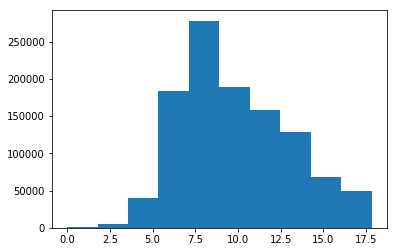

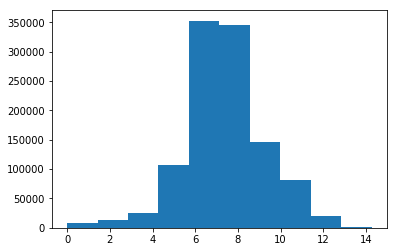

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
## plot follower counts
plt.hist(np.log(user_data[user_data.loc[:, 'username'].isin(combined_tag_data_users_with_stats)].loc[:, 'followers_count']+1))
plt.show()
## plot friend counts
plt.hist(np.log(user_data[user_data.loc[:, 'username'].isin(combined_tag_data_users_with_stats)].loc[:, 'friends_count']+1))
plt.show()

In [20]:
combined_tag_user_data = pd.merge(combined_tag_user_data, user_data[user_data.loc[:, 'username'].isin(combined_tag_user_data.loc[:, 'username'])].drop_duplicates('username', inplace=False).loc[:, ['username', 'followers_count', 'friends_count']], on='username', how='inner')
## log-scale
combined_tag_user_data = combined_tag_user_data.assign(**{
    'followers_log' : np.log(combined_tag_user_data.loc[:, 'followers_count'].values + 1.),
    'friends_log' : np.log(combined_tag_user_data.loc[:, 'friends_count'].values + 1.),
})
## add ratio
combined_tag_user_data = combined_tag_user_data.assign(**{
    'followers_friend' : combined_tag_user_data.loc[:, 'followers_log'].values - combined_tag_user_data.loc[:, 'friends_log'].values,
})
print(combined_tag_user_data.shape)
# display(combined_tag_user_data.head())

(27528, 28)


id                                                txt  \
0  1036176030975832064  RT @NHC_Atlantic: Tropical Storm #Florence Adv...   
1  1036804354504839170  RT @NHC_Atlantic: Tropical Storm #Florence Adv...   
2   901466847974916097  132mph peak wind gust at Port Aransas, TX at l...   
3  1036721999345856513  RT @NHC_Atlantic: Tropical Storm #Florence Adv...   
4  1036808322295447553  RT @kevinsweather: A lot of questions about #F...   

  data_name_fixed        username          date lang            NE   NE_type  \
0        florence  thestormreport  1.535879e+09   en      Florence  LOCATION   
1        florence  thestormreport  1.536028e+09   en      Florence  LOCATION   
2          harvey  thestormreport  1.503761e+09   en  Port_Aransas  LOCATION   
3        florence    CoryFroomkin  1.536009e+09   en      Florence  LOCATION   
4        florence   zachary_lane3  1.536029e+09   en      Florence  LOCATION   

   NE_LOC  valid_loc  ...  time_period_type  max_pop max_names max_pop_bin  \
0    True       True  ...              form  32227.0      21.0           2   
1    True       True  ...              form  32227.0      21.0           2   
2    True       True  ...          landfall   3955.0       6.0           2   
3    True       True  ...              form  32227.0      21.0           2   
4    True       True  ...              form  32227.0      21.0           2   

  max_names_bin  followers_count  friends_count  followers_log friends_log  \
0             2          13845.0         5034.0       9.535752    8.524169   
1             2          13845.0         5034.0       9.535752    8.524169   
2             1          13845.0         5034.0       9.535752    8.524169   
3             2           5566.0         4879.0       8.624612    8.492900   
4             2            746.0         1563.0       6.616065    7.355002   

   followers_friend  
0          1.011583  
1          1.011583  
2          1.011583  
3          0.131711  
4         -0.738937  

[5 rows x 28 columns]

Who are some of the top users?

In [52]:
display(combined_tag_user_data.drop_duplicates('username', inplace=False).sort_values('followers_friend', inplace=False, ascending=False).loc[:, ['username', 'followers_friend']])

username  followers_friend
2488   AristeguiOnline         13.701686
15963           cnnbrk         13.002809
6588       Breaking911         12.591491
18263         BBCWorld         12.466451
3122        mikeseidel         12.202167
3887           SkyNews         12.019604
25037     daddy_yankee         11.602249
8056           OCEANUP         11.328149
2159         InfoEmerg         11.025344
13465     GoogleTrends         10.951285
7179    TwitterMoments         10.907651
15807          FoxNews         10.702475
10614          ZeeNews         10.528175
24902   andersoncooper         10.524085
12760              CNN         10.492163
10631   CapitalTV_News         10.398730
12191      indiatvnews         10.292705
17230     RyanSeacrest         10.254077
17420        the_hindu         10.130548
1491               ABC         10.084352
15558             cnni          9.968225
21433            CNNEE          9.911195
27468  Franklin_Graham          9.903776
11852          elnorte          9.689503
20804    UltimaHora_SV          9.647498
12536      mathrubhumi          9.617648
8808           CBSNews          9.592939
2491      prensa_libre          9.590796
8301   wallacejnichols          9.305423
6014        bbcweather          9.282450
...                ...               ...
20116   StoneyStone062         -3.540959
9361      skittles4399         -3.580666
6946             lihbz         -3.597312
25509  Jackiie__Daniel         -3.605877
7047   lynnham40748399         -3.611839
20073  viewerschoice24         -3.641089
6990     creaturatx285         -3.650658
8798      ErlcaRObrien         -3.657483
17942    loyalsongbird         -3.688879
27513   ZacconeMaryann         -3.688879
19349     TomWinston75         -3.713572
6124       nensung3045         -3.732644
21955  CharlotteFermi3         -3.737670
23644       OkieStones         -3.761200
7269           cstebno         -3.772761
21498     najafawan786         -3.817134
22441       THEJCRTUBE         -3.828641
22028         rarodz64         -3.843030
25685  PennyRo04725347         -3.871201
26700   RussDeCastro70         -3.931826
18229       lavander55         -3.957474
7991   JarrettDWllgero         -3.989887
9466   SueCoop09524599         -4.016383
7363      kamelbaby151         -4.193778
27226       aminervini         -4.330733
8044   RealMilesWatson         -4.418841
17204   altcountyparks         -4.432007
21908    micah_jamison         -4.454347
9050       getfriedATX         -4.584967
11094          VIVEOR5         -7.029088

[16676 rows x 2 columns]

Same prediction setup!

In [47]:
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_tag_user_data_pred = combined_tag_user_data.copy()
scalar_vars = ['since_form', 'since_landfall', 'since_dissipation', 'followers_log', 'followers_friend']
for x in scalar_vars:
    combined_tag_user_data_pred = combined_tag_user_data_pred.assign(**{x : scaler.fit_transform(combined_tag_user_data_pred.loc[:, x].values.reshape(-1,1))})

Joint first.

In [48]:
%%capture joint_data_output
import re
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import fit_evaluate_lr_model
joint_data_results = []
joint_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'followers_log', 'followers_friend', 'C(time_period_type)'])
ind_var_sets = [
#     ['C(NE_fixed)'], 
#     ['C(NE_fixed)', 'since_form'],
#     ['C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(NE_fixed)', 'C(time_period_type)', 'followers_log'],
    ['C(NE_fixed)', 'C(time_period_type)', 'followers_friend'],
#     ['C(NE_fixed)', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
#     ['since_form'],
#     ['since_form', 'since_landfall', 'since_dissipation'],
    ['C(time_period_type)', 'followers_log'],
    ['C(time_period_type)', 'followers_friend'],
#     ['since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
#     ['max_pop_bin', 'max_names_bin'],
#     ['max_pop_bin', 'max_names_bin', 'since_form'],
#     ['max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)', 'followers_log'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)', 'followers_friend'],
#     ['max_pop_bin', 'max_names_bin', 'since_form_binary', 'since_landfall_binary', 'since_dissipation_binary'],
]
cat_coeff_names_to_track = ['time_period_type']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else:
    cat_coeff_matcher = re.compile('.*')
dep_var = 'has_descriptor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_tag_user_data_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    joint_data_results.append([data_name, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        joint_data_coeffs.append([[data_name, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
joint_data_results = pd.DataFrame(joint_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
joint_data_coeffs = pd.DataFrame(np.vstack(joint_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [49]:
reload(models.model_helpers)
from models.model_helpers import pandas_df_to_markdown_table
## get mean/deviance
float_cols = ['acc_mean', 'deviance']
print('printing stats for %s'%(','.join(float_cols)))
# format cols
for x in float_cols:
    if(type(joint_data_results.loc[:, x].iloc[0]) is not str):
        joint_data_results.loc[:, x] = joint_data_results.loc[:, x].apply(lambda x: '%.3f'%(x))
pandas_df_to_markdown_table(joint_data_results)
## get coefficients, p-vals for time and importance vars
coeff_float_cols = ['coeff', 'p_val']
print('printing stats for %s'%(','.join(coeff_float_cols)))
# format cols
for x in coeff_float_cols:
#     if(type(joint_data_coeffs.loc[:, x].iloc[0]) is not str):
    joint_data_coeffs.loc[:, x] = joint_data_coeffs.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
pandas_df_to_markdown_table(joint_data_coeffs)

printing stats for acc_mean,deviance
data_name|ind_vars|acc_mean|deviance
---|---|---|---
joint|C(NE_fixed)+C(time_period_type)+followers_log|0.674|20823.582
joint|C(NE_fixed)+C(time_period_type)+followers_friend|0.674|20823.461
joint|C(time_period_type)+followers_log|0.529|23908.523
joint|C(time_period_type)+followers_friend|0.534|23902.508
joint|max_pop_bin+max_names_bin+C(time_period_type)+followers_log|0.577|23338.117
joint|max_pop_bin+max_names_bin+C(time_period_type)+followers_friend|0.577|23336.874

printing stats for coeff,p_val
data_name|ind_vars|var_name|coeff|p_val
---|---|---|---|---
joint|C(NE_fixed)+C(time_period_type)+followers_log|C(time_period_type)[T.form]|0.275|0.004
joint|C(NE_fixed)+C(time_period_type)+followers_log|C(time_period_type)[T.landfall]|0.041|0.408
joint|C(NE_fixed)+C(time_period_type)+followers_log|followers_log|0.007|0.689
joint|C(NE_fixed)+C(time_period_type)+followers_friend|C(time_period_type)[T.form]|0.276|0.004
joint|C(NE_fixed)+C(time_period_type

OK! So we see that adding `followers_log` and `followers_friend` (1) doesn't affect the overall fit and (2) doesn't result in significant effects (some positive effects for `followers_friend`). Let's double check with the individual data sets to be sure.

In [50]:
%%capture per_data_output
per_data_results = []
per_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'followers_log', 'followers_friend', 'C(time_period_type)'])
ind_var_sets = [
    ['C(NE_fixed)', 'C(time_period_type)', 'followers_log'],
    ['C(NE_fixed)', 'C(time_period_type)', 'followers_friend'],
    ['C(time_period_type)', 'followers_log'],
    ['C(time_period_type)', 'followers_friend'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)', 'followers_log'],
    ['max_pop_bin', 'max_names_bin', 'C(time_period_type)', 'followers_friend'],
]
cat_coeff_names_to_track = ['time_period_type']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else:
    cat_coeff_matcher = re.compile('.*')
test_pct = 0.9
for data_name_i, data_i in combined_tag_user_data_pred.groupby('data_name_fixed'):
    print('testing data=%s'%(data_name_i))
    for ind_var_set in ind_var_sets:
        print('testing ind_vars = %s'%(','.join(ind_var_set)))
        model_results, predict_acc = fit_evaluate_lr_model(data_i, ind_var_set, dep_var, test=test_pct, balance=True)
        print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
        per_data_results.append([data_name_i, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
        if(len(coeff_names_to_track & set(ind_var_set)) > 0):
            per_data_coeffs.append([[data_name_i, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])

In [51]:
per_data_results = pd.DataFrame(per_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
per_data_coeffs = pd.DataFrame(np.vstack(per_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])
## get mean/deviance
float_cols = ['acc_mean', 'deviance']
print('printing stats for %s'%(','.join(float_cols)))
for data_name_i, data_i in per_data_results.groupby('data_name'):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(x))
    data_i.drop('data_name', axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)
    
## get coefficients, p-vals for time and importance vars
coeff_float_cols = ['coeff', 'p_val']
print('printing stats for %s'%(','.join(coeff_float_cols)))
for (data_name_i), data_i in per_data_coeffs.groupby(['data_name']):
    print('processing data %s'%(data_name_i))
    # format cols
    for x in coeff_float_cols:
        data_i.loc[:, x] = data_i.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
    data_i.drop(['data_name'], axis=1, inplace=True)
    pandas_df_to_markdown_table(data_i)

printing stats for acc_mean,deviance
processing data florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)+C(time_period_type)+followers_log|0.606|4589.211
C(NE_fixed)+C(time_period_type)+followers_friend|0.612|4581.794
C(time_period_type)+followers_log|0.525|5070.403
C(time_period_type)+followers_friend|0.531|5065.680
max_pop_bin+max_names_bin+C(time_period_type)+followers_log|0.530|5041.542
max_pop_bin+max_names_bin+C(time_period_type)+followers_friend|0.538|5037.085

processing data harvey
ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)+C(time_period_type)+followers_log|0.683|1794.163
C(NE_fixed)+C(time_period_type)+followers_friend|0.676|1794.297
C(time_period_type)+followers_log|0.580|2438.736
C(time_period_type)+followers_friend|0.581|2437.487
max_pop_bin+max_names_bin+C(time_period_type)+followers_log|0.756|1971.145
max_pop_bin+max_names_bin+C(time_period_type)+followers_friend|0.758|1971.721

processing data irma
ind_vars|acc_mean|deviance
---|---|---
C(NE_fixed)+C(time_period_type)+followers_log|0.652|8379.412
C(NE_fixed)+C(time

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


ind_vars|var_name|coeff|p_val
---|---|---|---
C(NE_fixed)+C(time_period_type)+followers_log|C(time_period_type)[T.form]|0.072|0.798
C(NE_fixed)+C(time_period_type)+followers_log|C(time_period_type)[T.landfall]|0.128|0.224
C(NE_fixed)+C(time_period_type)+followers_log|followers_log|0.030|0.474
C(NE_fixed)+C(time_period_type)+followers_friend|C(time_period_type)[T.form]|0.088|0.756
C(NE_fixed)+C(time_period_type)+followers_friend|C(time_period_type)[T.landfall]|0.134|0.204
C(NE_fixed)+C(time_period_type)+followers_friend|followers_friend|0.084|0.046
C(time_period_type)+followers_log|C(time_period_type)[T.form]|-0.232|0.370
C(time_period_type)+followers_log|C(time_period_type)[T.landfall]|0.212|0.028
C(time_period_type)+followers_log|followers_log|0.047|0.240
C(time_period_type)+followers_friend|C(time_period_type)[T.form]|-0.207|0.423
C(time_period_type)+followers_friend|C(time_period_type)[T.landfall]|0.224|0.021
C(time_period_type)+followers_friend|followers_friend|0.105|0.010
max_pop_

In general, weak positive effects for `followers` stats except for Florence which had negative effects (mostly local reporters with high follower count?).

### Aggregate audience trends
Let's confirm these findings by looking at aggregate probabilities by different follower count levels.

In [54]:
combined_tag_user_data.columns

Index(['id', 'txt', 'data_name_fixed', 'username', 'date', 'lang', 'NE',
       'NE_type', 'NE_LOC', 'valid_loc', 'has_descriptor', 'NE_fixed',
       'dissipation', 'form', 'landfall', 'since_form', 'since_landfall',
       'since_dissipation', 'time_period_type', 'max_pop', 'max_names',
       'max_pop_bin', 'max_names_bin', 'followers_count', 'friends_count',
       'followers_log', 'friends_log', 'followers_friend'],
      dtype='object')

[ 0.          4.45170759  8.90341519 13.35512278 17.80683037]
[3 3 3 ... 2 3 3]
[1 2 3 4 5]


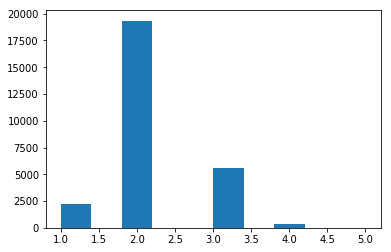

In [59]:
bins = np.linspace(combined_tag_user_data.loc[:, 'followers_log'].min(), combined_tag_user_data.loc[:, 'followers_log'].max(), num=5)
binned = np.digitize(combined_tag_user_data.loc[:, 'followers_log'], bins=bins)
print(bins)
print(binned)
print(np.unique(binned))
plt.hist(binned)
plt.show()

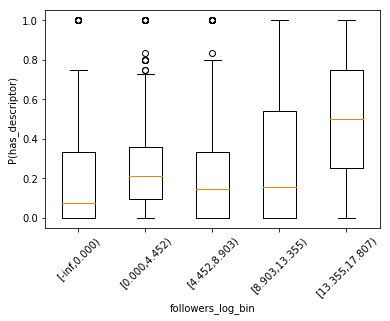

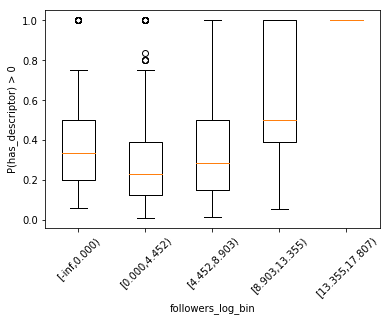

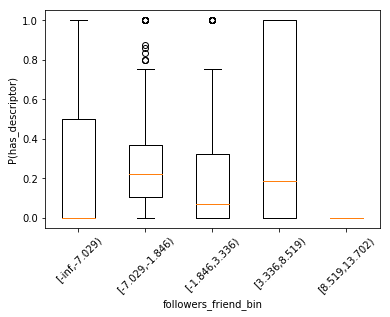

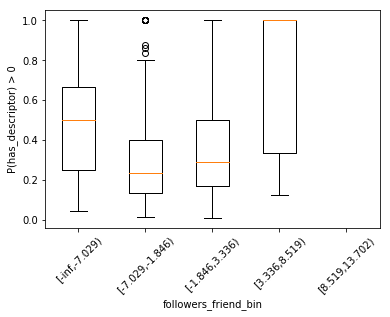

In [74]:
# bin audience and compute P(descriptor)
import numpy as np
combined_tag_user_data_bin = combined_tag_user_data.copy()
N_bins = 5
dep_var = 'has_descriptor'
audience_vars = ['followers_log', 'followers_friend']
for audience_var in audience_vars:
    audience_var_bin = '%s_bin'%(audience_var)
    data_a = combined_tag_user_data_bin.loc[:, audience_var].values
    bins_a = np.linspace(data_a.min(), data_a.max(), num=N_bins)
    binned_a = np.digitize(data_a, bins=bins_a)
    # get labels for plots
    binned_a_labels = [[-np.inf, bins_a[0]]] + [[bins_a[i-1], bins_a[i]] for i in range(1, N_bins)]
    binned_a_labels = ['[%.3f,%.3f)'%(x, y) for x,y in binned_a_labels]
    X = np.arange(N_bins)+1.
    combined_tag_user_data_bin = combined_tag_user_data_bin.assign(**{audience_var_bin : binned_a})
    # compute P(descriptor) for all entities in each bin
    info_prob_bins = combined_tag_user_data_bin.groupby([audience_var_bin, 'NE_fixed']).apply(lambda x: x.loc[:, dep_var].mean())
    info_prob_bins = [info_prob_bins.loc[x] for x in np.unique(binned_a)]
    plt.boxplot(info_prob_bins)
    plt.xlabel(audience_var_bin)
    plt.ylabel('P(%s)'%(dep_var))
    plt.xticks(X, binned_a_labels, rotation=45.)
    plt.show()
    ## remove zero vals?
    info_prob_bins = [x[x > 0.] for x in info_prob_bins]
    plt.boxplot(info_prob_bins)
    plt.xlabel(audience_var_bin)
    plt.ylabel('P(%s) > 0'%(dep_var))
    plt.xticks(X, binned_a_labels, rotation=45.)
    plt.show()

OK! The mid-range audience sizes tend to use descriptors more consistently than small or large, possibly because the small audience sizes tend to be locals (no descriptor) and large audience sizes only mention large locations (no descriptor). However, when it comes to more frequent NEs the small/large audience sizes use more descriptors, possibly because the more frequent NEs are also more dynamic and require more descriptors for especially small/large audiences, as compared to medium audiences who already have a prior on the information status.